In [1]:
import os
import bz2
import time
import json
from tqdm import tqdm
import pandas as pd

from tqdm.notebook import tqdm_notebook  # If you're in a Jupyter environment, otherwise skip this line

# If you're in a Jupyter notebook environment
tqdm_notebook.pandas()

# Define the path to the directory: in this case, Journal de Geneve
NEWSPAPER_FOLDER = 'collections'

data = []

# To get the total number of bz2 files beforehand (for accurate progress bar)
total_files = sum(1 for _, _, filenames in os.walk(NEWSPAPER_FOLDER) for f in filenames if f.endswith('.csv'))

i = 0
# Walk through the directory
file_time_start = time.time()
for dirpath, dirnames, filenames in os.walk(NEWSPAPER_FOLDER):
    for filename in tqdm(filenames, total=total_files, desc="Reading files"):
        # Check if the file has a .bz2 extension
        if filename.endswith('.csv'):
            filepath = os.path.join(dirpath, filename)    
            fichier = pd.read_csv(filepath, sep= ";")
            fichier['filename'] = filename
            data.append(fichier)

    print(f'Number of files in {dirpath}: {len(filenames)}. Time taken to read files: {time.time() - file_time_start}')

data = pd.concat(data)

Reading files: 17it [00:00, 98.05it/s]                                          

Number of files in collections: 17. Time taken to read files: 0.19383502006530762


In [2]:
import re

data = data.drop(['[total:1,available:100]', '[total:3,available:100]',
       '[total:114,available:200]', '[total:1629,available:1700]', 'content_provider', 
       '[total:87,available:100]', '[total:10,available:100]', 'is_content_available', 'access_right', 
       '[total:33,available:100]', '[total:137,available:200]',
       '[total:5,available:100]', '[total:135,available:200]', '[total:2,available:100]'], axis=1)
data = data.drop(['type'], axis=1)
data = data.drop(['collections'], axis=1)
data = data.drop(['relevance'], axis=1)
data['NAME'] = data['filename'].apply(lambda filename: filename[0].upper() + filename[1:-4])

data['Year'] = data['uid'].apply(lambda x: int(re.search(r'\d{4}', x).group()) if re.search(r'\d{4}', x) else None)
data.dropna(subset=['content'], inplace=True)

In [3]:
data.head()

uid language                    title  size country  \
0  JDG-1882-09-01-a-i0001       fr                    SUSSE  4435      CH   
1  JDG-1902-09-06-a-i0042       fr       DERNIÈRESJ1ÉPÊCHES   593      CH   
0  LLE-1893-11-18-a-i0007       fr  L'EXPOSITION DE CHICAGO  1379      CH   
0  IMP-1929-08-17-a-i0004       fr   AU PIED OU CA\TO€.lMIE  1880      CH   
0  IMP-1935-07-22-a-i0090       fr                Çn Suisse   605      CH   

  newspaper             issue pages  nb_pages  year  is_on_front  \
0       JDG  JDG-1882-09-01-a   1,2         2  1882         True   
1       JDG  JDG-1902-09-06-a     3         1  1902        False   
0       LLE  LLE-1893-11-18-a     3         1  1893        False   
0       IMP  IMP-1929-08-17-a     1         1  1929         True   
0       IMP  IMP-1935-07-22-a     8         1  1935        False   

                   date                                  persons_mentioned  \
0  1882-09-01T00:00:00Z  SUSSE GEK'EVE|major Hart|Les Arabes|Garnet Wol...   
1  1902-09-06T00:00:00Z    Fritz Meyer|Ernest Ruch|professeur Hans Wirchow   
0  1893-11-18T00:00:00Z                                                NaN   
0  1929-08-17T00:00:00Z                 Val Perret|Val Perret|Henri BUHLER   
0  1935-07-22T00:00:00Z  M. Gottfried Steffen|M. Gottfried Steffen|M. F...   

                                 locations_mentioned  \
0  Graham|Graham|Baker|Russell|Graham|Alexandrie|...   
1  Suisse|Bienne|Bienne|Metz|Rhône|Lucerne|Lugano...   
0  CHICAGO|Chicago|France|France|Italie|Japon|Bel...   
0              Cologne|Savoie|Venise|Rialto|Martigny   
0  Suisse|FRIBOURG|Fribourg|Suisse|Bâle|OLTEN|Sol...   

                                             content         filename  \
0  SUSSE GEK'EVE, 1 " Septembre 1882. BULLETIN PO...        rhone.csv   
1  DERNIÈRESJ 1 ÉPÊCHES Suisse BERNE. — Double su...        rhone.csv   
0  LEXPOSITION DE CHICAGO Chicago , le 6 oclobre ...  grindelwald.csv   
0  AU PIED OU CA \ TO €. lMIE Notes « fi'easra pr...      arpette.csv   
0  Çn Suisse La fête des musiques ouvrières FRIBO...         pers.csv   

          NAME  Year  
0        Rhone  1882  
1        Rhone  1902  
0  Grindelwald  1893  
0      Arpette  1929  
0         Pers  1935

In [4]:
data.NAME.unique()

array(['Rhone', 'Grindelwald', 'Arpette', 'Pers', 'Zmutt', 'Orny',
       'Allalin', 'Aletsch', 'Otemma', 'Morteratsch', 'Kanderfirn',
       'Trient', 'Rosa', 'Zinal', 'Roseg', 'Arolla'], dtype=object)

Let's keep only the glaciers that are in the wgms.

In [5]:
#'RHONE' 'OBERER GRINDELWALD' 'UNTERER GRINDELWALD' 'ZMUTT' 'ALLALIN' 'GROSSER ALETSCH' 'OTEMMA' 'MORTERATSCH'
#'TRIENT' 'ZINAL' 'ROSEG' 'AROLLA (BAS)'

GLACIER_MAP = {'Rhone': 'RHONE',
              'Grindelwald': 'OBERER GRINDELWALD',
              'Zmutt': 'ZMUTT',
              'Allalin': 'ALLALIN',
              'Aletsch': 'GROSSER ALETSCH',
              'Otemma': 'OTEMMA',
              'Morteratsch': 'MORTERATSCH',
              'Roseg': 'ROSEG',
              'Arolla': 'AROLLA (BAS)',
              'Zinal': 'ZINAL',
              'Trient': 'TRIENT'}

print(len(data))
data = data[data['NAME'].isin(GLACIER_MAP.keys())]

# Map the glacier names to the new names
data['NAME'] = data['NAME'].map(GLACIER_MAP)

print(len(data))

data.head()

2156
1869


uid language  \
0  JDG-1882-09-01-a-i0001       fr   
1  JDG-1902-09-06-a-i0042       fr   
0  LLE-1893-11-18-a-i0007       fr   
0  GDL-1901-08-05-a-i0017       fr   
0  JDG-1965-09-03-a-i0011       fr   

                                        title  size country newspaper  \
0                                       SUSSE  4435      CH       JDG   
1                          DERNIÈRESJ1ÉPÊCHES   593      CH       JDG   
0                     L'EXPOSITION DE CHICAGO  1379      CH       LLE   
0                   fèhxoaiqoe des &lt;£lpes.   672      CH       GDL   
0  Le rôle des experts et leur responsabilité   547      CH       JDG   

              issue pages  nb_pages  year  is_on_front                  date  \
0  JDG-1882-09-01-a   1,2         2  1882         True  1882-09-01T00:00:00Z   
1  JDG-1902-09-06-a     3         1  1902        False  1902-09-06T00:00:00Z   
0  LLE-1893-11-18-a     3         1  1893        False  1893-11-18T00:00:00Z   
0  GDL-1901-08-05-a     2         1  1901        False  1901-08-05T00:00:00Z   
0  JDG-1965-09-03-a     3         1  1965        False  1965-09-03T00:00:00Z   

                                   persons_mentioned  \
0  SUSSE GEK'EVE|major Hart|Les Arabes|Garnet Wol...   
1    Fritz Meyer|Ernest Ruch|professeur Hans Wirchow   
0                                                NaN   
0  M. Perrin|M. Perrin|M. Perrin|M. Perrin|Jos de...   
0                                          P. Kassel   

                                 locations_mentioned  \
0  Graham|Graham|Baker|Russell|Graham|Alexandrie|...   
1  Suisse|Bienne|Bienne|Metz|Rhône|Lucerne|Lugano...   
0  CHICAGO|Chicago|France|France|Italie|Japon|Bel...   
0      Genève|Davos|Davos|Davos|Prague|Genève|Zurich   
0                                Mission|Davos|Celle   

                                             content         filename  \
0  SUSSE GEK'EVE, 1 " Septembre 1882. BULLETIN PO...        rhone.csv   
1  DERNIÈRESJ 1 ÉPÊCHES Suisse BERNE. — Double su...        rhone.csv   
0  LEXPOSITION DE CHICAGO Chicago , le 6 oclobre ...  grindelwald.csv   
0  fèhxoaiqoe des < £ lpes. 96 HEURES DANS LA GLA...        zmutt.csv   
0  Le rôle des experts et leur responsabilité Réd...      allalin.csv   

                 NAME  Year  
0               RHONE  1882  
1               RHONE  1902  
0  OBERER GRINDELWALD  1893  
0               ZMUTT  1901  
0             ALLALIN  1965

In [6]:
GLACIER_MAP.values()

dict_values(['RHONE', 'OBERER GRINDELWALD', 'ZMUTT', 'ALLALIN', 'GROSSER ALETSCH', 'OTEMMA', 'MORTERATSCH', 'ROSEG', 'AROLLA (BAS)', 'ZINAL', 'TRIENT'])

In [7]:
import chardet

with open('WGMS-FoG-2017-10-C-FRONT-VARIATION.csv', 'rb') as f:
    result = chardet.detect(f.read())

encoding = result['encoding']

wgms_front = pd.read_csv('WGMS-FoG-2017-10-C-FRONT-VARIATION.csv', encoding=encoding)

print(len(wgms_front))
wgms_front = wgms_front[wgms_front['NAME'].isin(GLACIER_MAP.values())]
print('Data with only the chosen glaciers:', len(wgms_front))

wgms_front.head()

44692
Data with only the chosen glaciers: 1229


POLITICAL_UNIT     NAME  WGMS_ID  Year  FRONT_VARIATION  FRONT_VAR_UNC  \
10724             CH  ALLALIN      394  1884             50.0            NaN   
10725             CH  ALLALIN      394  1887              0.0            NaN   
10726             CH  ALLALIN      394  1888              0.0            NaN   
10727             CH  ALLALIN      394  1890             18.0            NaN   
10728             CH  ALLALIN      394  1893              6.0            NaN   

      QUALITATIVE_VARIATION  SURVEY_DATE SURVEY_PATFORM_METHOD  \
10724                   NaN   18849999.0                   NaN   
10725                   NaN   18879999.0                   NaN   
10726                   NaN   18889999.0                   NaN   
10727                   NaN   18909999.0                   NaN   
10728                   NaN   18939999.0                   NaN   

       REFERENCE_DATE  PUB_IN_FOG INVESTIGATOR SPONS_AGENCY REFERENCE REMARKS  
10724      18819999.0      1995.0          NaN          NaN       NaN     NaN  
10725      18869999.0      1995.0          NaN          NaN       NaN     NaN  
10726      18879999.0      1995.0          NaN          NaN       NaN     NaN  
10727      18899999.0      1995.0          NaN          NaN       NaN     NaN  
10728      18929999.0      1995.0          NaN          NaN       NaN     NaN

In [8]:
import pandas as pd

import chardet

with open('WGMS-FoG-2017-10-F-SPECIAL-EVENT.csv', 'rb') as f:
    result = chardet.detect(f.read())

encoding = result['encoding']

wgms_event = pd.read_csv('WGMS-FoG-2017-10-F-SPECIAL-EVENT.csv', encoding=encoding)

wgms_event = pd.DataFrame(wgms_event)

# Conversion des valeurs de la colonne 'EVENT_DATE' en chaînes de caractères
wgms_event['EVENT_DATE'] = wgms_event['EVENT_DATE'].astype(str)

# Création de la colonne "Date"
wgms_event['Year'] = wgms_event['EVENT_DATE'].apply(lambda x: x[:4] if x[:4] != '9999' else 'no date')
print('Events with and without dates:', len(wgms_event))

wgms_event = wgms_event[wgms_event['Year'] != 'no date']
print('Events with dates:', len(wgms_event))

wgms_event['Year'] = wgms_event['Year'].astype(int)

wgms_event = wgms_event[wgms_event['NAME'].isin(GLACIER_MAP.values())]
print('Data with only the chosen glaciers:', len(wgms_event))

wgms_event.head()

Events with and without dates: 3047
Events with dates: 1562
Data with only the chosen glaciers: 8


POLITICAL_UNIT             NAME  Event_ID  WGMS_ID EVENT_DATE  ET_SURGE  \
623             CH          ALLALIN       112      394   19650830       0.0   
624             CH          ALLALIN        74      394   19991101       0.0   
625             CH          ALLALIN       160      394   20000730       0.0   
665             CH  GROSSER ALETSCH       182      360   18720802       0.0   
666             CH  GROSSER ALETSCH        38      360   19959999       0.0   

     ET_CALVING  ET_FLOOD  ET_AVALANCHE  ET_TECTONIC  ET_OTHER  \
623         0.0       0.0           1.0          0.0       0.0   
624         0.0       0.0           1.0          0.0       0.0   
625         0.0       0.0           1.0          0.0       0.0   
665         0.0       1.0           0.0          0.0       0.0   
666         0.0       0.0           0.0          1.0       0.0   

                                     EVENT_DESCRIPTION  INVESTIGATOR  \
623  On August 30, 1965, an ice avalanche of 2 mill...           NaN   
624  On October 31 / November 1st, 1999 about 160,0...           NaN   
625  On July 30th 2000 at 8:52 local time, a massiv...           NaN   
665  On August 8, 1872, Lake Märjelen drained sudde...           NaN   
666  The retreat of the tongue of the Great Aletsch...           NaN   

     SPONSORING_AGENCY                                          REFERENCE  \
623                NaN  www.glacierhazards.ch http://glaciology.ethz.c...   
624                NaN  Raymond, M., Wegmann, M. and Funk, M. (2003): ...   
625                NaN  http://glaciology.ethz.ch/inventar/download/al...   
665                NaN  www.glacierhazards.ch http://glaciology.ethz.c...   
666                NaN  WGMS (1998a): FoG 1990-1995 (Vol. VII),  IAHS ...   

    REMARKS  PUB_IN_FOG  Year  
623     NaN         NaN  1965  
624     NaN         NaN  1999  
625     NaN         NaN  2000  
665     NaN         NaN  1872  
666     NaN      1995.0  1995

In [9]:
# Define the event type columns
event_type_columns = ['ET_SURGE', 'ET_CALVING', 'ET_FLOOD', 'ET_AVALANCHE', 'ET_TECTONIC', 'ET_OTHER']

# Create a new column 'EVENT_TYPE' and initialize it with an empty string
wgms_event['EVENT_TYPE'] = ""

# Iterate over each row and accumulate all event types in a list
for index, row in wgms_event.iterrows():
    event_types = []
    for event_type in event_type_columns:
        if row[event_type] == 1:  # Assuming a value of 1 indicates the occurrence of the event
            # Append the event type, formatted as title case
            event_types.append(event_type.split('_')[-1].title())

    # Join all event types into a single string
    wgms_event.at[index, 'EVENT_TYPE'] = ', '.join(event_types)

# Optional: drop the original event type columns if they are no longer needed
# wgms_event.drop(columns=event_type_columns, inplace=True)

# Print the first few rows to check the new 'EVENT_TYPE' column
wgms_event.head()


POLITICAL_UNIT             NAME  Event_ID  WGMS_ID EVENT_DATE  ET_SURGE  \
623             CH          ALLALIN       112      394   19650830       0.0   
624             CH          ALLALIN        74      394   19991101       0.0   
625             CH          ALLALIN       160      394   20000730       0.0   
665             CH  GROSSER ALETSCH       182      360   18720802       0.0   
666             CH  GROSSER ALETSCH        38      360   19959999       0.0   

     ET_CALVING  ET_FLOOD  ET_AVALANCHE  ET_TECTONIC  ET_OTHER  \
623         0.0       0.0           1.0          0.0       0.0   
624         0.0       0.0           1.0          0.0       0.0   
625         0.0       0.0           1.0          0.0       0.0   
665         0.0       1.0           0.0          0.0       0.0   
666         0.0       0.0           0.0          1.0       0.0   

                                     EVENT_DESCRIPTION  INVESTIGATOR  \
623  On August 30, 1965, an ice avalanche of 2 mill...           NaN   
624  On October 31 / November 1st, 1999 about 160,0...           NaN   
625  On July 30th 2000 at 8:52 local time, a massiv...           NaN   
665  On August 8, 1872, Lake Märjelen drained sudde...           NaN   
666  The retreat of the tongue of the Great Aletsch...           NaN   

     SPONSORING_AGENCY                                          REFERENCE  \
623                NaN  www.glacierhazards.ch http://glaciology.ethz.c...   
624                NaN  Raymond, M., Wegmann, M. and Funk, M. (2003): ...   
625                NaN  http://glaciology.ethz.ch/inventar/download/al...   
665                NaN  www.glacierhazards.ch http://glaciology.ethz.c...   
666                NaN  WGMS (1998a): FoG 1990-1995 (Vol. VII),  IAHS ...   

    REMARKS  PUB_IN_FOG  Year EVENT_TYPE  
623     NaN         NaN  1965  Avalanche  
624     NaN         NaN  1999  Avalanche  
625     NaN         NaN  2000  Avalanche  
665     NaN         NaN  1872      Flood  
666     NaN      1995.0  1995   Tectonic

In [10]:
wgms_event.columns

Index(['POLITICAL_UNIT', 'NAME', 'Event_ID', 'WGMS_ID', 'EVENT_DATE',
       'ET_SURGE', 'ET_CALVING', 'ET_FLOOD', 'ET_AVALANCHE', 'ET_TECTONIC',
       'ET_OTHER', 'EVENT_DESCRIPTION', 'INVESTIGATOR', 'SPONSORING_AGENCY',
       'REFERENCE', 'REMARKS', 'PUB_IN_FOG', 'Year', 'EVENT_TYPE'],
      dtype='object')

In [11]:
wgms_front.columns

Index(['POLITICAL_UNIT', 'NAME', 'WGMS_ID', 'Year', 'FRONT_VARIATION',
       'FRONT_VAR_UNC', 'QUALITATIVE_VARIATION', 'SURVEY_DATE',
       'SURVEY_PATFORM_METHOD', 'REFERENCE_DATE', 'PUB_IN_FOG', 'INVESTIGATOR',
       'SPONS_AGENCY', 'REFERENCE', 'REMARKS'],
      dtype='object')

In [12]:
wgms_event.REFERENCE

623    www.glacierhazards.ch http://glaciology.ethz.c...
624    Raymond, M., Wegmann, M. and Funk, M. (2003): ...
625    http://glaciology.ethz.ch/inventar/download/al...
665    www.glacierhazards.ch http://glaciology.ethz.c...
666    WGMS (1998a): FoG 1990-1995 (Vol. VII),  IAHS ...
676    www.glacierhazards.ch http://glaciology.ethz.c...
677                                www.glacierhazards.ch
678    http://glaciology.ethz.ch/glacier-hazards/down...
Name: REFERENCE, dtype: object

In [13]:
wgms_front = wgms_front.drop(['REFERENCE', 'INVESTIGATOR'], axis=1)

In [14]:
len(data), len(wgms_front), len(wgms_event)

(1869, 1229, 8)

In [15]:
# Merging merged_data_front with merged_data_event
wgms_data = pd.merge(wgms_front, wgms_event, on=['POLITICAL_UNIT', 'NAME', 'Year'], 
                             how='outer')

print(len(wgms_data))
# Displaying the merged DataFrame
wgms_data.head()


1230


POLITICAL_UNIT     NAME  WGMS_ID_x  Year  FRONT_VARIATION  FRONT_VAR_UNC  \
0             CH  ALLALIN      394.0  1884             50.0            NaN   
1             CH  ALLALIN      394.0  1887              0.0            NaN   
2             CH  ALLALIN      394.0  1888              0.0            NaN   
3             CH  ALLALIN      394.0  1890             18.0            NaN   
4             CH  ALLALIN      394.0  1893              6.0            NaN   

  QUALITATIVE_VARIATION  SURVEY_DATE SURVEY_PATFORM_METHOD  REFERENCE_DATE  \
0                   NaN   18849999.0                   NaN      18819999.0   
1                   NaN   18879999.0                   NaN      18869999.0   
2                   NaN   18889999.0                   NaN      18879999.0   
3                   NaN   18909999.0                   NaN      18899999.0   
4                   NaN   18939999.0                   NaN      18929999.0   

   ...  ET_AVALANCHE ET_TECTONIC ET_OTHER  EVENT_DESCRIPTION  INVESTIGATOR  \
0  ...           NaN         NaN      NaN                NaN           NaN   
1  ...           NaN         NaN      NaN                NaN           NaN   
2  ...           NaN         NaN      NaN                NaN           NaN   
3  ...           NaN         NaN      NaN                NaN           NaN   
4  ...           NaN         NaN      NaN                NaN           NaN   

  SPONSORING_AGENCY  REFERENCE  REMARKS_y  PUB_IN_FOG_y  EVENT_TYPE  
0               NaN        NaN        NaN           NaN         NaN  
1               NaN        NaN        NaN           NaN         NaN  
2               NaN        NaN        NaN           NaN         NaN  
3               NaN        NaN        NaN           NaN         NaN  
4               NaN        NaN        NaN           NaN         NaN  

[5 rows x 29 columns]

In [16]:
# Merging all three DataFrames
final_data = pd.merge(data, wgms_data, on=['NAME', 'Year'], how='outer')

print(len(final_data), len(data))
# Display the merged DataFrame
final_data = final_data.dropna(how='all')
print(len(final_data))
# final_data.iloc[2896] # There are some years where there are no articles about some glaciers (but there are some events)

# Remove rows where 'content' is NaN
final_data = final_data.dropna(subset=['content'])
final_data[['FRONT_VARIATION']] = final_data[['FRONT_VARIATION']].fillna(value=0.0)

print(len(final_data))

2897 1869
2897
1869


In [17]:
final_data.FRONT_VARIATION.unique()

array([ -73. ,  -13. ,    0. ,  -10. , -394. , -100. ,   -6. ,  -30. ,
        -12. ,  -20. ,  -25. ,   -7. ,   -1. ,  -18. ,   -3. ,  -11. ,
         -5. ,  -21. ,  -33. ,  -14. ,   -4. ,   -2. ,  -19. ,  -24. ,
         -9. ,  -15. ,  -29. ,  -44. ,  -23. ,  -63. ,  -74. ,  -36. ,
         -8. ,  -16. ,  -34. ,  -28. ,  -42. ,  -40. ,  -27. ,  -22. ,
        -95. ,  -46. ,  -26. ,  -37. ,  -60. ,  -43. ,  -47.8,  -57. ,
        -28.4,  -41. ,  -65.6, -115. ,  -32. ,  -68. ,  -54. ,  -75. ,
        -78. ,  -17. ,  -66. ,  -24.2,  -61. ,  -35. ,    2. ,   15. ,
          7. ,    8. , -600. ,  -38. ,   10. ,    5. ,    4. ,   16. ,
          9. ,   12. ,   11. ,   14. ])

In [18]:
# import pandas as pd

# wgms_df = pd.DataFrame(wgms_dataframe)

# # Calculer la dérivée seconde (accélération) de FRONT_VARIATION
# wgms_df['Acceleration'] = wgms_df['FRONT_VARIATION'].diff().diff()

# wgms_df.head()

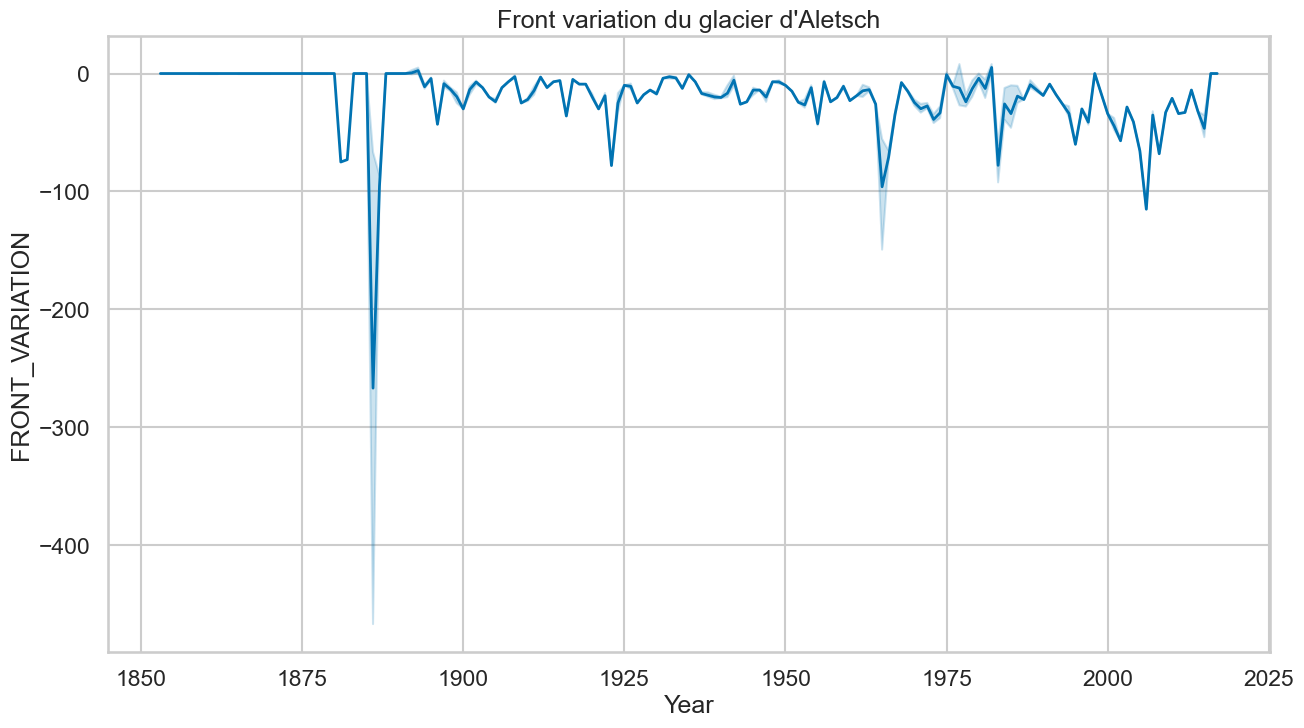

In [19]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(style="whitegrid", context="talk", font_scale=1.0)
sns.set_palette("colorblind")

# wgms_df = pd.DataFrame(wgms_dataframe)

# Ne garder que les lignes avec "GROSSER ALETSCH"
filtered_df = final_data[final_data['NAME'] == 'GROSSER ALETSCH']

#liste des glaciers 
#'Rhone', 'Grindelwald', 'Arpette', 'Pers', 'Zmutt', 'Orny','Allalin', 'Aletsch', 'Otemma', 'Morteratsch', 'Kanderfirn',
#'Trient', 'Rosa', 'Zinal', 'Roseg', 'Arolla'

#liste des glaciers dont les front variations ont été mesurées
#'RHONE' 'OBERER GRINDELWALD' 'UNTERER GRINDELWALD' 'ZMUTT' 'ALLALIN' 'GROSSER ALETSCH' 'OTEMMA' 'MORTERATSCH'
#'TRIENT' 'ZINAL' 'ROSEG' 'AROLLA (BAS)'


#delete les pics trop important ? (roseg)


plt.figure(figsize=(15, 8))
sns.lineplot(x='Year', y='FRONT_VARIATION', data=final_data, linewidth=2)
plt.title("Front variation du glacier d'Aletsch")
plt.show()

In [20]:
final_data.columns

Index(['uid', 'language', 'title', 'size', 'country', 'newspaper', 'issue',
       'pages', 'nb_pages', 'year', 'is_on_front', 'date', 'persons_mentioned',
       'locations_mentioned', 'content', 'filename', 'NAME', 'Year',
       'POLITICAL_UNIT', 'WGMS_ID_x', 'FRONT_VARIATION', 'FRONT_VAR_UNC',
       'QUALITATIVE_VARIATION', 'SURVEY_DATE', 'SURVEY_PATFORM_METHOD',
       'REFERENCE_DATE', 'PUB_IN_FOG_x', 'SPONS_AGENCY', 'REMARKS_x',
       'Event_ID', 'WGMS_ID_y', 'EVENT_DATE', 'ET_SURGE', 'ET_CALVING',
       'ET_FLOOD', 'ET_AVALANCHE', 'ET_TECTONIC', 'ET_OTHER',
       'EVENT_DESCRIPTION', 'INVESTIGATOR', 'SPONSORING_AGENCY', 'REFERENCE',
       'REMARKS_y', 'PUB_IN_FOG_y', 'EVENT_TYPE'],
      dtype='object')

In [21]:
# import pandas as pd
# import seaborn as sns
# import matplotlib.pyplot as plt

# sns.set(style="whitegrid", context="talk", font_scale=1.0)
# sns.set_palette("colorblind")

# plt.figure(figsize=(15, 8))

# for glacier_name in final_data.NAME.unique():
#     filtered_df = final_data[final_data['NAME'] == glacier_name]
#     sns.lineplot(x='Year', y='FRONT_VARIATION', data=filtered_df, linewidth=2, label=glacier_name)

# plt.title("Front variations des glaciers")
# plt.legend(title='Glacier')
# plt.show()

/var/folders/_3/vwbs1mlx70s08x_qwnrmjwdr0000gn/T/ipykernel_1160/937546131.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['Moving_Avg'] = filtered_df['FRONT_VARIATION'].rolling(window=5).mean()


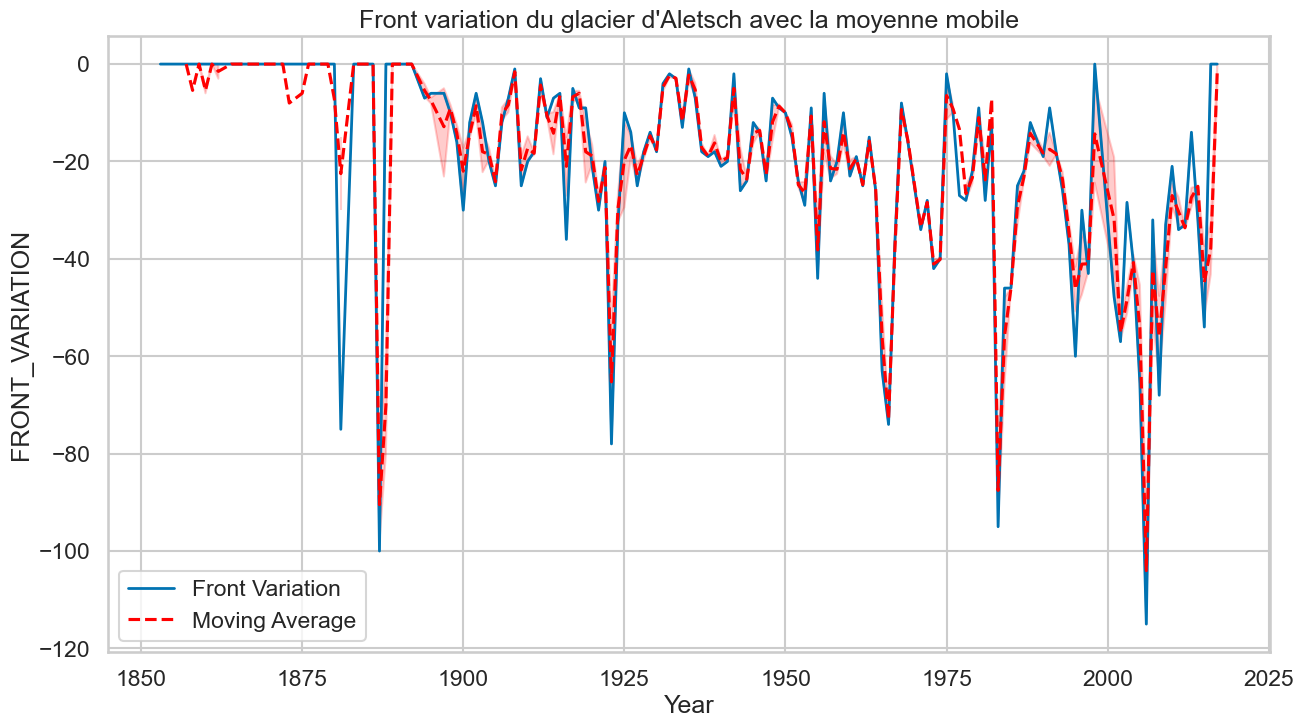

In [22]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(style="whitegrid", context="talk", font_scale=1.0)
sns.set_palette("colorblind")

# wgms_df = pd.DataFrame(wgms_dataframe)

# Ne garder que les lignes avec "GROSSER ALETSCH"
filtered_df = final_data[final_data['NAME'] == 'GROSSER ALETSCH']

# Calculer la moyenne mobile avec une fenêtre de 5 années
filtered_df['Moving_Avg'] = filtered_df['FRONT_VARIATION'].rolling(window=5).mean()

# Tracer le graphique
plt.figure(figsize=(15, 8))
sns.lineplot(x='Year', y='FRONT_VARIATION', data=filtered_df, linewidth=2, label='Front Variation')
sns.lineplot(x='Year', y='Moving_Avg', data=filtered_df, linestyle='--', color='red', label='Moving Average')

plt.title("Front variation du glacier d'Aletsch avec la moyenne mobile")
plt.legend()
plt.show()

In [23]:
# pd.set_option('display.max_columns', None)

final_data.columns

Index(['uid', 'language', 'title', 'size', 'country', 'newspaper', 'issue',
       'pages', 'nb_pages', 'year', 'is_on_front', 'date', 'persons_mentioned',
       'locations_mentioned', 'content', 'filename', 'NAME', 'Year',
       'POLITICAL_UNIT', 'WGMS_ID_x', 'FRONT_VARIATION', 'FRONT_VAR_UNC',
       'QUALITATIVE_VARIATION', 'SURVEY_DATE', 'SURVEY_PATFORM_METHOD',
       'REFERENCE_DATE', 'PUB_IN_FOG_x', 'SPONS_AGENCY', 'REMARKS_x',
       'Event_ID', 'WGMS_ID_y', 'EVENT_DATE', 'ET_SURGE', 'ET_CALVING',
       'ET_FLOOD', 'ET_AVALANCHE', 'ET_TECTONIC', 'ET_OTHER',
       'EVENT_DESCRIPTION', 'INVESTIGATOR', 'SPONSORING_AGENCY', 'REFERENCE',
       'REMARKS_y', 'PUB_IN_FOG_y', 'EVENT_TYPE'],
      dtype='object')

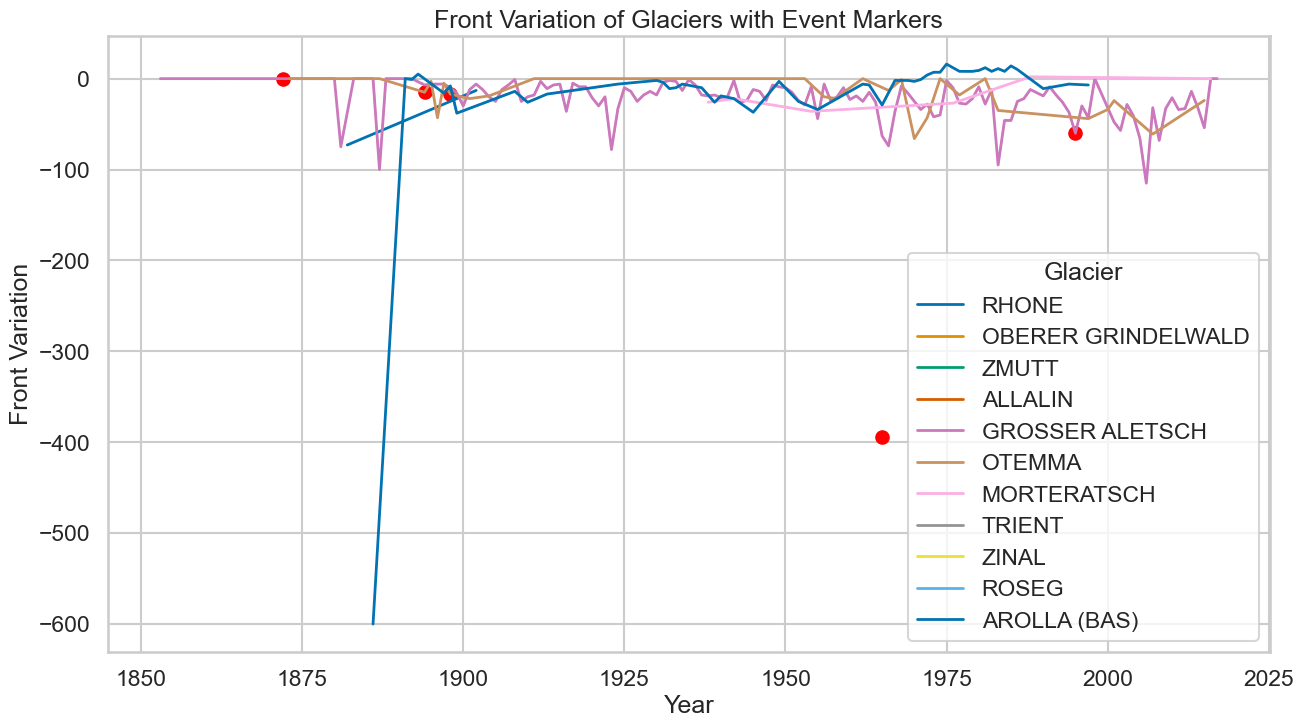

In [24]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(style="whitegrid", context="talk", font_scale=1.0)
sns.set_palette("colorblind")

plt.figure(figsize=(15, 8))

for glacier_name in final_data['NAME'].unique():
    filtered_df = final_data[final_data['NAME'] == glacier_name]

    # Check if 'FRONT_VARIATION' column exists and has non-null values
    # Plotting the line for front variation
    sns.lineplot(x='Year', y='FRONT_VARIATION', data=filtered_df, linewidth=2, label=glacier_name)

    # Identifying the years with events for this glacier
    event_years = filtered_df[~filtered_df['EVENT_DATE'].isna()]['Year'].unique()

    # Plotting red points for years with events
    for year in event_years:
        # Ensure there is data for the specific year
        if year in filtered_df['Year'].values:
            front_variation_year = filtered_df[filtered_df['Year'] == year]['FRONT_VARIATION'].iloc[0]
            plt.scatter(year, front_variation_year, color='red')

plt.title("Front Variation of Glaciers with Event Markers")
plt.xlabel('Year')
plt.ylabel('Front Variation')
plt.legend(title='Glacier')
plt.show()


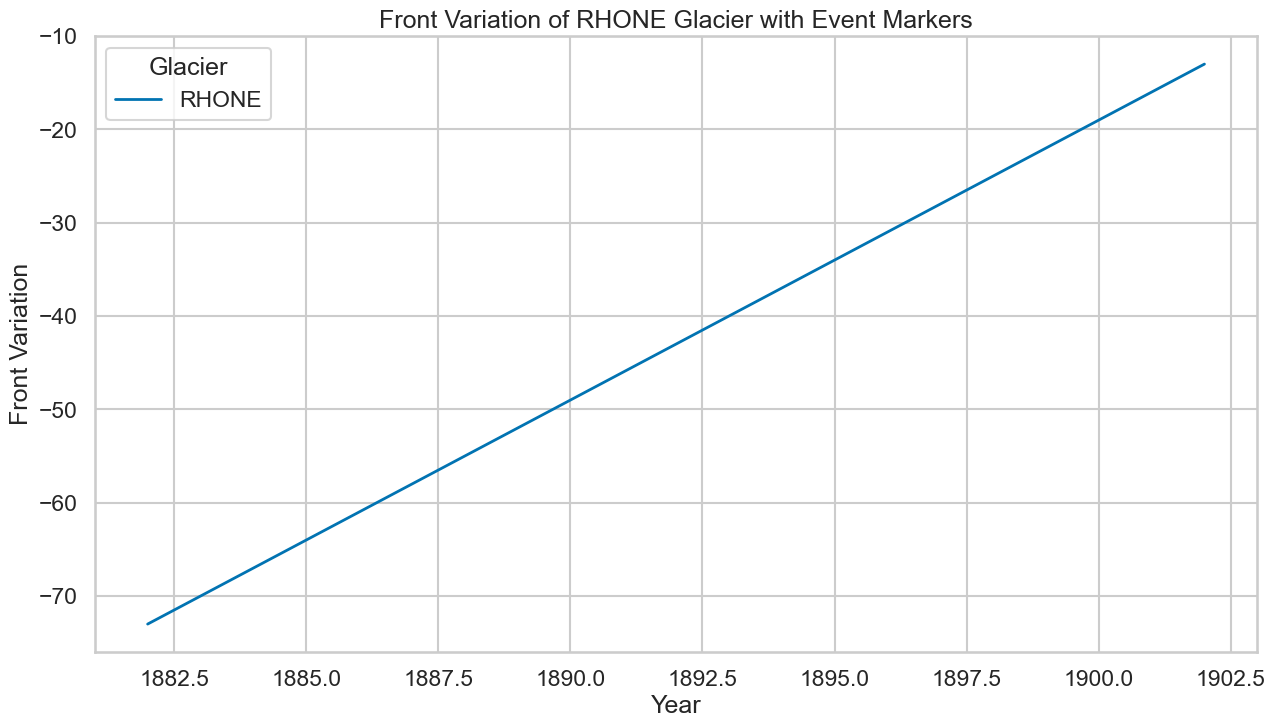

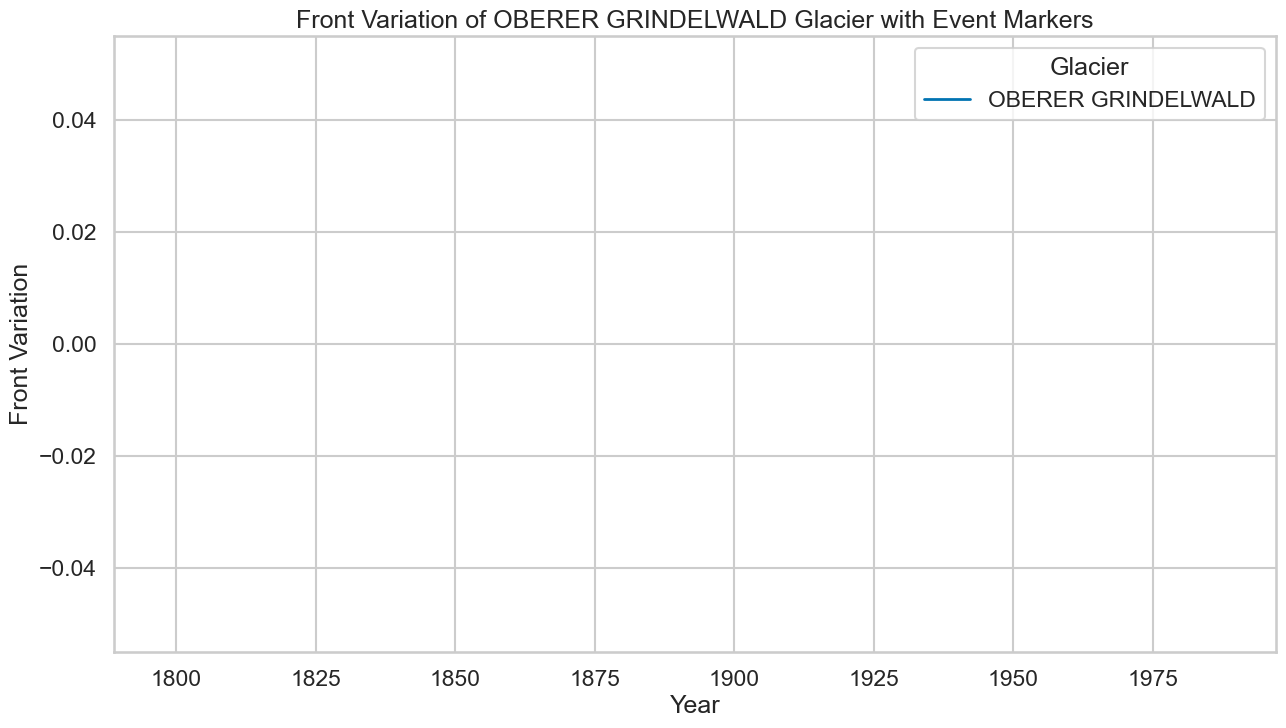

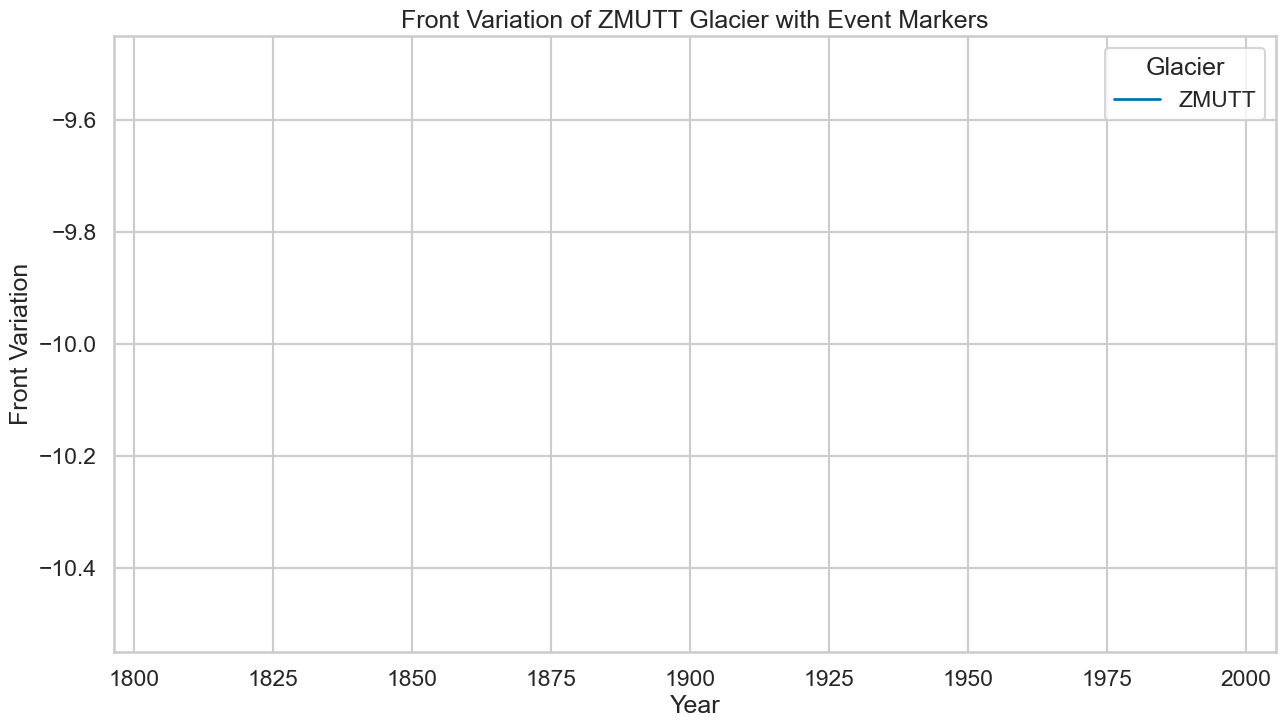

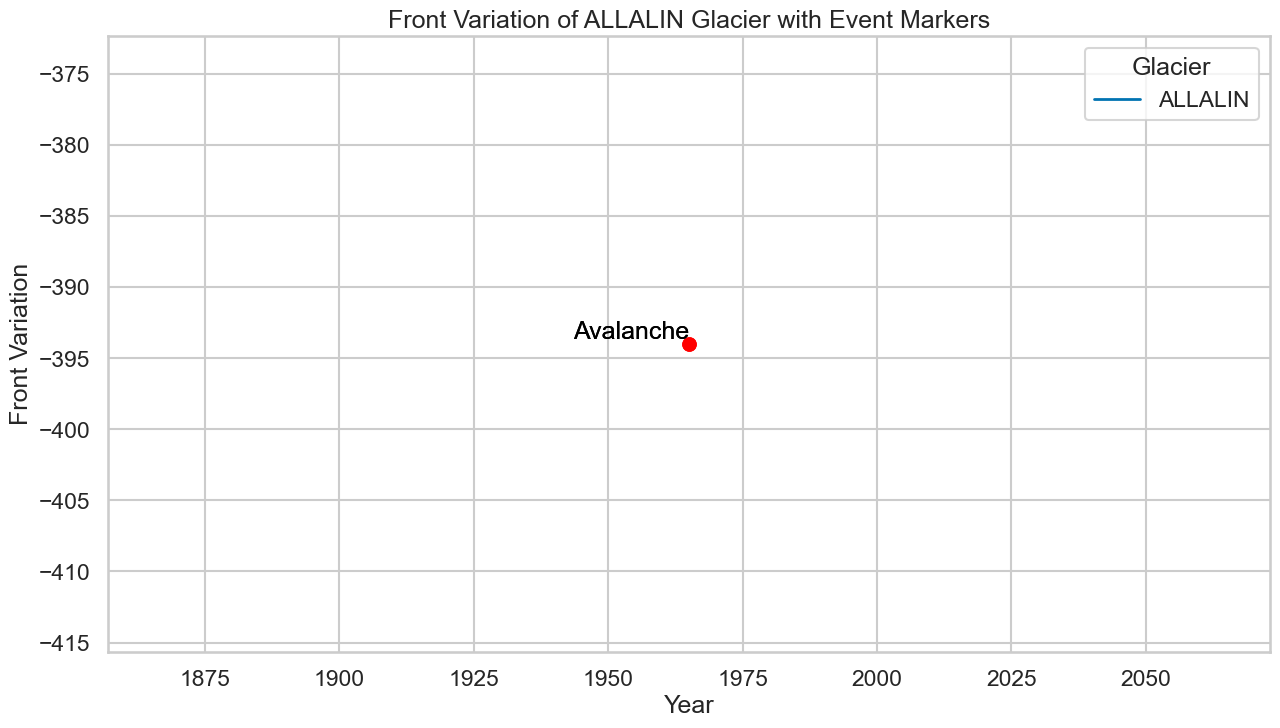

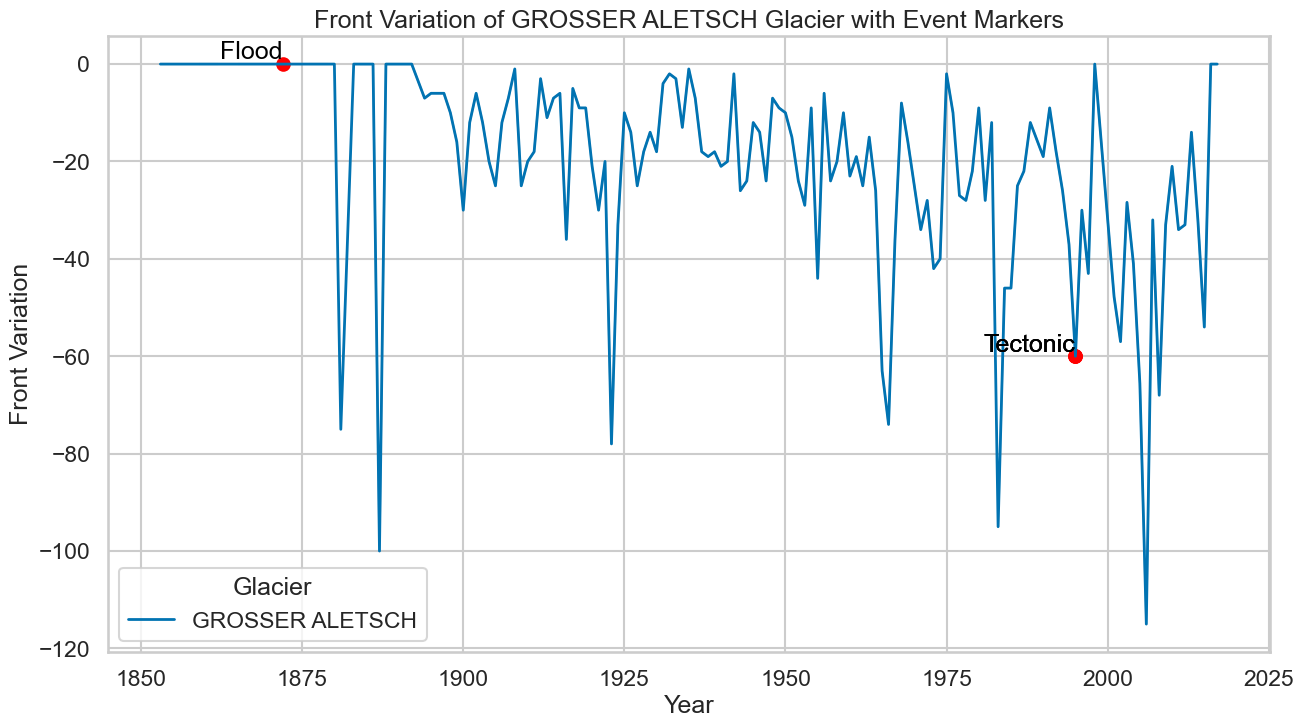

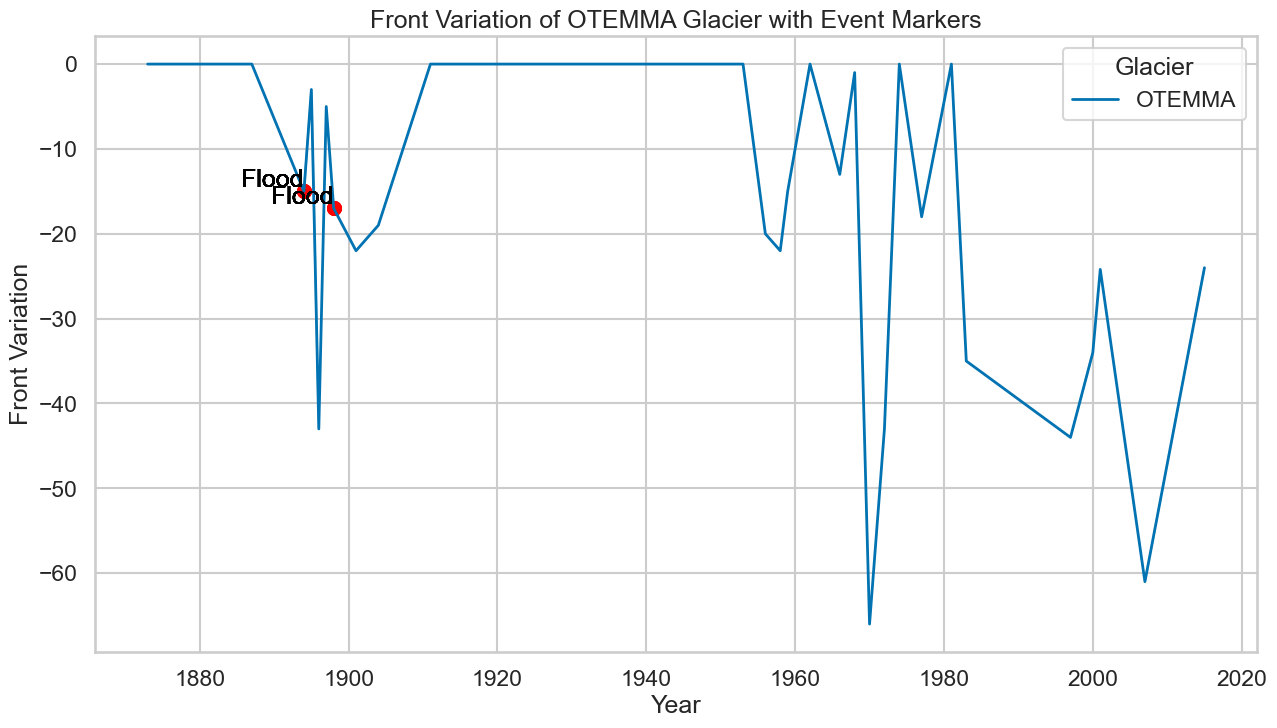

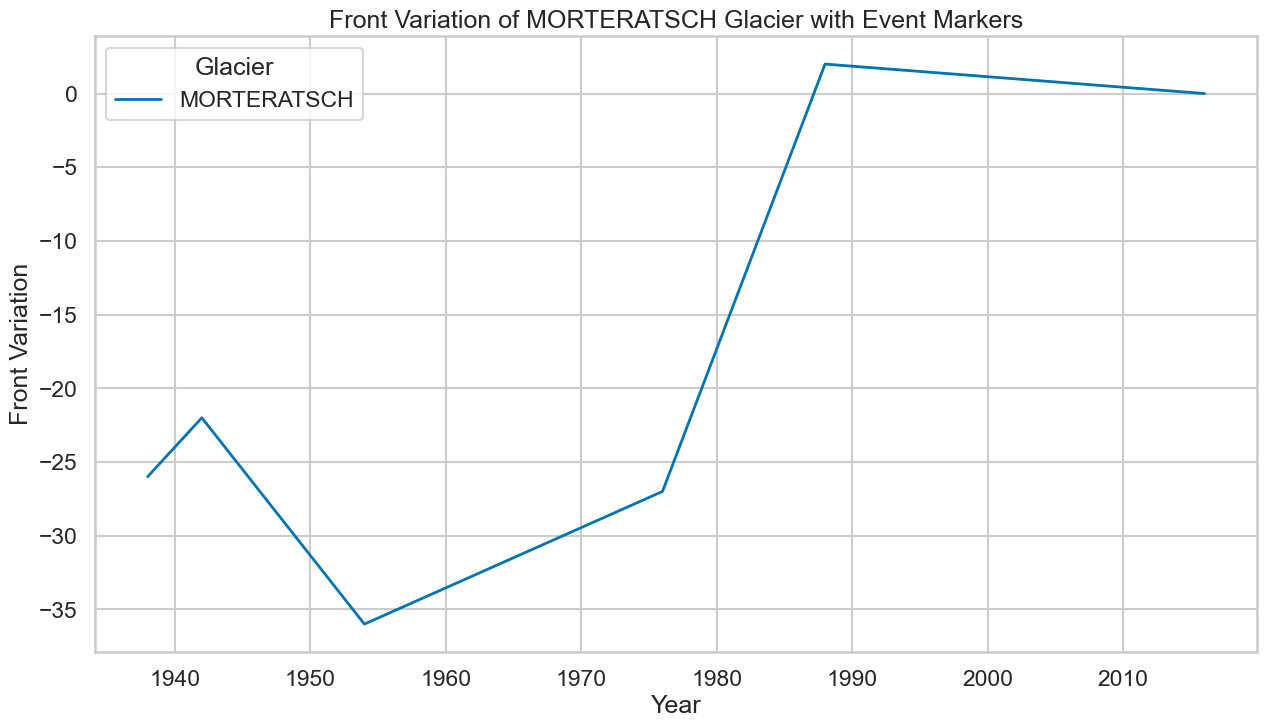

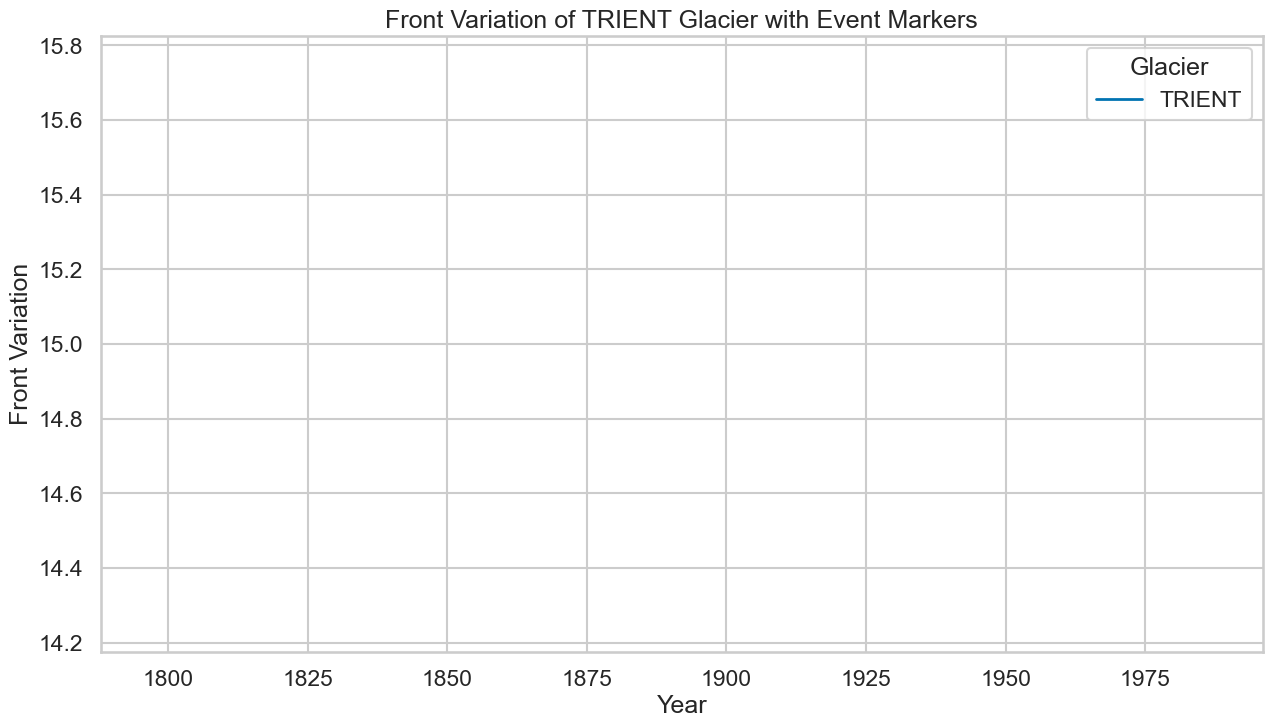

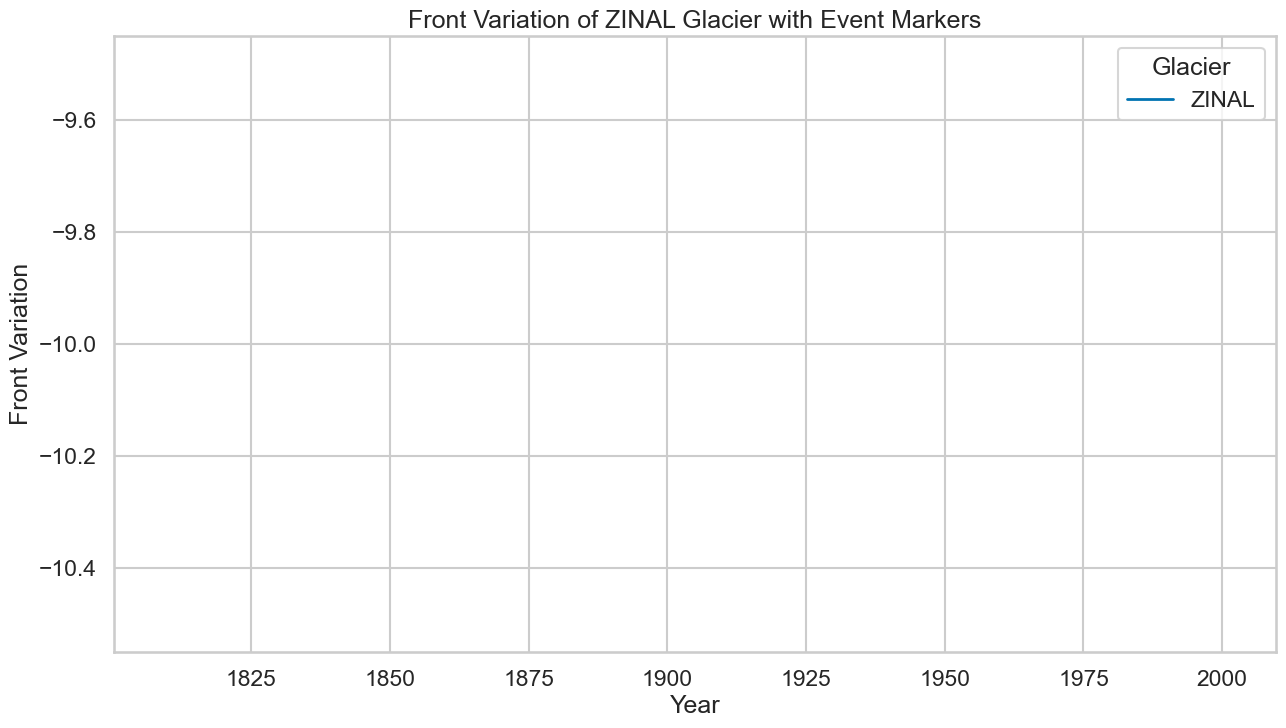

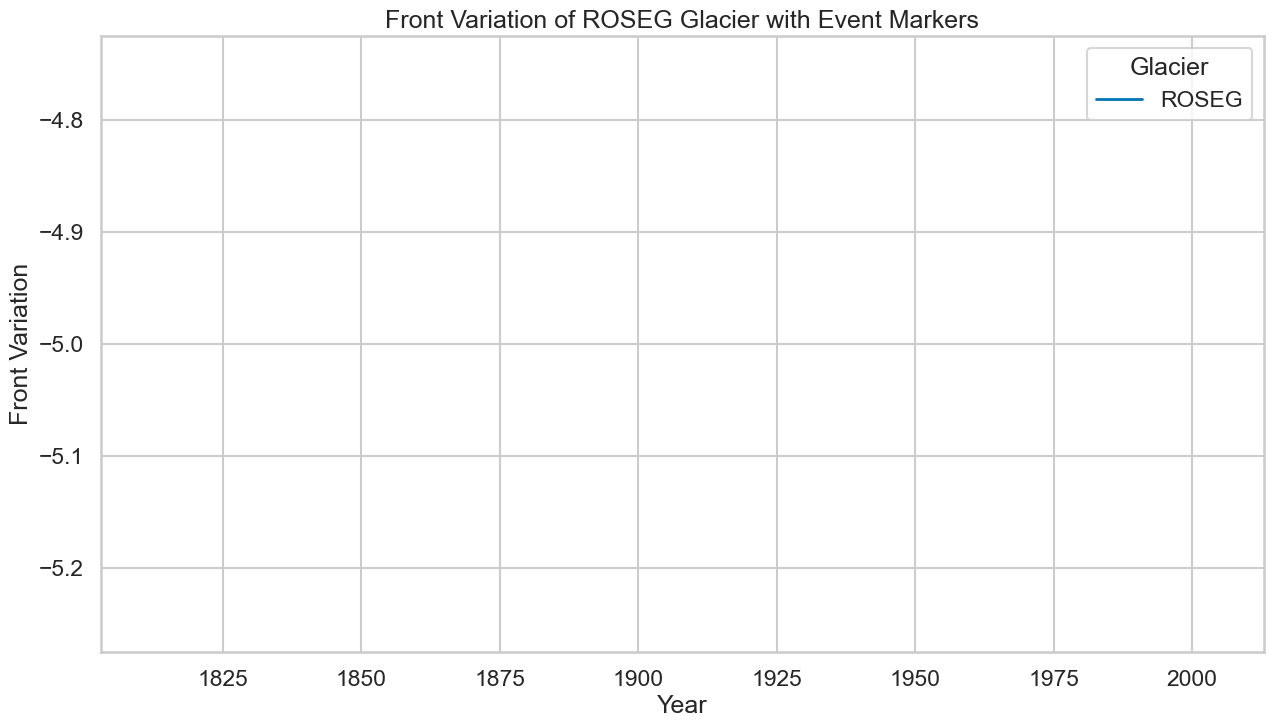

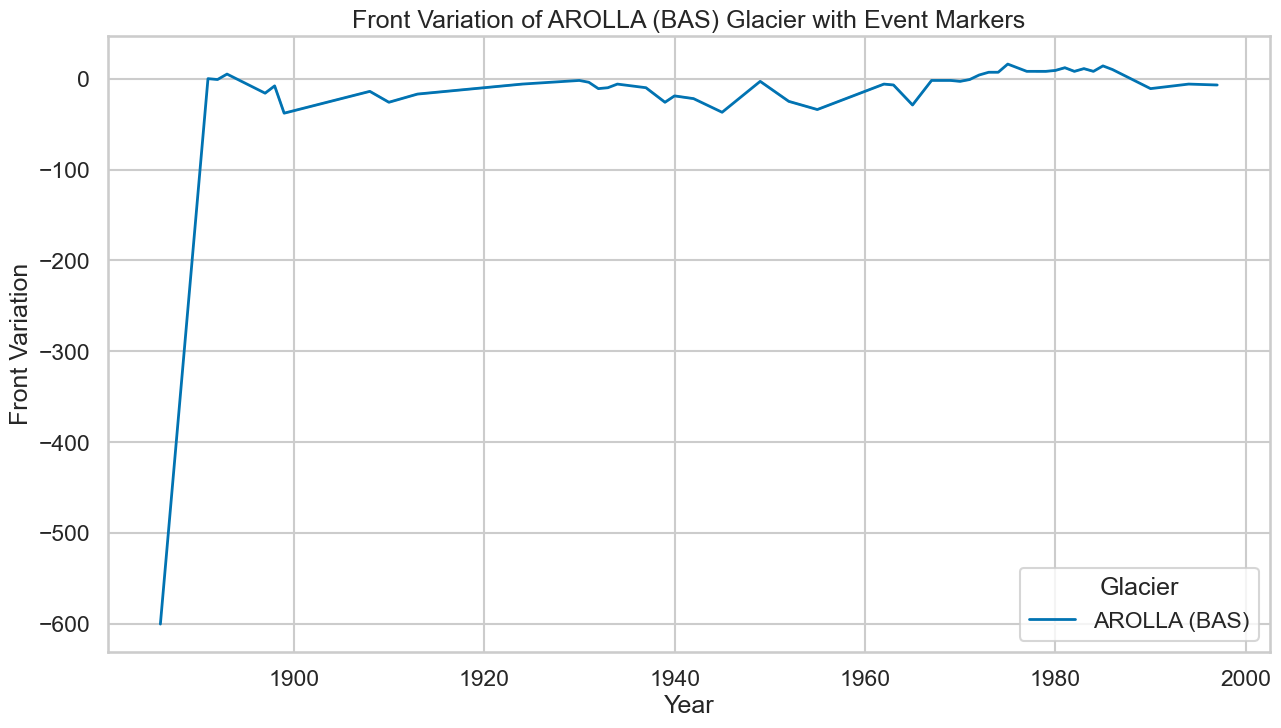

In [25]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(style="whitegrid", context="talk", font_scale=1.0)
sns.set_palette("colorblind")

for glacier_name in final_data['NAME'].unique():
    
    plt.figure(figsize=(15, 8))
    filtered_df = final_data[final_data['NAME'] == glacier_name]

    # Plotting the line for front variation
    sns.lineplot(x='Year', y='FRONT_VARIATION', data=filtered_df, linewidth=2, label=glacier_name)

    # Identifying the years with events for this glacier
    event_years = filtered_df[~filtered_df['EVENT_DATE'].isna()]

    # Plotting red points and event type labels for years with events
    for index, event_row in event_years.iterrows():
        year = event_row['Year']
        front_variation_year = event_row['FRONT_VARIATION']
        event_type = event_row['EVENT_TYPE']  # Assuming 'EVENT_TYPE' column has the event type

        # Plotting the red point
        plt.scatter(year, front_variation_year, color='red')

        # Adding the event type label
        plt.text(year, front_variation_year, event_type, color='black', ha='right', va='bottom')

    plt.title(f"Front Variation of {glacier_name} Glacier with Event Markers")
    plt.xlabel('Year')
    plt.ylabel('Front Variation')
    plt.legend(title='Glacier')
    plt.show()


In [26]:
final_data.columns

Index(['uid', 'language', 'title', 'size', 'country', 'newspaper', 'issue',
       'pages', 'nb_pages', 'year', 'is_on_front', 'date', 'persons_mentioned',
       'locations_mentioned', 'content', 'filename', 'NAME', 'Year',
       'POLITICAL_UNIT', 'WGMS_ID_x', 'FRONT_VARIATION', 'FRONT_VAR_UNC',
       'QUALITATIVE_VARIATION', 'SURVEY_DATE', 'SURVEY_PATFORM_METHOD',
       'REFERENCE_DATE', 'PUB_IN_FOG_x', 'SPONS_AGENCY', 'REMARKS_x',
       'Event_ID', 'WGMS_ID_y', 'EVENT_DATE', 'ET_SURGE', 'ET_CALVING',
       'ET_FLOOD', 'ET_AVALANCHE', 'ET_TECTONIC', 'ET_OTHER',
       'EVENT_DESCRIPTION', 'INVESTIGATOR', 'SPONSORING_AGENCY', 'REFERENCE',
       'REMARKS_y', 'PUB_IN_FOG_y', 'EVENT_TYPE'],
      dtype='object')

In [27]:
# import pandas as pd
# import seaborn as sns
# import matplotlib.pyplot as plt

# wgms_df = pd.DataFrame(wgms_dataframe)
# wgms_df2 = pd.DataFrame(wgms_dataframe2)

# # Fusion des deux DataFrames sur la colonne 'NAME'
# merged_df = pd.merge(wgms_df, wgms_df2, on='NAME', how='left')

# # selected_glaciers = ['RHONE', 'OBERER GRINDELWALD', 'UNTERER GRINDELWALD', 'ZMUTT', 'ALLALIN', 'GROSSER ALETSCH', 'OTEMMA', 'MORTERATSCH', 'TRIENT', 'ZINAL', 'ROSEG', 'AROLLA (BAS)']

# # Filtrage des glaciers dans la liste sélectionnée
# filtered_df = merged_df[merged_df['NAME'].isin(final_data.NAME.unique())]

# # Filtrage des points où les dates existe dans la deuxième DataFrame
# filtered_df = filtered_df[filtered_df['DATE'] != 'no date']

# plt.figure(figsize=(15, 8))
# sns.lineplot(x='Year', y='FRONT_VARIATION', data=wgms_df, linewidth=2, label='Original Data')
# sns.scatterplot(x='Year', y='FRONT_VARIATION', data=filtered_df, color='red', label='Modified Data')
# plt.title("Front variation avec points rouges pour les évenements")
# plt.legend()
# plt.show()

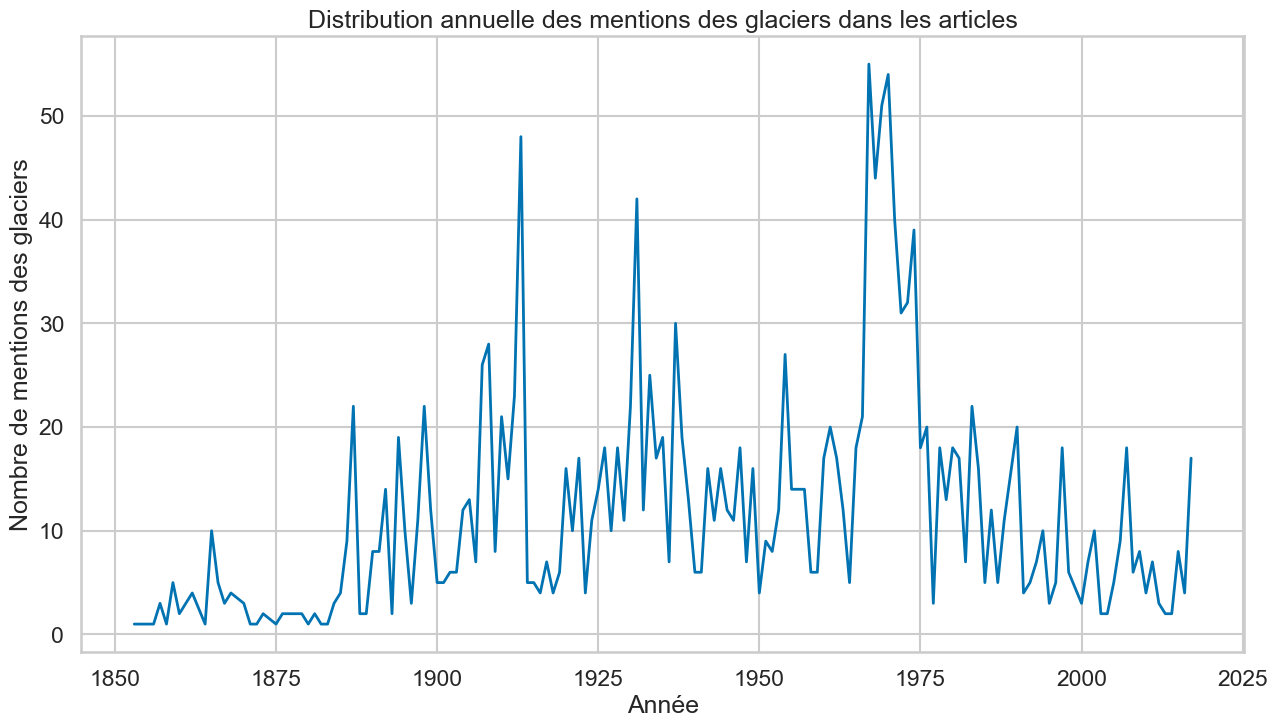

In [28]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

sns.set(style="whitegrid", context="talk", font_scale=1.)

# Group the data by 'year' and count the number of entries
data_sorted = final_data.groupby('year').size()

sns.set_palette("colorblind")

# Create the line plot with sorted data
plt.figure(figsize=(15, 8))
ax = sns.lineplot(data=data_sorted, linewidth=2)
ax.set_xlabel('Année')
ax.set_ylabel('Nombre de mentions des glaciers')
ax.set_title('Distribution annuelle des mentions des glaciers dans les articles')

plt.show()

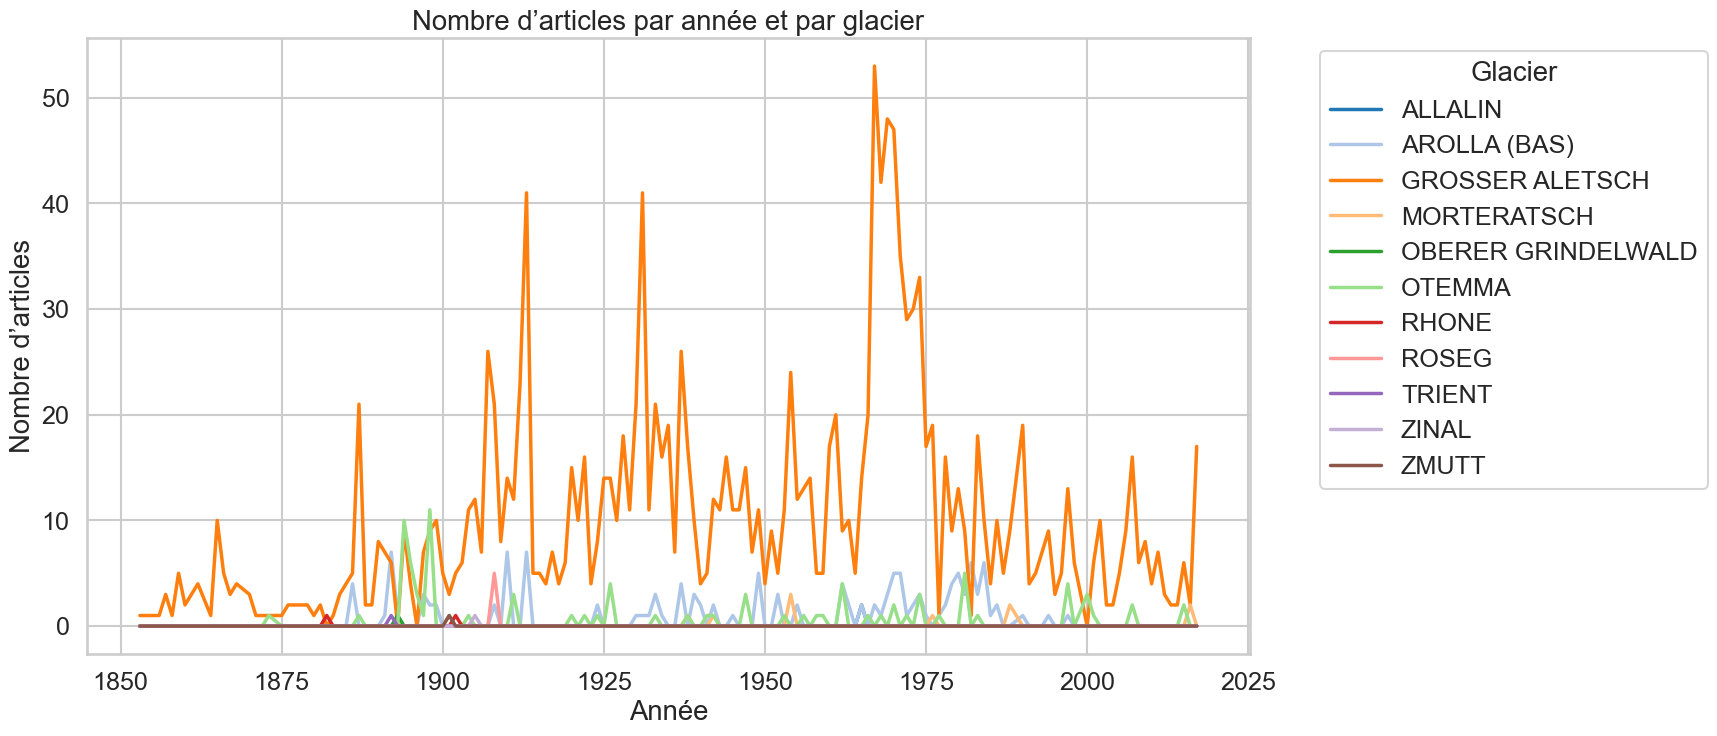

In [29]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

sns.set(style="whitegrid", context="talk", font_scale=1.1)

##no_glaciers = data['glacier'].unique()
no_glaciers = len(final_data['NAME'].unique())

# Group the data by 'year' and 'glacier' and count the number of articles
grouped_data = final_data.groupby(['year', 'NAME']).size().reset_index(name='number_of_articles')

# Pivot the data to get counts of articles per year for each glacier
pivot_data = grouped_data.pivot(index='year', columns='NAME', values='number_of_articles').fillna(0)

# Manually create a palette with 16 distinct colors
palette = sns.color_palette("tab20", n_colors=no_glaciers)

# Create the line plot for each glacier
plt.figure(figsize=(15, 8))
for i, glacier in enumerate(pivot_data.columns):
    sns.lineplot(data=pivot_data[glacier], label=glacier, color=palette[i % no_glaciers], linewidth=2.5)

plt.xlabel('Année')
plt.ylabel('Nombre d’articles')
plt.title('Nombre d’articles par année et par glacier')
plt.legend(title='Glacier', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.show()


During these years:  [] there are some events about RHONE


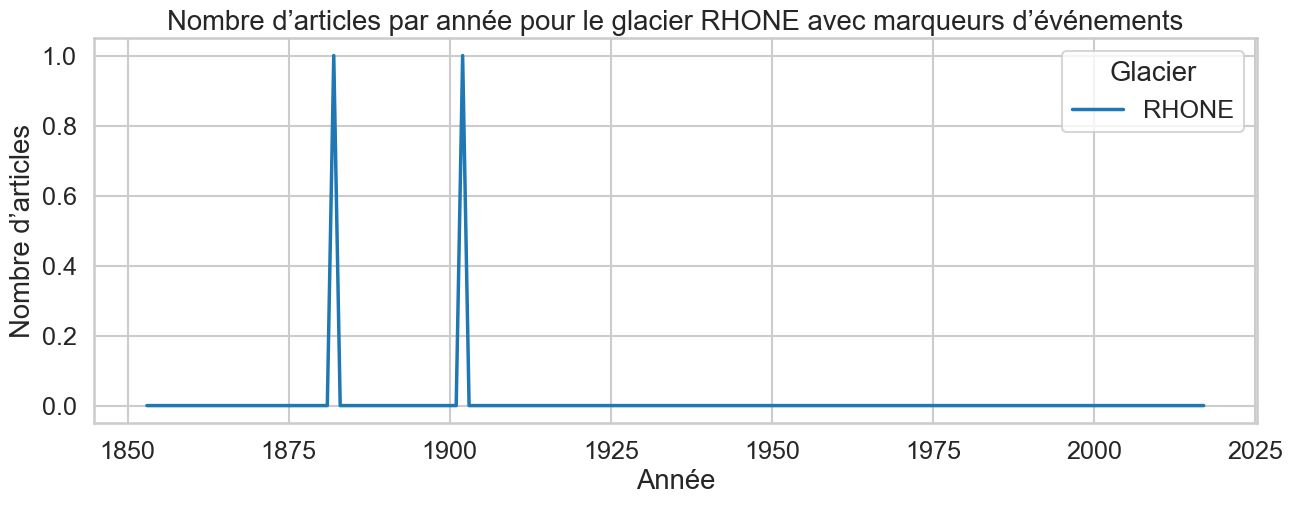

During these years:  [] there are some events about OBERER GRINDELWALD


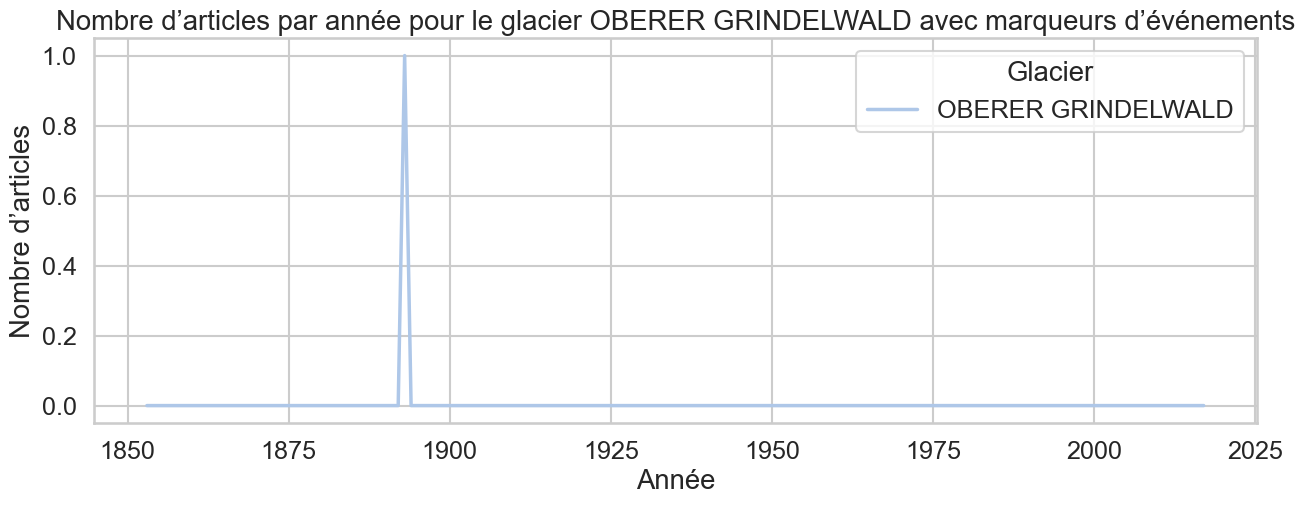

During these years:  [] there are some events about ZMUTT


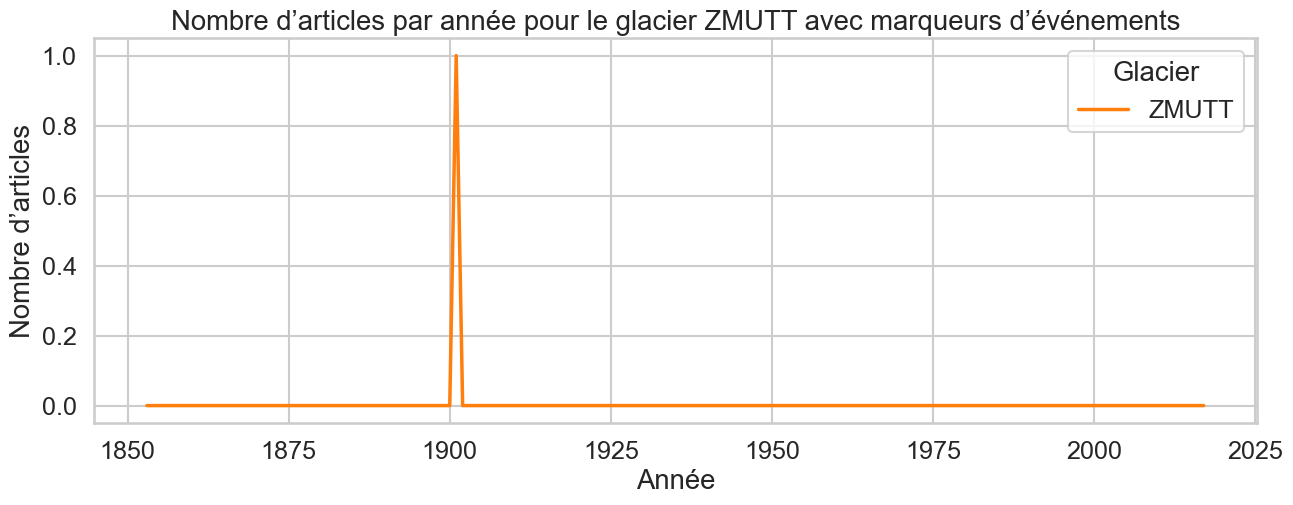

During these years:  [1965.] there are some events about ALLALIN


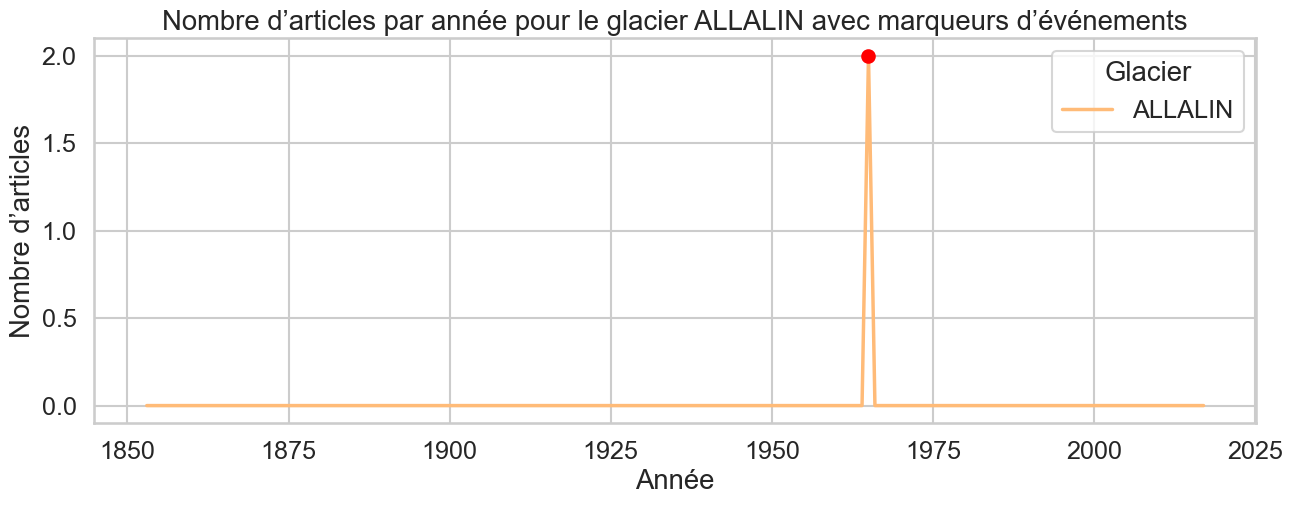

During these years:  [1995. 1872.] there are some events about GROSSER ALETSCH


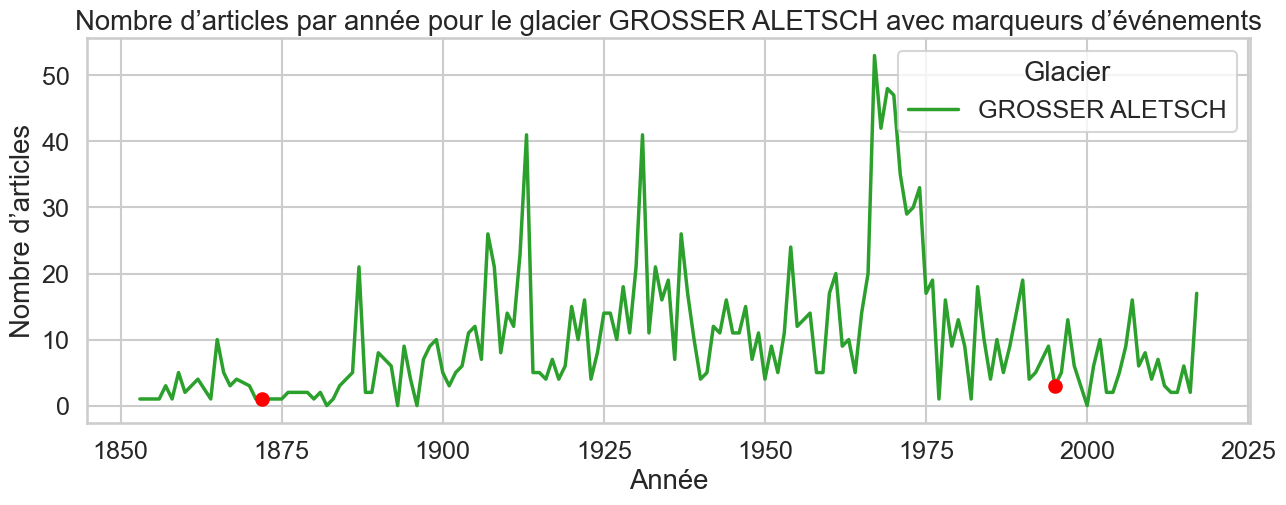

During these years:  [1898. 1894.] there are some events about OTEMMA


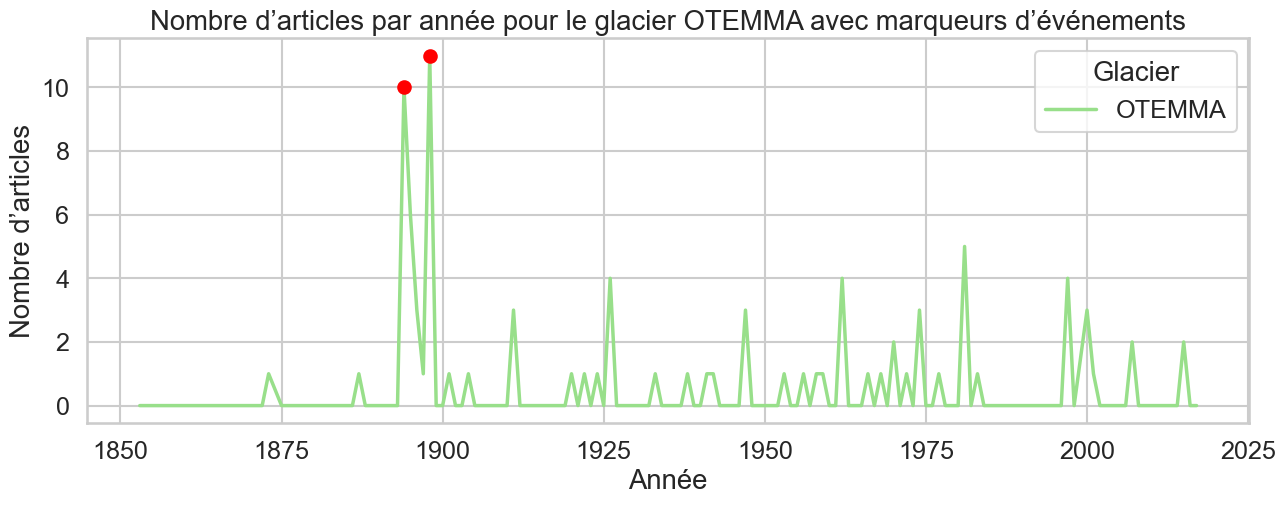

During these years:  [] there are some events about MORTERATSCH


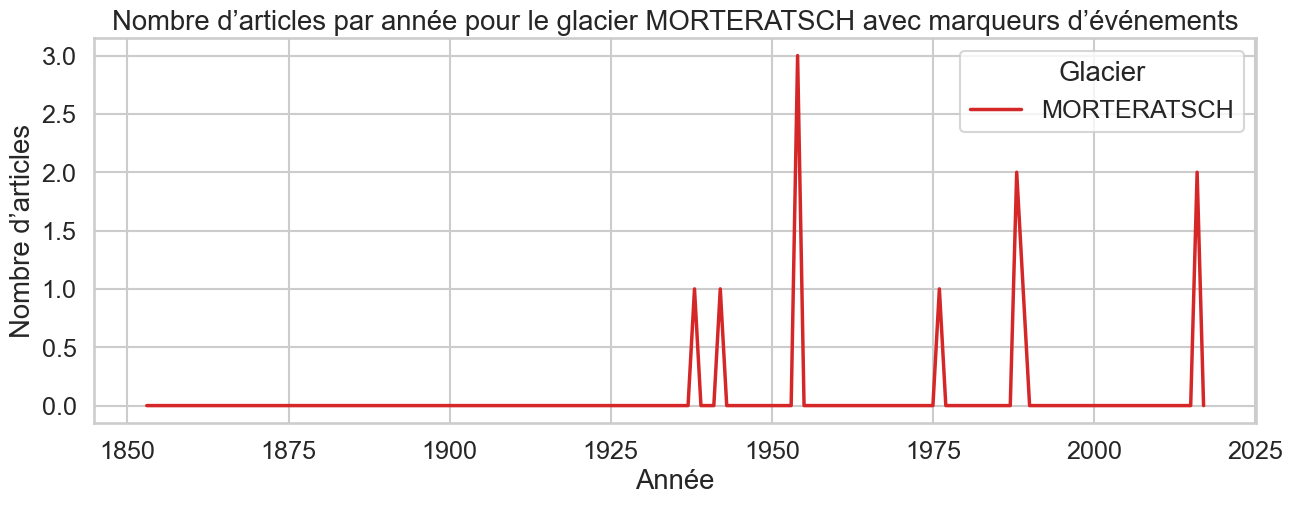

During these years:  [] there are some events about TRIENT


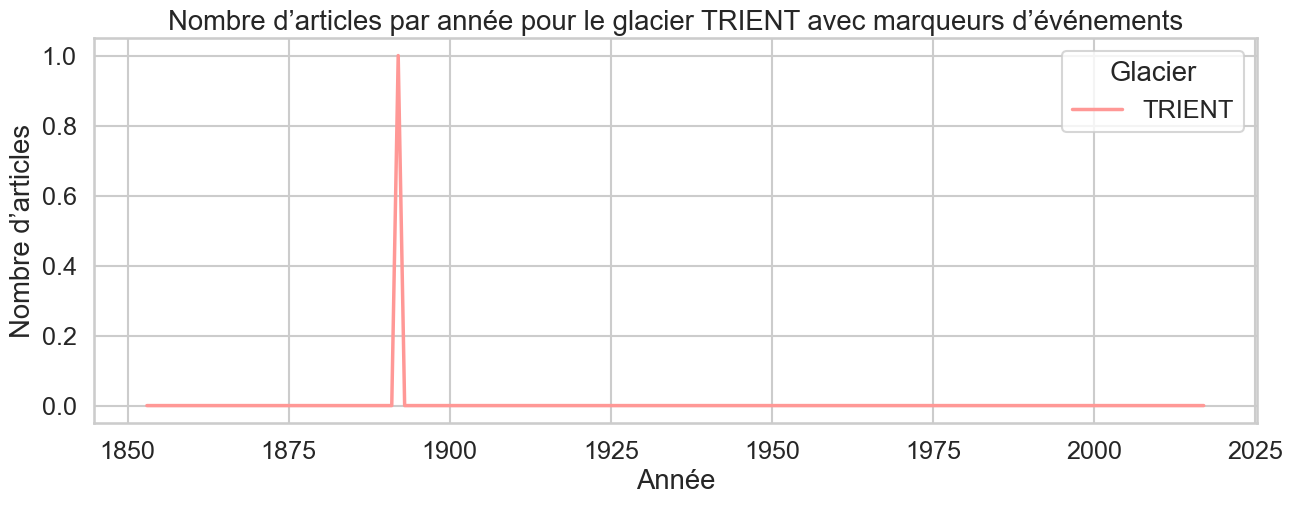

During these years:  [] there are some events about ZINAL


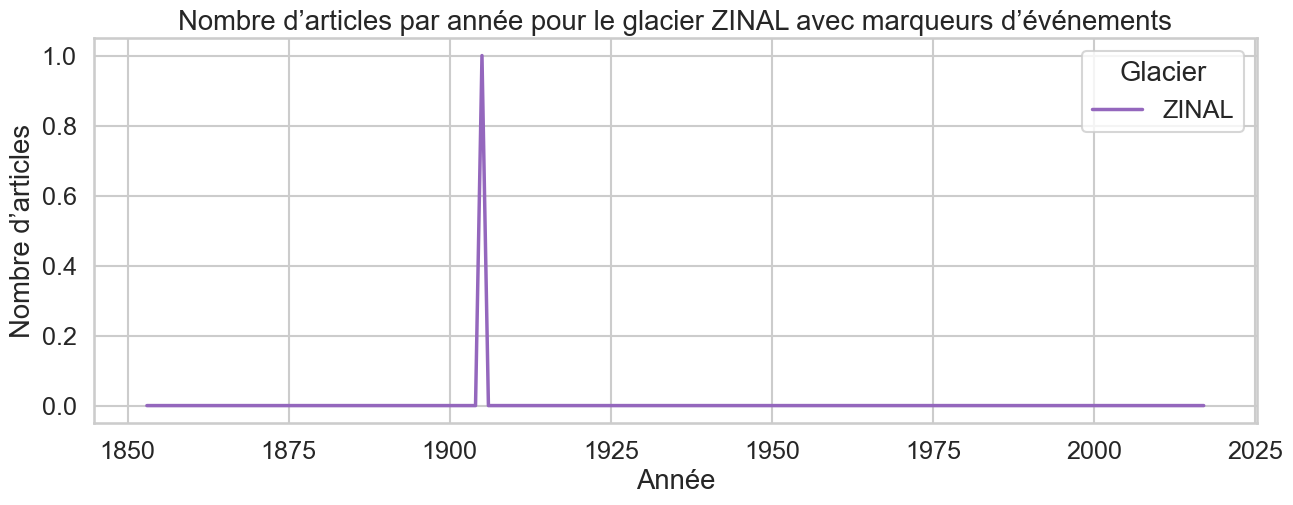

During these years:  [] there are some events about ROSEG


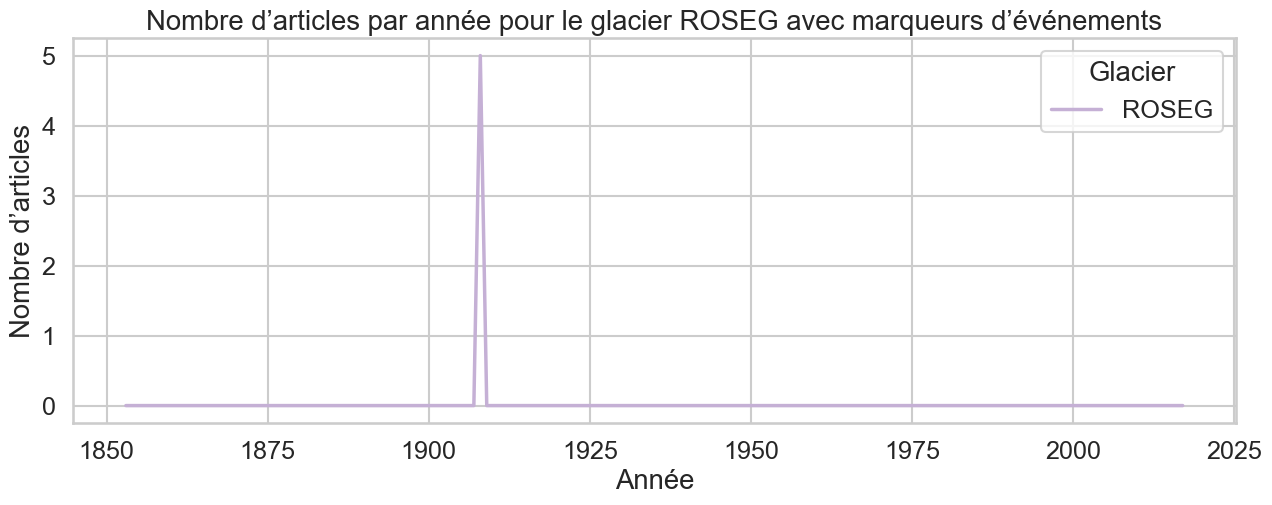

During these years:  [] there are some events about AROLLA (BAS)


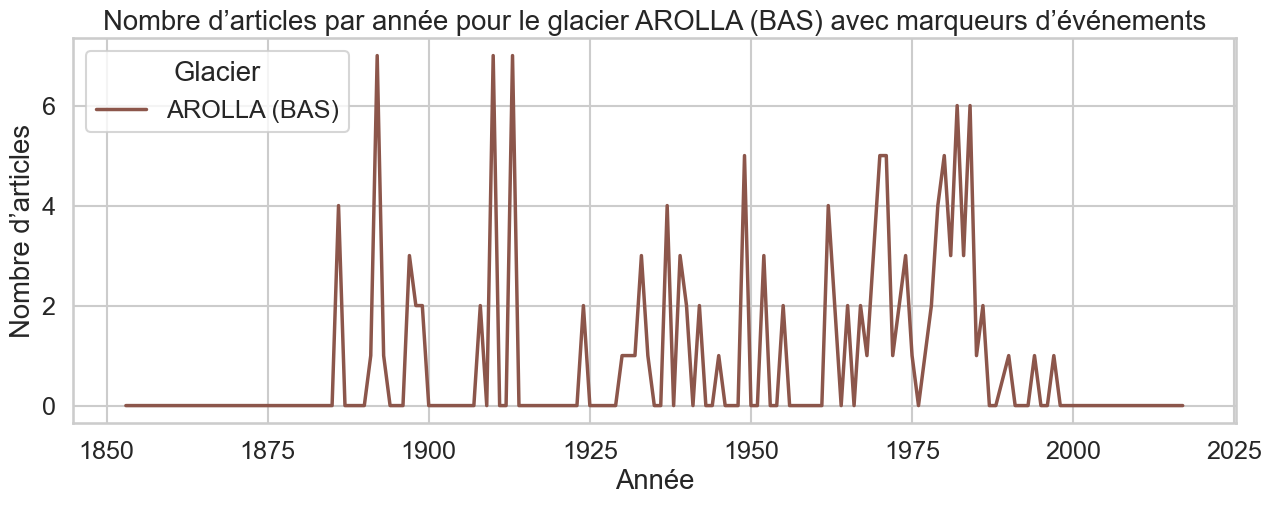

In [30]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

sns.set(style="whitegrid", context="talk", font_scale=1.1)

# Get the unique glaciers
unique_glaciers = final_data['NAME'].unique()
no_glaciers = len(unique_glaciers)

# Group the data by 'year' and 'NAME' and count the number of articles
grouped_data = final_data.groupby(['year', 'NAME']).size().reset_index(name='number_of_articles')

# Pivot the data to get counts of articles per year for each glacier
pivot_data = grouped_data.pivot(index='year', columns='NAME', values='number_of_articles').fillna(0)

# Manually create a palette with distinct colors
palette = sns.color_palette("tab20", n_colors=no_glaciers)

# Loop over each glacier to create individual plots
for i, glacier in enumerate(unique_glaciers):
    plt.figure(figsize=(15, 5))
    
    # Plotting the line for the number of articles
    sns.lineplot(data=pivot_data[glacier], label=glacier, color=palette[i % no_glaciers], linewidth=2.5)
    
    # Filter for this specific glacier and extract unique EVENT_DATEs
    glacier_events = final_data[(final_data['NAME'] == glacier) & ~final_data['EVENT_DATE'].isna()]['year'].unique()
    print('During these years: ', glacier_events, 'there are some events about', glacier)
    # Plotting red points for EVENT_DATEs
    for event_year in glacier_events:
        # Check if there are articles in the given year for this glacier
        if event_year in pivot_data.index:
            plt.scatter(event_year, pivot_data.loc[event_year, glacier], color='red', zorder=5)

    plt.xlabel('Année')
    plt.ylabel('Nombre d’articles')
    plt.title(f'Nombre d’articles par année pour le glacier {glacier} avec marqueurs d’événements')
    plt.legend(title='Glacier')
    plt.show()


In [31]:
final_data.columns

Index(['uid', 'language', 'title', 'size', 'country', 'newspaper', 'issue',
       'pages', 'nb_pages', 'year', 'is_on_front', 'date', 'persons_mentioned',
       'locations_mentioned', 'content', 'filename', 'NAME', 'Year',
       'POLITICAL_UNIT', 'WGMS_ID_x', 'FRONT_VARIATION', 'FRONT_VAR_UNC',
       'QUALITATIVE_VARIATION', 'SURVEY_DATE', 'SURVEY_PATFORM_METHOD',
       'REFERENCE_DATE', 'PUB_IN_FOG_x', 'SPONS_AGENCY', 'REMARKS_x',
       'Event_ID', 'WGMS_ID_y', 'EVENT_DATE', 'ET_SURGE', 'ET_CALVING',
       'ET_FLOOD', 'ET_AVALANCHE', 'ET_TECTONIC', 'ET_OTHER',
       'EVENT_DESCRIPTION', 'INVESTIGATOR', 'SPONSORING_AGENCY', 'REFERENCE',
       'REMARKS_y', 'PUB_IN_FOG_y', 'EVENT_TYPE'],
      dtype='object')

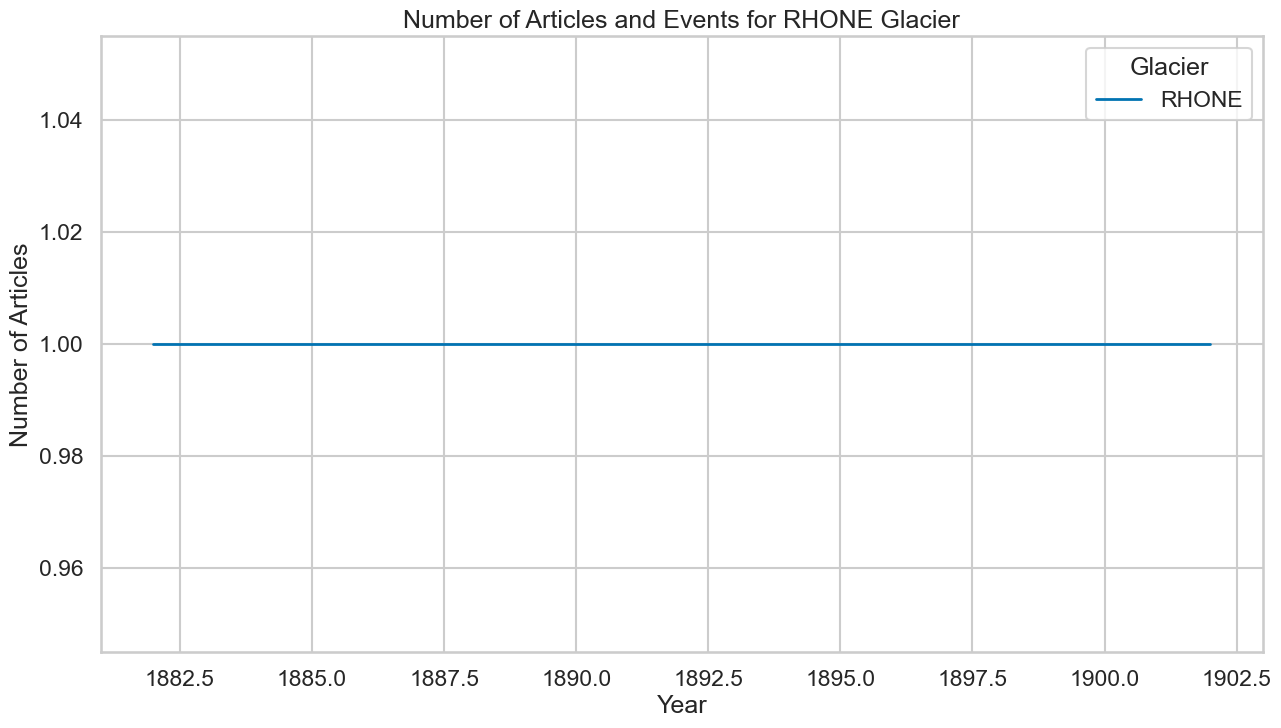

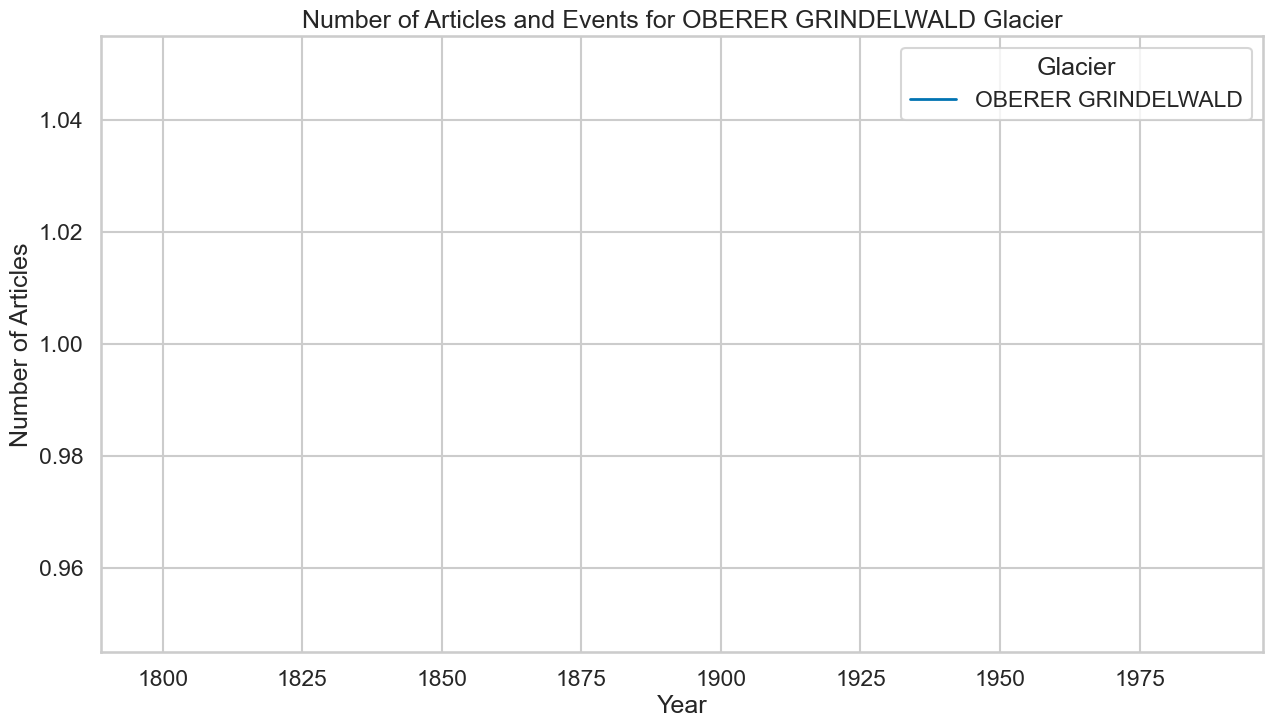

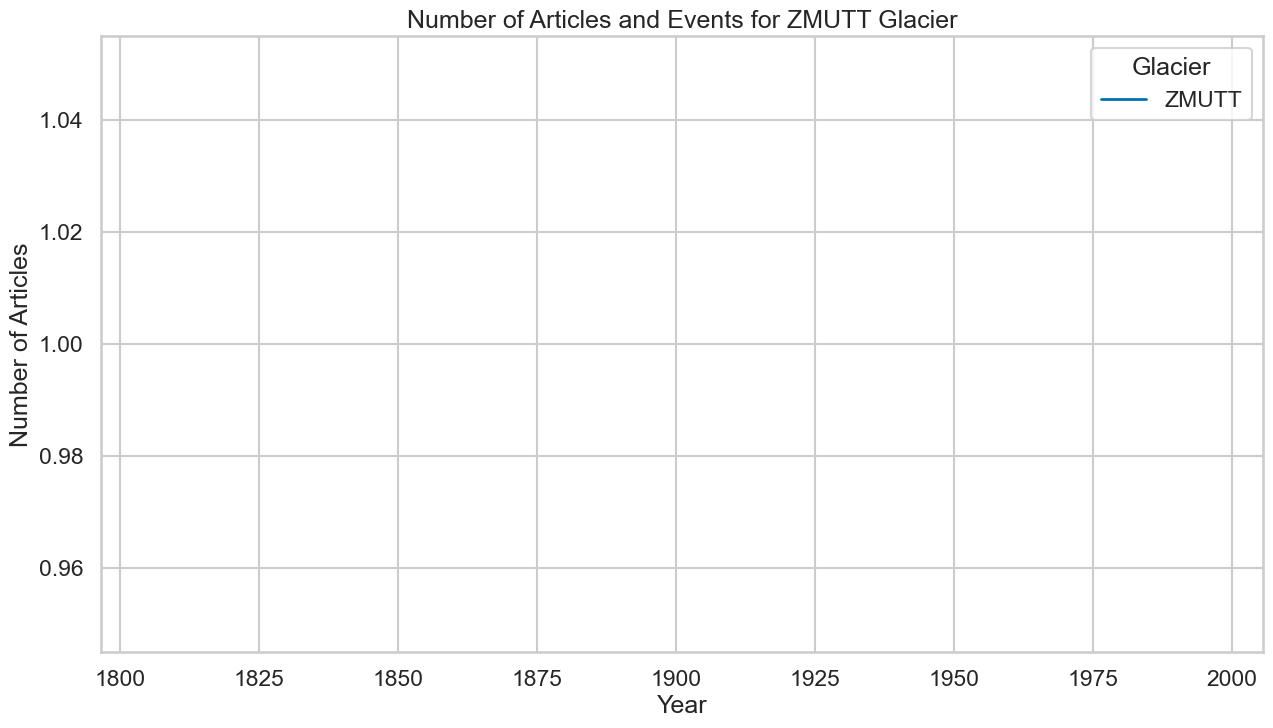

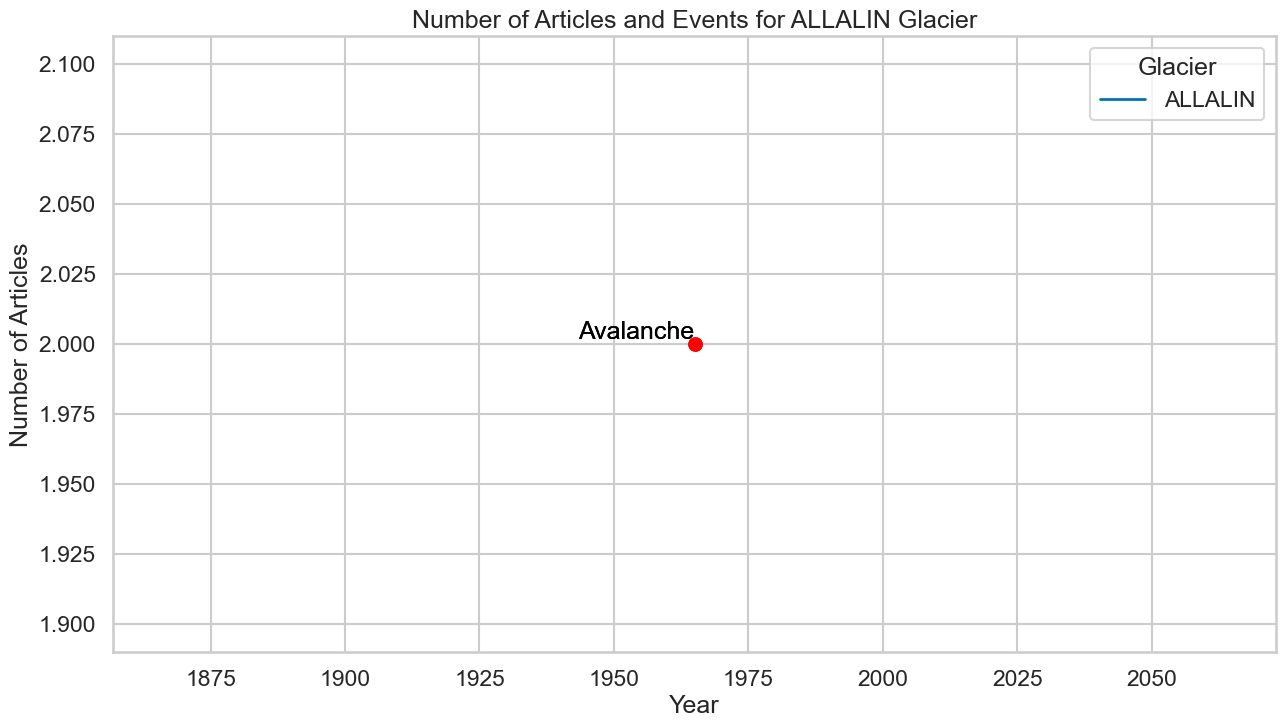

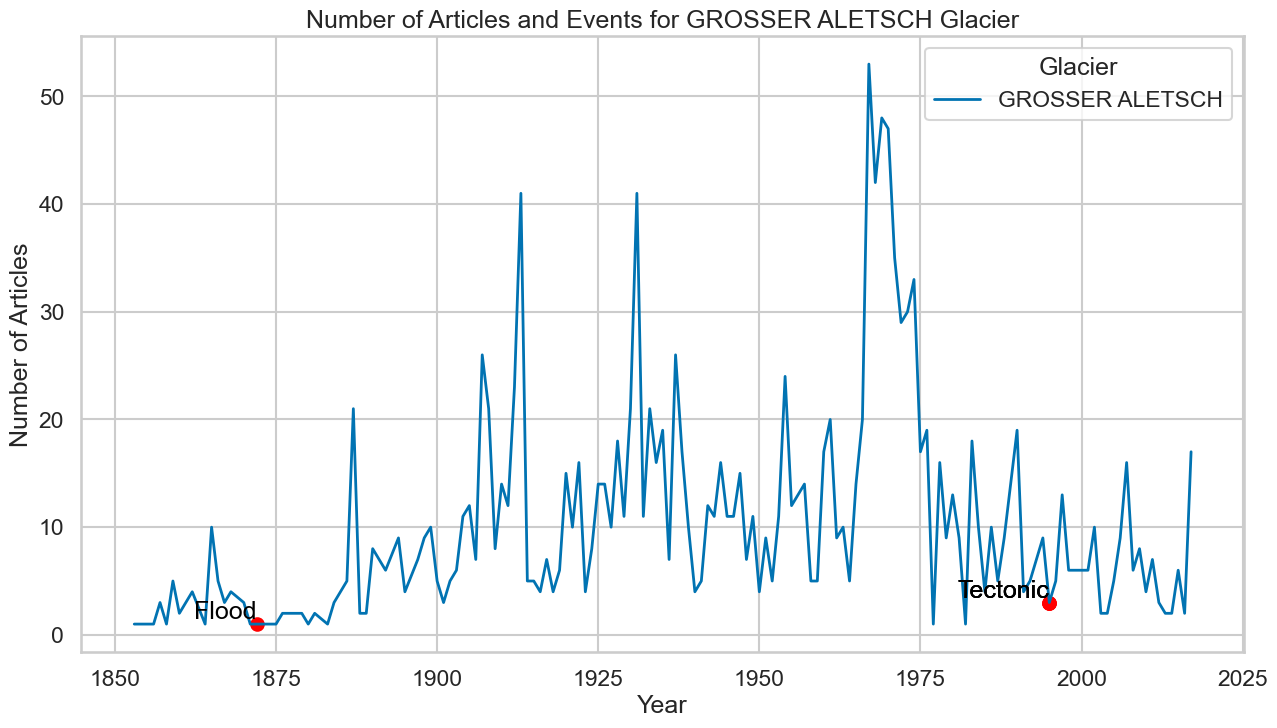

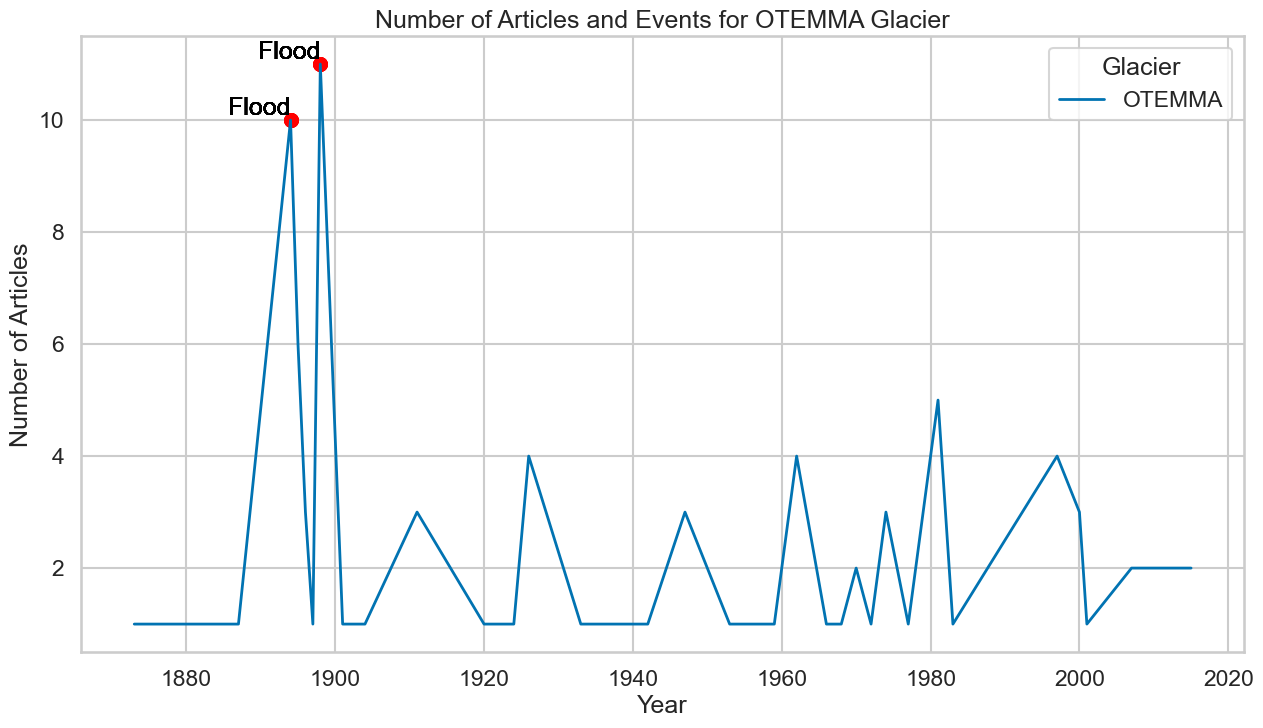

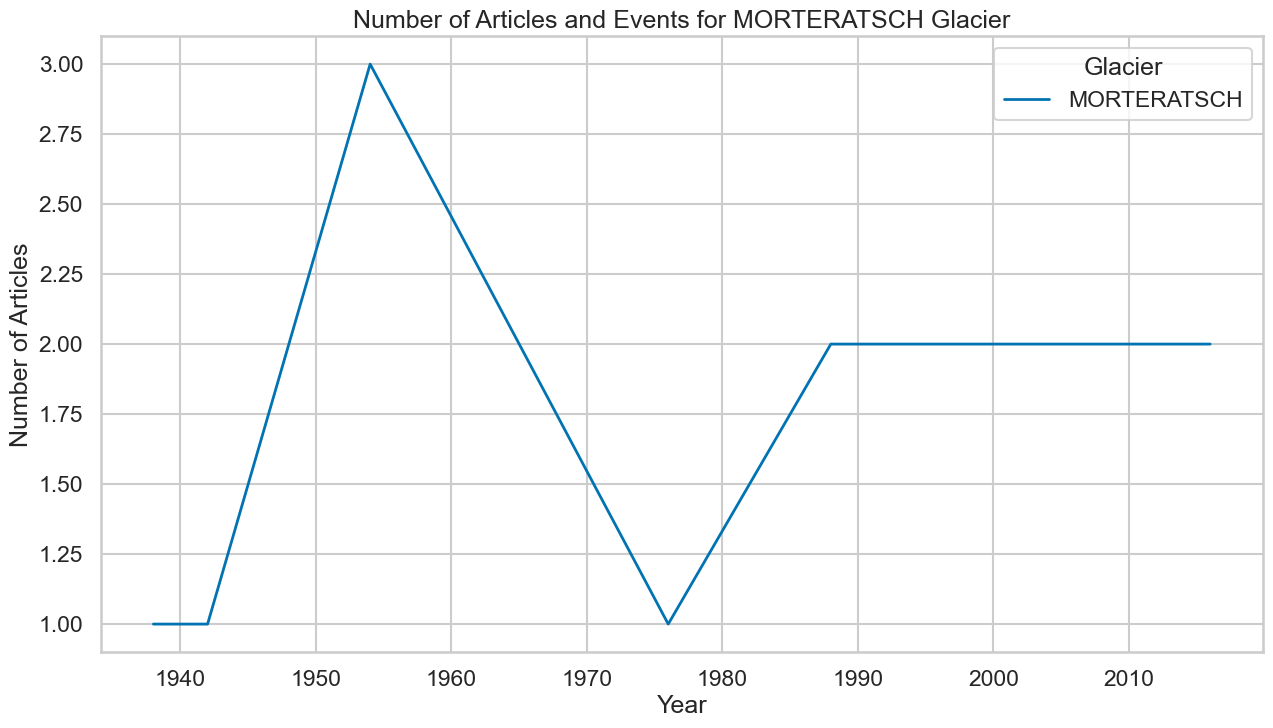

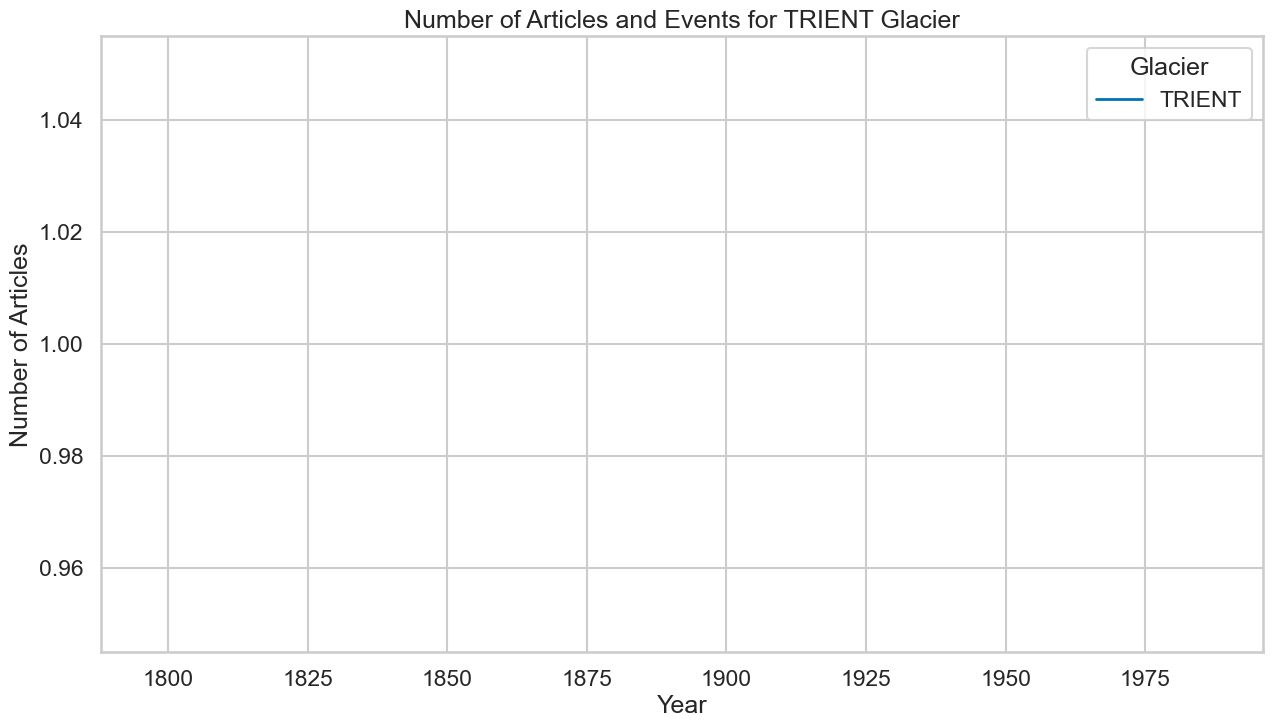

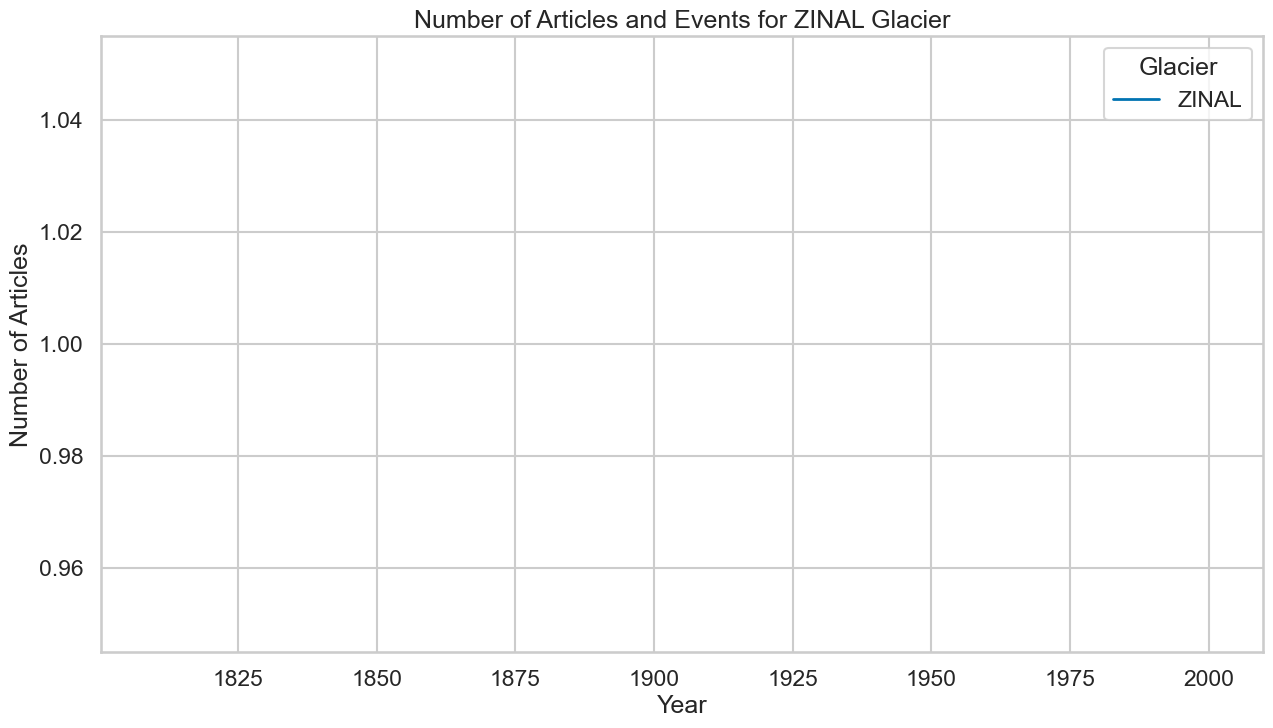

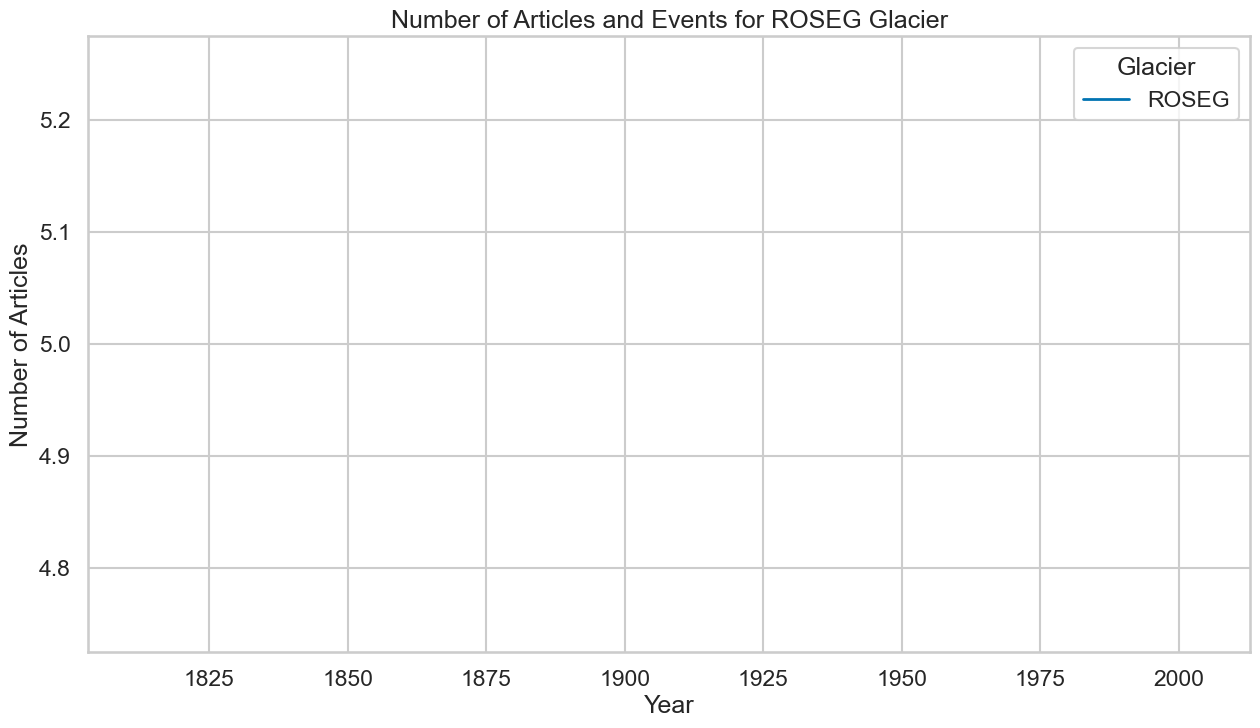

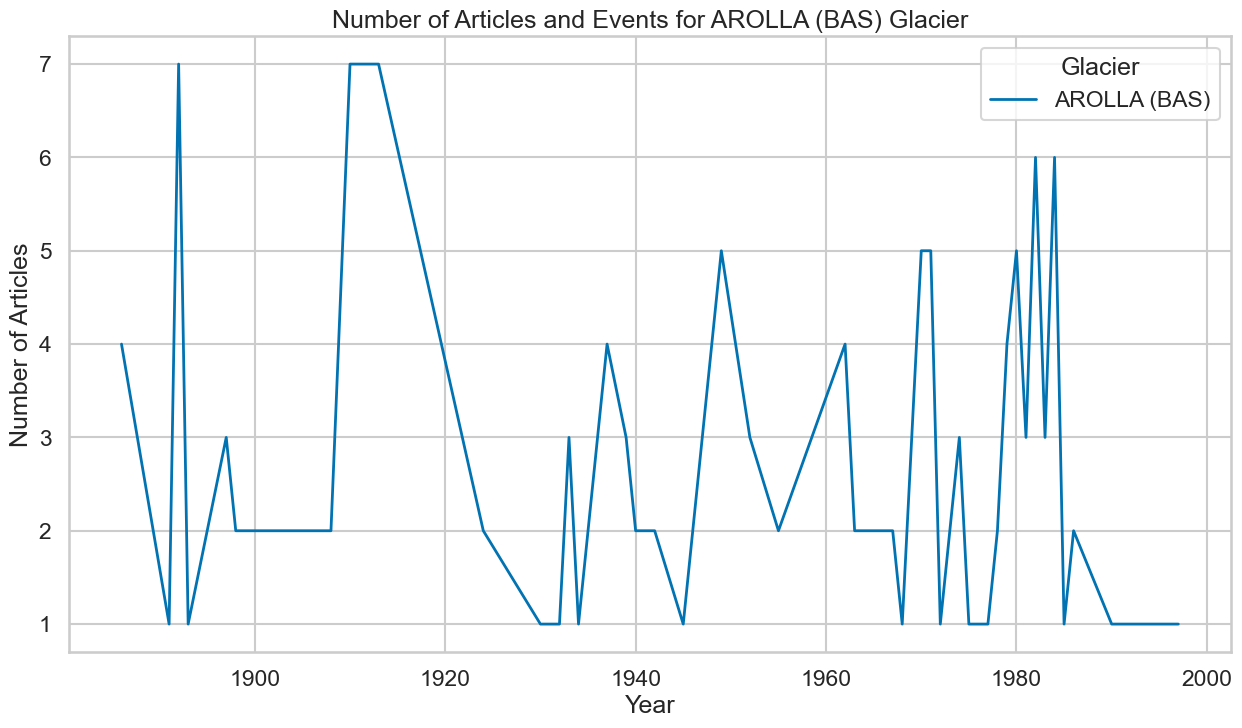

In [32]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(style="whitegrid", context="talk", font_scale=1.0)
sns.set_palette("colorblind")

for glacier_name in final_data['NAME'].unique():
    plt.figure(figsize=(15, 8))
    
    # Filter the data for this specific glacier
    filtered_df = final_data[final_data['NAME'] == glacier_name]

    # Group data by year and count the number of articles
    articles_per_year = filtered_df.groupby('Year').size()

    # Plotting the line for number of articles
    sns.lineplot(x=articles_per_year.index, y=articles_per_year.values, linewidth=2, label=glacier_name)

    # Identifying the years with events for this glacier
    event_years = filtered_df[~filtered_df['EVENT_DATE'].isna()]

    # Plotting markers for years with events
    for index, event_row in event_years.iterrows():
        year = event_row['Year']
        num_articles = articles_per_year.get(year, 0)
        event_type = event_row['EVENT_TYPE']

        # Plotting the marker
        plt.scatter(year, num_articles, color='red')

        # Adding the event type label
        plt.text(year, num_articles, event_type, color='black', ha='right', va='bottom')

    plt.title(f"Number of Articles and Events for {glacier_name} Glacier")
    plt.xlabel('Year')
    plt.ylabel('Number of Articles')
    plt.legend(title='Glacier')
    plt.show()


In [33]:
# Loop over each unique glacier
for glacier in final_data['NAME'].unique():
    # Filter the data for the specific glacier
    glacier_data = final_data[final_data['NAME'] == glacier]
    
    # Filter for non-null event dates
    event_data = glacier_data[~glacier_data['EVENT_DATE'].isna()]

    # Print the glacier name
    print(f"Events for Glacier: {glacier}")

    # Loop through each event and print the reference
    for index, row in event_data.iterrows():
        print(f"  Event Year: {row['Year']}, Reference: {row['REFERENCE']}")
    
    # Loop through each event and print the details
    for index, row in event_data.iterrows():
        print(f"  Event Type: {row['EVENT_TYPE']}")
        print(f"  Event Description: {row['EVENT_DESCRIPTION']}")
        print(f"  Event Year: {row['Year']}, Reference: {row['REFERENCE']}")
        print(f"  Newspaper: {row['newspaper']}, Country: {row['country']}")
         # Check if 'content' is non-null and print it
        if pd.notna(row['content']):
            print(f"  Content: {row['content']}...")  # Print first 500 characters of content
        else:
            print("  Content: Not available")

        print("\n")  # Add a newline for better readability
    
    
    print('---' * 50)
    print("\n")  # Add a newline for better readability


Events for Glacier: RHONE
------------------------------------------------------------------------------------------------------------------------------------------------------


Events for Glacier: OBERER GRINDELWALD
------------------------------------------------------------------------------------------------------------------------------------------------------


Events for Glacier: ZMUTT
------------------------------------------------------------------------------------------------------------------------------------------------------


Events for Glacier: ALLALIN
  Event Year: 1965, Reference: www.glacierhazards.ch http://glaciology.ethz.ch/inventar/download/allalin.pdf
  Event Year: 1965, Reference: www.glacierhazards.ch http://glaciology.ethz.ch/inventar/download/allalin.pdf
  Event Type: Avalanche
  Event Description: On August 30, 1965, an ice avalanche of 2 million m3 broke off at the terminus area of Allalin Glacier and fell down a rock slope towards the Mattmark dam cons

In [34]:
final_data.columns

Index(['uid', 'language', 'title', 'size', 'country', 'newspaper', 'issue',
       'pages', 'nb_pages', 'year', 'is_on_front', 'date', 'persons_mentioned',
       'locations_mentioned', 'content', 'filename', 'NAME', 'Year',
       'POLITICAL_UNIT', 'WGMS_ID_x', 'FRONT_VARIATION', 'FRONT_VAR_UNC',
       'QUALITATIVE_VARIATION', 'SURVEY_DATE', 'SURVEY_PATFORM_METHOD',
       'REFERENCE_DATE', 'PUB_IN_FOG_x', 'SPONS_AGENCY', 'REMARKS_x',
       'Event_ID', 'WGMS_ID_y', 'EVENT_DATE', 'ET_SURGE', 'ET_CALVING',
       'ET_FLOOD', 'ET_AVALANCHE', 'ET_TECTONIC', 'ET_OTHER',
       'EVENT_DESCRIPTION', 'INVESTIGATOR', 'SPONSORING_AGENCY', 'REFERENCE',
       'REMARKS_y', 'PUB_IN_FOG_y', 'EVENT_TYPE'],
      dtype='object')

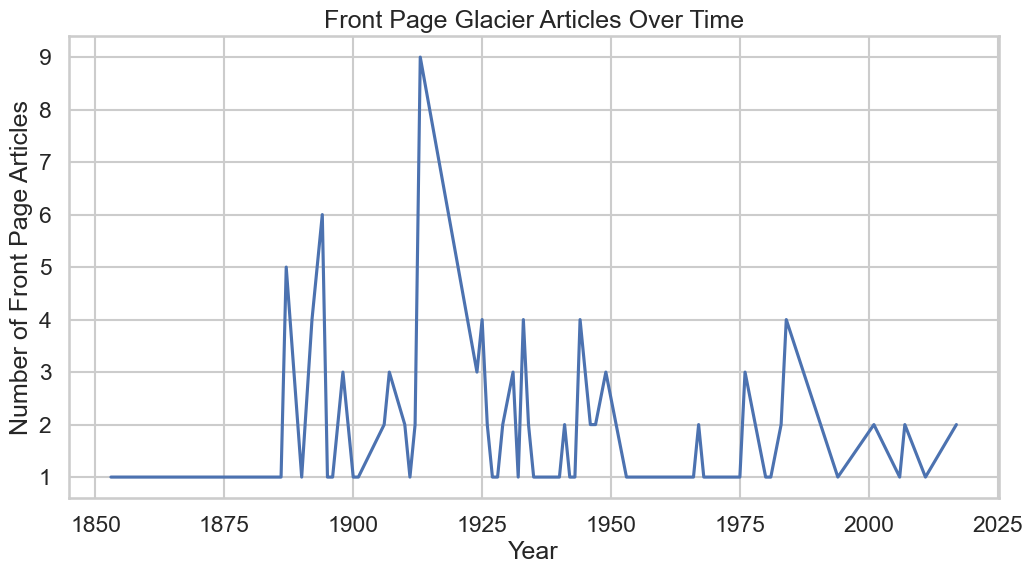

In [35]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid", context="talk", font_scale=1)

# Filter to include only front-page articles
filtered_df = final_data[~final_data['content'].isna()]
front_page_articles = filtered_df[filtered_df['is_on_front']]

# Group by year and count
front_page_counts = front_page_articles.groupby('year').size()

# Plot
plt.figure(figsize=(12, 6))
sns.lineplot(data=front_page_counts)
plt.title('Front Page Glacier Articles Over Time')
plt.xlabel('Year')
plt.ylabel('Number of Front Page Articles')
plt.show()

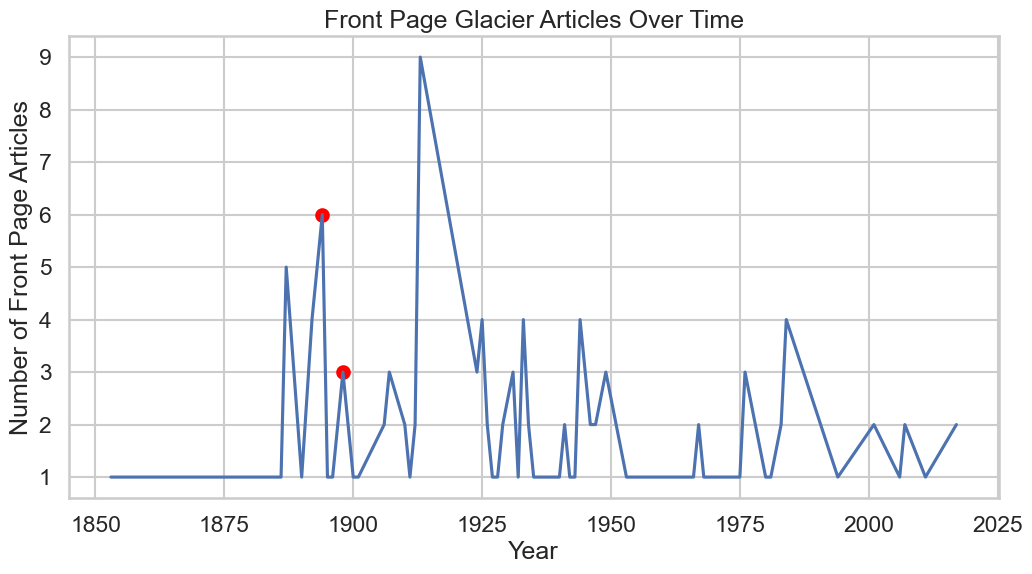

In [36]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid", context="talk", font_scale=1)

# Filter to include only front-page articles and non-null content
filtered_df = final_data[~final_data['content'].isna()]
front_page_articles = filtered_df[filtered_df['is_on_front']]

# Group by year and count
front_page_counts = front_page_articles.groupby('year').size()

# Plotting the line for the number of front-page articles
plt.figure(figsize=(12, 6))
sns.lineplot(data=front_page_counts)
plt.title('Front Page Glacier Articles Over Time')

# Identifying the years with events and plotting them
event_years = filtered_df[~filtered_df['EVENT_DATE'].isna()]['year'].unique()
for year in event_years:
    # Check if the year is in the front_page_counts
    if year in front_page_counts.index:
        plt.scatter(year, front_page_counts[year], color='red')

plt.xlabel('Year')
plt.ylabel('Number of Front Page Articles')
plt.show()


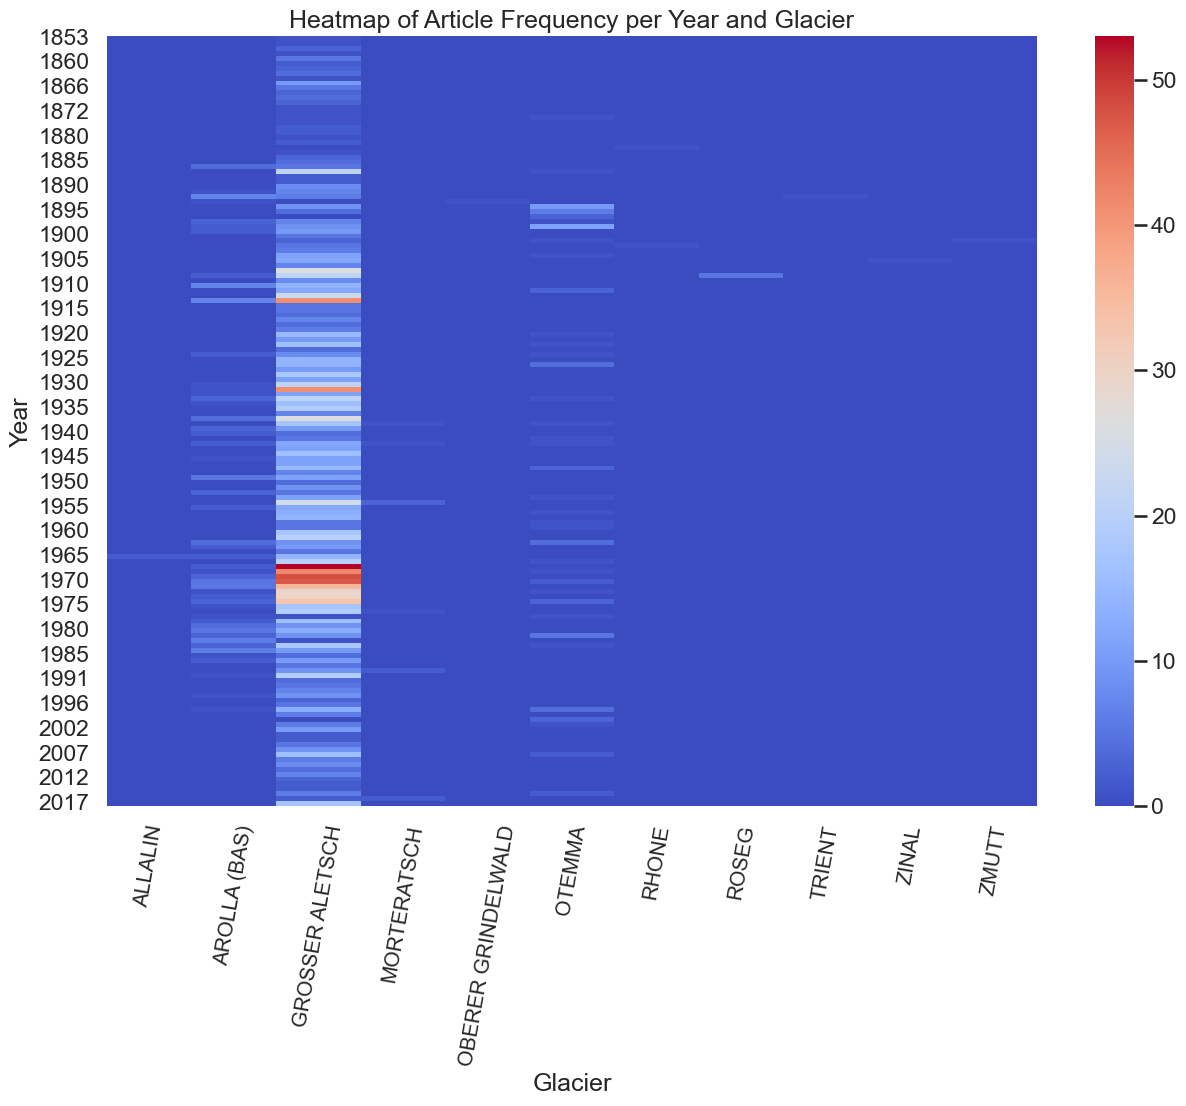

In [37]:
# Group by year and glacier, then count occurrences

filtered_df = final_data[~final_data['content'].isna()]

article_counts = filtered_df.groupby(['Year', 'NAME']).size().reset_index(name='count')

# Pivot for heatmap
pivot_data = article_counts.pivot(index='Year', columns='NAME', values='count').fillna(0)

# Plot
plt.figure(figsize=(15, 10))
sns.heatmap(pivot_data, annot=False, cmap='coolwarm')
plt.title('Heatmap of Article Frequency per Year and Glacier')
plt.xlabel('Glacier')
plt.ylabel('Year')
plt.xticks(rotation=80, fontsize=15)
plt.show()


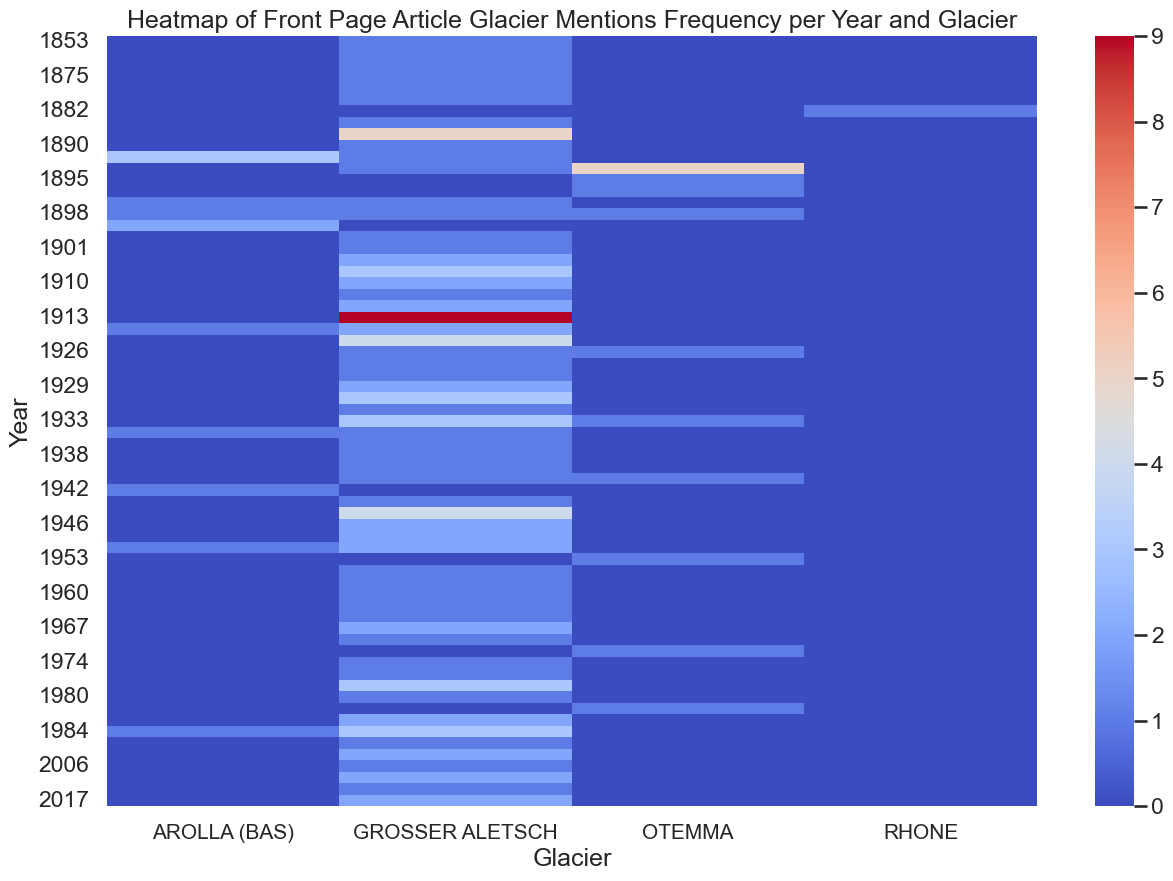

In [38]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Filter to include only front-page articles
front_page_articles = final_data[final_data['is_on_front'] == True]

# Group by year and glacier, then count occurrences
front_page_article_counts = front_page_articles.groupby(['Year', 'NAME']).size().reset_index(name='front_page_count')

# Pivot for heatmap
pivot_data = front_page_article_counts.pivot(index='Year', columns='NAME', values='front_page_count').fillna(0)

# Plot
plt.figure(figsize=(15, 10))
sns.heatmap(pivot_data, annot=False, cmap='coolwarm')
plt.title('Heatmap of Front Page Article Glacier Mentions Frequency per Year and Glacier')
plt.xlabel('Glacier')
plt.ylabel('Year')
plt.xticks(rotation=0, fontsize=15)
plt.show()


### What happened in 1913 to Aletsch Glacier (it was on front page many times)?

In [39]:
# Filter for Aletsch Glacier and front-page articles
aletsch_articles = final_data[(final_data['NAME'] == 'GROSSER ALETSCH') & (data['is_on_front'] == True)]

# Find the year(s) with the maximum number of front-page mentions
max_mentions_year = aletsch_articles['Year'].value_counts().idxmax()

# Filter articles from that year
max_mentions_articles = aletsch_articles[aletsch_articles['Year'] == max_mentions_year]

# Display some articles - you can adjust the number of articles to display
print(max_mentions_articles[['title', 'date', 'content', 'EVENT_TYPE']].head())


                      title                  date  \
166                     NaN  1912-06-08T00:00:00Z   
172        Dans les Santons  1912-02-13T00:00:00Z   
173         Lettre de Berne  1912-02-23T00:00:00Z   
174  §épêches du 23 iuillet  1912-07-23T00:00:00Z   
175       Dans les (Santons  1912-08-07T00:00:00Z   

                                               content EVENT_TYPE  
166  HOTEL-PENSION BEL-ALP Alt. 2180 m. A 4 h. de l...        NaN  
172  Dans les Santons Le chemin de fer de la Jungfr...        NaN  
173  Lettre de Berne Oe notre correspondant particu...        NaN  
174  § épêches du 23 iuillet 'Agence télégraphique ...        NaN  
175  Dans les (Santons Un chemin de fer de l'Aletsc...        NaN  


/var/folders/_3/vwbs1mlx70s08x_qwnrmjwdr0000gn/T/ipykernel_1160/1306194498.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  aletsch_articles = final_data[(final_data['NAME'] == 'GROSSER ALETSCH') & (data['is_on_front'] == True)]


In [40]:
for index, row in max_mentions_articles.iterrows():
    print(f"Event Type: {row['EVENT_TYPE']}")
    print(f"Event Type: {row['EVENT_DESCRIPTION']}")
    print(f"Title: {row['title']}")
    print(f"Date: {row['date']}")
    print(f"Content: {row['content'][:]}\n")
    print("----------------------------------------------------\n")

Event Type: nan
Event Type: nan
Title: nan
Date: 1912-06-08T00:00:00Z
Content: HOTEL-PENSION BEL-ALP Alt. 2180 m. A 4 h. de la station de BRIQUE-NATERS. — A demi-heure du grand glacier d'Aletsch. Eglise anglaise Poste 2 fois j Télégr Onv l « juin KLIiVGELE Frères . p ...... 

----------------------------------------------------

Event Type: nan
Event Type: nan
Title: Dans les Santons
Date: 1912-02-13T00:00:00Z
Content: Dans les Santons Le chemin de fer de la Jungfrau. BERNE. — L'audacieux chemin de fer auquel le grand ingénieur zurichois Guyer-Zeller a attaché son nom, est sur le point d'atteindre le Jungfraujoch, c'est-à-dire le col qui sépare le Moine de la Jungfrau, à 500 mètres au-dessous du sommet de cette dernière montagne. Le long tunnel qui aboutit à ce point traverse, de part en part, tout le massif du Moine ; il y a quatre alis qu'on y travaille jour et nuit, été comme hiver. Une équipe de 200 ouvriers, séparés pendant de longs mois du reste du mondé, a mené à bien cette entr

In [41]:
final_data.columns

Index(['uid', 'language', 'title', 'size', 'country', 'newspaper', 'issue',
       'pages', 'nb_pages', 'year', 'is_on_front', 'date', 'persons_mentioned',
       'locations_mentioned', 'content', 'filename', 'NAME', 'Year',
       'POLITICAL_UNIT', 'WGMS_ID_x', 'FRONT_VARIATION', 'FRONT_VAR_UNC',
       'QUALITATIVE_VARIATION', 'SURVEY_DATE', 'SURVEY_PATFORM_METHOD',
       'REFERENCE_DATE', 'PUB_IN_FOG_x', 'SPONS_AGENCY', 'REMARKS_x',
       'Event_ID', 'WGMS_ID_y', 'EVENT_DATE', 'ET_SURGE', 'ET_CALVING',
       'ET_FLOOD', 'ET_AVALANCHE', 'ET_TECTONIC', 'ET_OTHER',
       'EVENT_DESCRIPTION', 'INVESTIGATOR', 'SPONSORING_AGENCY', 'REFERENCE',
       'REMARKS_y', 'PUB_IN_FOG_y', 'EVENT_TYPE'],
      dtype='object')

In [42]:
import pandas as pd
from nltk.tokenize import sent_tokenize
import unicodedata
from tqdm.notebook import tqdm_notebook  # If you're in a Jupyter environment, otherwise skip this line

# If you're in a Jupyter notebook environment
tqdm_notebook.pandas()

def remove_accents(input_str):
    if type(input_str) == float:
        return ""
    # Normalize Unicode characters and then encode to ASCII while ignoring non-spacing marks
    nfkd_form = unicodedata.normalize('NFKD', input_str)
    return u"".join([c for c in nfkd_form if not unicodedata.combining(c)])


# Extract the sentence that contain the name of the glacier
def extract_sentence(content, glacier_name):
    if type(content) == float:
        return None
    content = remove_accents(content)
    sentences = sent_tokenize(content)
    for sentence in sentences:
        if glacier_name.lower() in sentence.lower():
            return sentence
    return None

# Apply the function to each row in the DataFrame
final_data['sentence_with_glacier'] = final_data.progress_apply(lambda row: extract_sentence(row['content'], row['NAME']), axis=1)


  0%|          | 0/1869 [00:00<?, ?it/s]

In [43]:
final_data.head()

uid language  \
0  JDG-1882-09-01-a-i0001       fr   
1  JDG-1902-09-06-a-i0042       fr   
2  LLE-1893-11-18-a-i0007       fr   
3  GDL-1901-08-05-a-i0017       fr   
4  JDG-1965-09-03-a-i0011       fr   

                                        title    size country newspaper  \
0                                       SUSSE  4435.0      CH       JDG   
1                          DERNIÈRESJ1ÉPÊCHES   593.0      CH       JDG   
2                     L'EXPOSITION DE CHICAGO  1379.0      CH       LLE   
3                   fèhxoaiqoe des &lt;£lpes.   672.0      CH       GDL   
4  Le rôle des experts et leur responsabilité   547.0      CH       JDG   

              issue pages  nb_pages    year  ... ET_TECTONIC ET_OTHER  \
0  JDG-1882-09-01-a   1,2       2.0  1882.0  ...         NaN      NaN   
1  JDG-1902-09-06-a     3       1.0  1902.0  ...         NaN      NaN   
2  LLE-1893-11-18-a     3       1.0  1893.0  ...         NaN      NaN   
3  GDL-1901-08-05-a     2       1.0  1901.0  ...         NaN      NaN   
4  JDG-1965-09-03-a     3       1.0  1965.0  ...         0.0      0.0   

                                   EVENT_DESCRIPTION INVESTIGATOR  \
0                                                NaN          NaN   
1                                                NaN          NaN   
2                                                NaN          NaN   
3                                                NaN          NaN   
4  On August 30, 1965, an ice avalanche of 2 mill...          NaN   

  SPONSORING_AGENCY                                          REFERENCE  \
0               NaN                                                NaN   
1               NaN                                                NaN   
2               NaN                                                NaN   
3               NaN                                                NaN   
4               NaN  www.glacierhazards.ch http://glaciology.ethz.c...   

  REMARKS_y  PUB_IN_FOG_y EVENT_TYPE  \
0       NaN           NaN        NaN   
1       NaN           NaN        NaN   
2       NaN           NaN        NaN   
3       NaN           NaN        NaN   
4       NaN           NaN  Avalanche   

                               sentence_with_glacier  
0  — Dernierement le domestique du chalet du Rose...  
1  Deux etrangers, un monsieur et une dame, origi...  
2                                               None  
3  Une caravane de qnatre touristes, partie jeudi...  
4  Le role des experts et leur responsabilite Red...  

[5 rows x 46 columns]

In [44]:
# Remove the accents from the text
final_data['content'] = final_data['content'].apply(remove_accents)

In [45]:
final_data['NAME'].unique()

array(['RHONE', 'OBERER GRINDELWALD', 'ZMUTT', 'ALLALIN',
       'GROSSER ALETSCH', 'OTEMMA', 'MORTERATSCH', 'TRIENT', 'ZINAL',
       'ROSEG', 'AROLLA (BAS)'], dtype=object)

In [46]:
glacier_locations = {
    "RHONE": "Canton du Valais",
    "OBERER GRINDELWALD": "Canton de Berne",
    'Arpette': "Canton du Valais", 
    'Pers': "Canton des Grisons", 
    'ZMUTT': "Canton du Valais",
    'Orny': "Canton du Valais",
    'ALLALIN': "Canton du Valais",
    'GROSSER ALETSCH': "Canton du Valais",
    'OTEMMA': "Canton du Valais", 
    'MORTERATSCH': "Canton des Grisons", 
    'Kanderfirn': "Canton de Berne",
    'TRIENT': "Canton du Valais",
    'Rosa': "Canton du Valais", 
    'ZINAL': "Canton du Valais",
    'ROSEG': "Canton des Grisons",  
    'AROLLA (BAS)': "Canton du Valais"
}

final_data['glacier_location'] = final_data['NAME'].apply(lambda glacier: glacier_locations[glacier])

In [47]:
final_data.head()

uid language  \
0  JDG-1882-09-01-a-i0001       fr   
1  JDG-1902-09-06-a-i0042       fr   
2  LLE-1893-11-18-a-i0007       fr   
3  GDL-1901-08-05-a-i0017       fr   
4  JDG-1965-09-03-a-i0011       fr   

                                        title    size country newspaper  \
0                                       SUSSE  4435.0      CH       JDG   
1                          DERNIÈRESJ1ÉPÊCHES   593.0      CH       JDG   
2                     L'EXPOSITION DE CHICAGO  1379.0      CH       LLE   
3                   fèhxoaiqoe des &lt;£lpes.   672.0      CH       GDL   
4  Le rôle des experts et leur responsabilité   547.0      CH       JDG   

              issue pages  nb_pages    year  ... ET_OTHER  \
0  JDG-1882-09-01-a   1,2       2.0  1882.0  ...      NaN   
1  JDG-1902-09-06-a     3       1.0  1902.0  ...      NaN   
2  LLE-1893-11-18-a     3       1.0  1893.0  ...      NaN   
3  GDL-1901-08-05-a     2       1.0  1901.0  ...      NaN   
4  JDG-1965-09-03-a     3       1.0  1965.0  ...      0.0   

                                   EVENT_DESCRIPTION INVESTIGATOR  \
0                                                NaN          NaN   
1                                                NaN          NaN   
2                                                NaN          NaN   
3                                                NaN          NaN   
4  On August 30, 1965, an ice avalanche of 2 mill...          NaN   

  SPONSORING_AGENCY                                          REFERENCE  \
0               NaN                                                NaN   
1               NaN                                                NaN   
2               NaN                                                NaN   
3               NaN                                                NaN   
4               NaN  www.glacierhazards.ch http://glaciology.ethz.c...   

  REMARKS_y PUB_IN_FOG_y  EVENT_TYPE  \
0       NaN          NaN         NaN   
1       NaN          NaN         NaN   
2       NaN          NaN         NaN   
3       NaN          NaN         NaN   
4       NaN          NaN   Avalanche   

                               sentence_with_glacier  glacier_location  
0  — Dernierement le domestique du chalet du Rose...  Canton du Valais  
1  Deux etrangers, un monsieur et une dame, origi...  Canton du Valais  
2                                               None   Canton de Berne  
3  Une caravane de qnatre touristes, partie jeudi...  Canton du Valais  
4  Le role des experts et leur responsabilite Red...  Canton du Valais  

[5 rows x 47 columns]

# Preprocessing 

In [48]:
import spacy
import string
from nltk.corpus import stopwords

#spacy.cli.download("fr_core_news_lg")

nlp = spacy.load("fr_core_news_lg") # charge le modèle en francais

spacy_stopwords = list(spacy.lang.fr.stop_words.STOP_WORDS) # la liste des mots vides de SpaCy

punctuation = list(string.punctuation) # une liste avec ponctuations

nltk_stopwords = stopwords.words('french')

spacy_stopwords[:10], punctuation[:10]

(['anterieure',
  'enfin',
  'dix',
  'lès',
  'comment',
  'd’',
  'allons',
  'celui-ci',
  'celui',
  'me'],
 ['!', '"', '#', '$', '%', '&', "'", '(', ')', '*'])

In [49]:
final_data.head()

uid language  \
0  JDG-1882-09-01-a-i0001       fr   
1  JDG-1902-09-06-a-i0042       fr   
2  LLE-1893-11-18-a-i0007       fr   
3  GDL-1901-08-05-a-i0017       fr   
4  JDG-1965-09-03-a-i0011       fr   

                                        title    size country newspaper  \
0                                       SUSSE  4435.0      CH       JDG   
1                          DERNIÈRESJ1ÉPÊCHES   593.0      CH       JDG   
2                     L'EXPOSITION DE CHICAGO  1379.0      CH       LLE   
3                   fèhxoaiqoe des &lt;£lpes.   672.0      CH       GDL   
4  Le rôle des experts et leur responsabilité   547.0      CH       JDG   

              issue pages  nb_pages    year  ... ET_OTHER  \
0  JDG-1882-09-01-a   1,2       2.0  1882.0  ...      NaN   
1  JDG-1902-09-06-a     3       1.0  1902.0  ...      NaN   
2  LLE-1893-11-18-a     3       1.0  1893.0  ...      NaN   
3  GDL-1901-08-05-a     2       1.0  1901.0  ...      NaN   
4  JDG-1965-09-03-a     3       1.0  1965.0  ...      0.0   

                                   EVENT_DESCRIPTION INVESTIGATOR  \
0                                                NaN          NaN   
1                                                NaN          NaN   
2                                                NaN          NaN   
3                                                NaN          NaN   
4  On August 30, 1965, an ice avalanche of 2 mill...          NaN   

  SPONSORING_AGENCY                                          REFERENCE  \
0               NaN                                                NaN   
1               NaN                                                NaN   
2               NaN                                                NaN   
3               NaN                                                NaN   
4               NaN  www.glacierhazards.ch http://glaciology.ethz.c...   

  REMARKS_y PUB_IN_FOG_y  EVENT_TYPE  \
0       NaN          NaN         NaN   
1       NaN          NaN         NaN   
2       NaN          NaN         NaN   
3       NaN          NaN         NaN   
4       NaN          NaN   Avalanche   

                               sentence_with_glacier  glacier_location  
0  — Dernierement le domestique du chalet du Rose...  Canton du Valais  
1  Deux etrangers, un monsieur et une dame, origi...  Canton du Valais  
2                                               None   Canton de Berne  
3  Une caravane de qnatre touristes, partie jeudi...  Canton du Valais  
4  Le role des experts et leur responsabilite Red...  Canton du Valais  

[5 rows x 47 columns]

In [50]:
from tqdm import tqdm
from nltk.tokenize import word_tokenize

from tqdm.notebook import tqdm_notebook  # If you're in a Jupyter environment, otherwise skip this line

# If you're in a Jupyter notebook environment
tqdm_notebook.pandas()

# If you're not in a Jupyter environment
##tqdm.pandas()

def preprocess(phrase):
    # Convert to lowercase
    phrase = phrase.lower()

    # Remove tokens that are in the stopword list or are punctuation, and strip whitespace/newlines
    tokens = [token.text.replace('\n', '').strip() for token in nlp(phrase) 
              if token.text.lower() not in spacy_stopwords + list(punctuation)]

    # Remove short tokens and tokens that are not purely alphabetic
    tokens = [token for token in tokens if len(token) > 2 and token.isalpha()]
    
    # Rejoin tokens and tokenize again (not always necessary, depends on the use case)
    phrase = ' '.join(tokens).lower()
    tokens = [token.replace('\n', '').strip() for token in word_tokenize(phrase) 
              if token.lower() not in nltk_stopwords + list(punctuation)]

    # Remove short tokens and tokens that are not purely alphabetic again
    tokens = [token for token in tokens if len(token) > 2 and token.isalpha()]
    
    # Return the preprocessed phrase
    if len(tokens) > 0:
        return ' '.join(tokens)
    return None

final_data['cleaned_text'] = final_data['content'].progress_apply(preprocess)

  0%|          | 0/1869 [00:00<?, ?it/s]

Lemmatisation

Le processus de « [**lemmatisation**](https://fr.wikipedia.org/wiki/Lemmatisation) » consiste à représenter les mots (ou [lemmes](https://fr.wikipedia.org/wiki/Lemme_(linguistique)) en linguistique) sous leur forme canonique. Par exemple pour un verbe, ce sera son infinitif. Pour un nom, son masculin singulier. On ne **conserve que le sens des mots** utilisés dans le corpus. 

In [51]:
doc = nlp("Malgré les circonstances, les citoyens étaient déterminés à défendre leurs convictions jusqu'au bout.")

for token in doc:
    print('Word:', token.text, '\t', 'Lemma:', token.lemma_) # Comment obtenir le lemme d'un mot

Word: Malgré 	 Lemma: malgré
Word: les 	 Lemma: le
Word: circonstances 	 Lemma: circonstance
Word: , 	 Lemma: ,
Word: les 	 Lemma: le
Word: citoyens 	 Lemma: citoyen
Word: étaient 	 Lemma: être
Word: déterminés 	 Lemma: déterminer
Word: à 	 Lemma: à
Word: défendre 	 Lemma: défendre
Word: leurs 	 Lemma: leur
Word: convictions 	 Lemma: conviction
Word: jusqu' 	 Lemma: jusque
Word: au 	 Lemma: au
Word: bout 	 Lemma: bout
Word: . 	 Lemma: .


In [52]:
def preprocess_with_lemmatisation(phrase):
    
    if phrase is None:
        phrase = ''
    phrase = phrase.lower() # minuscule
    
    tokens = [token.lemma_.replace('\n', '').strip() for token in nlp(phrase)]
    
    tokens = [token for token in tokens if len(token) > 0]
    
    if len(tokens) > 0:
        return ' '.join(tokens)
    return None

final_data['cleaned_text_with_lemmatisation'] = final_data['cleaned_text'].progress_apply(preprocess_with_lemmatisation)

  0%|          | 0/1869 [00:00<?, ?it/s]

In [53]:
final_data['cleaned_text']

0       susse eve septembre bulletin politique depeche...
1       dernieresj epeches suisse berne double suicide...
2       lexposition chicago chicago oclobre architectu...
3       fehxoaiqoe lpes heures glace zermatt aout cara...
4       role experts responsabilite emotion catastroph...
                              ...                        
1864    avis tir tirs munitions combat lieu dates lieu...
1865    avis tir tirs munitions combat lieu dates lieu...
1866    avisdetir tirs munitions combat lieu dates lie...
1867    glacier recul glacier arolla glaciers alpins g...
1868    varietes enfants journal relate lundi recente ...
Name: cleaned_text, Length: 1869, dtype: object

# Entity detection (+ exploration of existing entities)

In [54]:
final_data.iloc[0]['content']

'SUSSE GEK\'EVE, 1 " Septembre 1882. BULLETIN POLITIQUE Les depeches officielles du quartier-general et les recits publies par les journaux anglais completent et rectifient sur certains points les premiers renseignements que nous avait transmis le telegraphe sur le combat du 28 aout. L\'attaque de cette position avancee par les Egyptiens a eu plus ou moins le tere d\'une surprise. Evidemment, on n\'at tendait rien de serieux pour ce jour-la. Sir Cfarnet Wolseley etait a Ismailia ; il avait laisse le general Graham aux avant-postes avec deux bataillons et demi et cinq canons. A cinq milles en arriere, a Mahsamah, se trouvait un corps nombreux de cavalerie, sous les ordres du major-general Drury-Lowe. Le lundi matin, des forces considerables se montrerent en avant de la position, dans plusieurs directions. Un detachement d\'infanterie montee, sous le commandement du major Hart, fut envoye pour reconnaitre ces troupes et fouiller les plis de terrain qui servaient a dissimuler leur marche.

In [55]:
# Example on how to extract entities
doc = nlp(final_data.iloc[0]['content'])
for ent in doc.ents:
        print(ent.text, '---', ent.label_)

SUSSE GEK'EVE --- MISC
quartier-general --- LOC
Egyptiens --- LOC
Cfarnet Wolseley --- PER
Ismailia --- MISC
general Graham --- PER
arriere --- LOC
Mahsamah --- PER
major-general Drury-Lowe --- PER
major Hart --- PER
Tell-el-Kebir --- LOC
Bedouins --- LOC
Gassasin --- LOC
general Graham --- PER
laissees --- PER
sir Baker Russell --- PER
Egyptiens --- LOC
couronnee --- ORG
Anglais --- LOC
ete --- ORG
ete --- ORG
ete --- ORG
Arabes --- MISC
marche des Anglais --- MISC
Sir Garnet Wolseley --- PER
general Graham --- PER
Gassasin --- PER
Tell-el-Kebir --- LOC
Alexandrie --- LOC
Ismailia --- LOC
Ramleh --- LOC
mee d'Arabi --- MISC
Mameluks --- LOC
Port-Said --- LOC
Arabi --- PER
Garnet Wolseley --- PER
Arabes --- MISC
Tell-el-Kebir --- LOC
Caire --- LOC
Arabi --- PER
Alexandrie --- LOC
Egypte --- LOC
Londres --- LOC
Constantinople --- LOC
arrot --- PER
Lord Dufferin --- PER
Said --- PER
deference --- PER
Londres --- LOC
Thessalie --- LOC
Berlin --- LOC
Karalik-Dervend --- LOC
Platamona --- L

In [56]:
len(final_data)

1869

In [57]:
# def extract_entities(text):
#     doc = nlp(text)
#     entities = []
#     for ent in doc.ents:
#         if ent.label_ in ['LOC', 'ORG']:
#             # Keep only entities > 3 characters
#             if len(ent.text) > 3:
#                 if ent.label_ in ['LOC']:
#                     if ent.text[0].isupper():
#                         # Keep the LOC entities that start with an upper character
#                         entities.append((ent.text, ent.label_))
#                 else:
#                     entities.append((ent.text, ent.label_))
#     return entities
    
    
# final_data['entities'] = final_data['content'].progress_apply(extract_entities)

In [58]:
# final_data['entities']

In [59]:
final_data.columns

Index(['uid', 'language', 'title', 'size', 'country', 'newspaper', 'issue',
       'pages', 'nb_pages', 'year', 'is_on_front', 'date', 'persons_mentioned',
       'locations_mentioned', 'content', 'filename', 'NAME', 'Year',
       'POLITICAL_UNIT', 'WGMS_ID_x', 'FRONT_VARIATION', 'FRONT_VAR_UNC',
       'QUALITATIVE_VARIATION', 'SURVEY_DATE', 'SURVEY_PATFORM_METHOD',
       'REFERENCE_DATE', 'PUB_IN_FOG_x', 'SPONS_AGENCY', 'REMARKS_x',
       'Event_ID', 'WGMS_ID_y', 'EVENT_DATE', 'ET_SURGE', 'ET_CALVING',
       'ET_FLOOD', 'ET_AVALANCHE', 'ET_TECTONIC', 'ET_OTHER',
       'EVENT_DESCRIPTION', 'INVESTIGATOR', 'SPONSORING_AGENCY', 'REFERENCE',
       'REMARKS_y', 'PUB_IN_FOG_y', 'EVENT_TYPE', 'sentence_with_glacier',
       'glacier_location', 'cleaned_text', 'cleaned_text_with_lemmatisation'],
      dtype='object')

In [60]:
final_data.head()

uid language  \
0  JDG-1882-09-01-a-i0001       fr   
1  JDG-1902-09-06-a-i0042       fr   
2  LLE-1893-11-18-a-i0007       fr   
3  GDL-1901-08-05-a-i0017       fr   
4  JDG-1965-09-03-a-i0011       fr   

                                        title    size country newspaper  \
0                                       SUSSE  4435.0      CH       JDG   
1                          DERNIÈRESJ1ÉPÊCHES   593.0      CH       JDG   
2                     L'EXPOSITION DE CHICAGO  1379.0      CH       LLE   
3                   fèhxoaiqoe des &lt;£lpes.   672.0      CH       GDL   
4  Le rôle des experts et leur responsabilité   547.0      CH       JDG   

              issue pages  nb_pages    year  ... INVESTIGATOR  \
0  JDG-1882-09-01-a   1,2       2.0  1882.0  ...          NaN   
1  JDG-1902-09-06-a     3       1.0  1902.0  ...          NaN   
2  LLE-1893-11-18-a     3       1.0  1893.0  ...          NaN   
3  GDL-1901-08-05-a     2       1.0  1901.0  ...          NaN   
4  JDG-1965-09-03-a     3       1.0  1965.0  ...          NaN   

  SPONSORING_AGENCY                                          REFERENCE  \
0               NaN                                                NaN   
1               NaN                                                NaN   
2               NaN                                                NaN   
3               NaN                                                NaN   
4               NaN  www.glacierhazards.ch http://glaciology.ethz.c...   

  REMARKS_y PUB_IN_FOG_y EVENT_TYPE  \
0       NaN          NaN        NaN   
1       NaN          NaN        NaN   
2       NaN          NaN        NaN   
3       NaN          NaN        NaN   
4       NaN          NaN  Avalanche   

                               sentence_with_glacier  glacier_location  \
0  — Dernierement le domestique du chalet du Rose...  Canton du Valais   
1  Deux etrangers, un monsieur et une dame, origi...  Canton du Valais   
2                                               None   Canton de Berne   
3  Une caravane de qnatre touristes, partie jeudi...  Canton du Valais   
4  Le role des experts et leur responsabilite Red...  Canton du Valais   

                                        cleaned_text  \
0  susse eve septembre bulletin politique depeche...   
1  dernieresj epeches suisse berne double suicide...   
2  lexposition chicago chicago oclobre architectu...   
3  fehxoaiqoe lpes heures glace zermatt aout cara...   
4  role experts responsabilite emotion catastroph...   

                     cleaned_text_with_lemmatisation  
0  suss eve septembre bulletin politique depecher...  
1  dernieresj epecher suisse bern double suicide ...  
2  lexposition chicago chicago oclobr architectur...  
3  fehxoaiqoe lpe heure glace zermatt aout carava...  
4  role expert responsabilite emotion catastrophe...  

[5 rows x 49 columns]

In [61]:
# Postprocess locations already in the dataframe
final_data['locations_mentioned'] = final_data['locations_mentioned'].apply(lambda locations: 
                                                                locations.split('|') if '|' in str(locations) else [])

In [62]:
# Postprocess persons already in the dataframe
final_data['persons_mentioned'] = final_data['persons_mentioned'].apply(lambda persons: 
                                                             persons.split('|') if '|' in str(persons) else [])

In [63]:
# Transform all locations: if they are capitalized SUISSE --> Suisse

def postprocess_locations(list_locations):
    return [location[0].upper() + location[1:].lower() for location in list_locations]

final_data['locations_mentioned'] = final_data['locations_mentioned'].apply(postprocess_locations)

In [64]:
final_data.head()

uid language  \
0  JDG-1882-09-01-a-i0001       fr   
1  JDG-1902-09-06-a-i0042       fr   
2  LLE-1893-11-18-a-i0007       fr   
3  GDL-1901-08-05-a-i0017       fr   
4  JDG-1965-09-03-a-i0011       fr   

                                        title    size country newspaper  \
0                                       SUSSE  4435.0      CH       JDG   
1                          DERNIÈRESJ1ÉPÊCHES   593.0      CH       JDG   
2                     L'EXPOSITION DE CHICAGO  1379.0      CH       LLE   
3                   fèhxoaiqoe des &lt;£lpes.   672.0      CH       GDL   
4  Le rôle des experts et leur responsabilité   547.0      CH       JDG   

              issue pages  nb_pages    year  ... INVESTIGATOR  \
0  JDG-1882-09-01-a   1,2       2.0  1882.0  ...          NaN   
1  JDG-1902-09-06-a     3       1.0  1902.0  ...          NaN   
2  LLE-1893-11-18-a     3       1.0  1893.0  ...          NaN   
3  GDL-1901-08-05-a     2       1.0  1901.0  ...          NaN   
4  JDG-1965-09-03-a     3       1.0  1965.0  ...          NaN   

  SPONSORING_AGENCY                                          REFERENCE  \
0               NaN                                                NaN   
1               NaN                                                NaN   
2               NaN                                                NaN   
3               NaN                                                NaN   
4               NaN  www.glacierhazards.ch http://glaciology.ethz.c...   

  REMARKS_y PUB_IN_FOG_y EVENT_TYPE  \
0       NaN          NaN        NaN   
1       NaN          NaN        NaN   
2       NaN          NaN        NaN   
3       NaN          NaN        NaN   
4       NaN          NaN  Avalanche   

                               sentence_with_glacier  glacier_location  \
0  — Dernierement le domestique du chalet du Rose...  Canton du Valais   
1  Deux etrangers, un monsieur et une dame, origi...  Canton du Valais   
2                                               None   Canton de Berne   
3  Une caravane de qnatre touristes, partie jeudi...  Canton du Valais   
4  Le role des experts et leur responsabilite Red...  Canton du Valais   

                                        cleaned_text  \
0  susse eve septembre bulletin politique depeche...   
1  dernieresj epeches suisse berne double suicide...   
2  lexposition chicago chicago oclobre architectu...   
3  fehxoaiqoe lpes heures glace zermatt aout cara...   
4  role experts responsabilite emotion catastroph...   

                     cleaned_text_with_lemmatisation  
0  suss eve septembre bulletin politique depecher...  
1  dernieresj epecher suisse bern double suicide ...  
2  lexposition chicago chicago oclobr architectur...  
3  fehxoaiqoe lpe heure glace zermatt aout carava...  
4  role expert responsabilite emotion catastrophe...  

[5 rows x 49 columns]

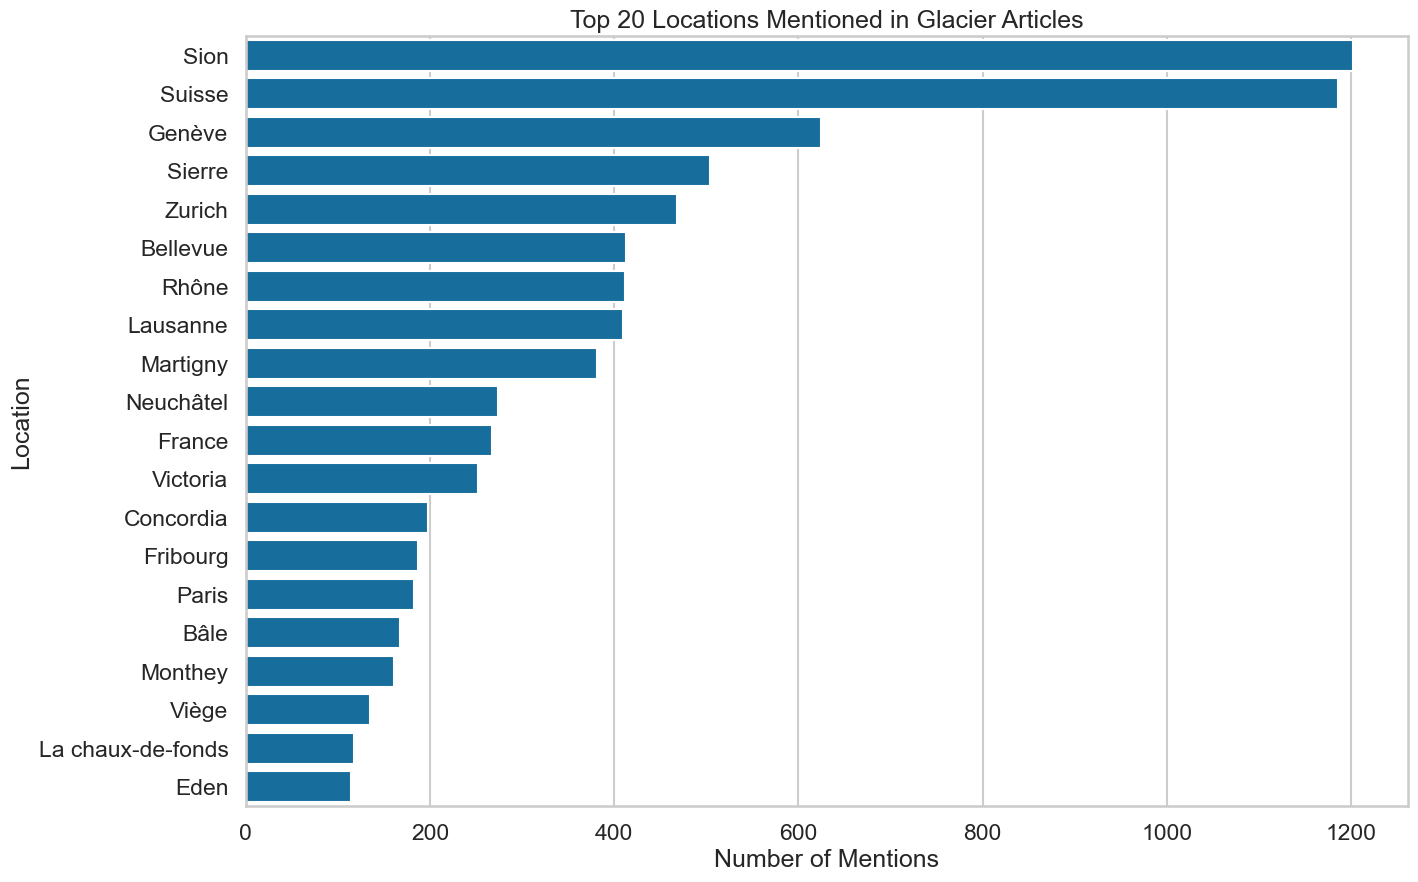

In [65]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import ast

sns.set_palette("colorblind")

# Flatten the list of locations_mentioned into a single list
all_locations = [location for sublist in final_data['locations_mentioned'] for location in sublist]

# Count occurrences of each location
location_counts = Counter(all_locations)

# Convert to DataFrame for easy plotting
location_df = pd.DataFrame(location_counts.items(), columns=['Location', 'Count']).sort_values(by='Count', ascending=False)

# Plot
plt.figure(figsize=(15, 10))
sns.barplot(x='Count', y='Location', data=location_df.head(20)) # Adjust the number as needed
plt.title('Top 20 Locations Mentioned in Glacier Articles')
plt.xlabel('Number of Mentions')
plt.ylabel('Location')
plt.show()


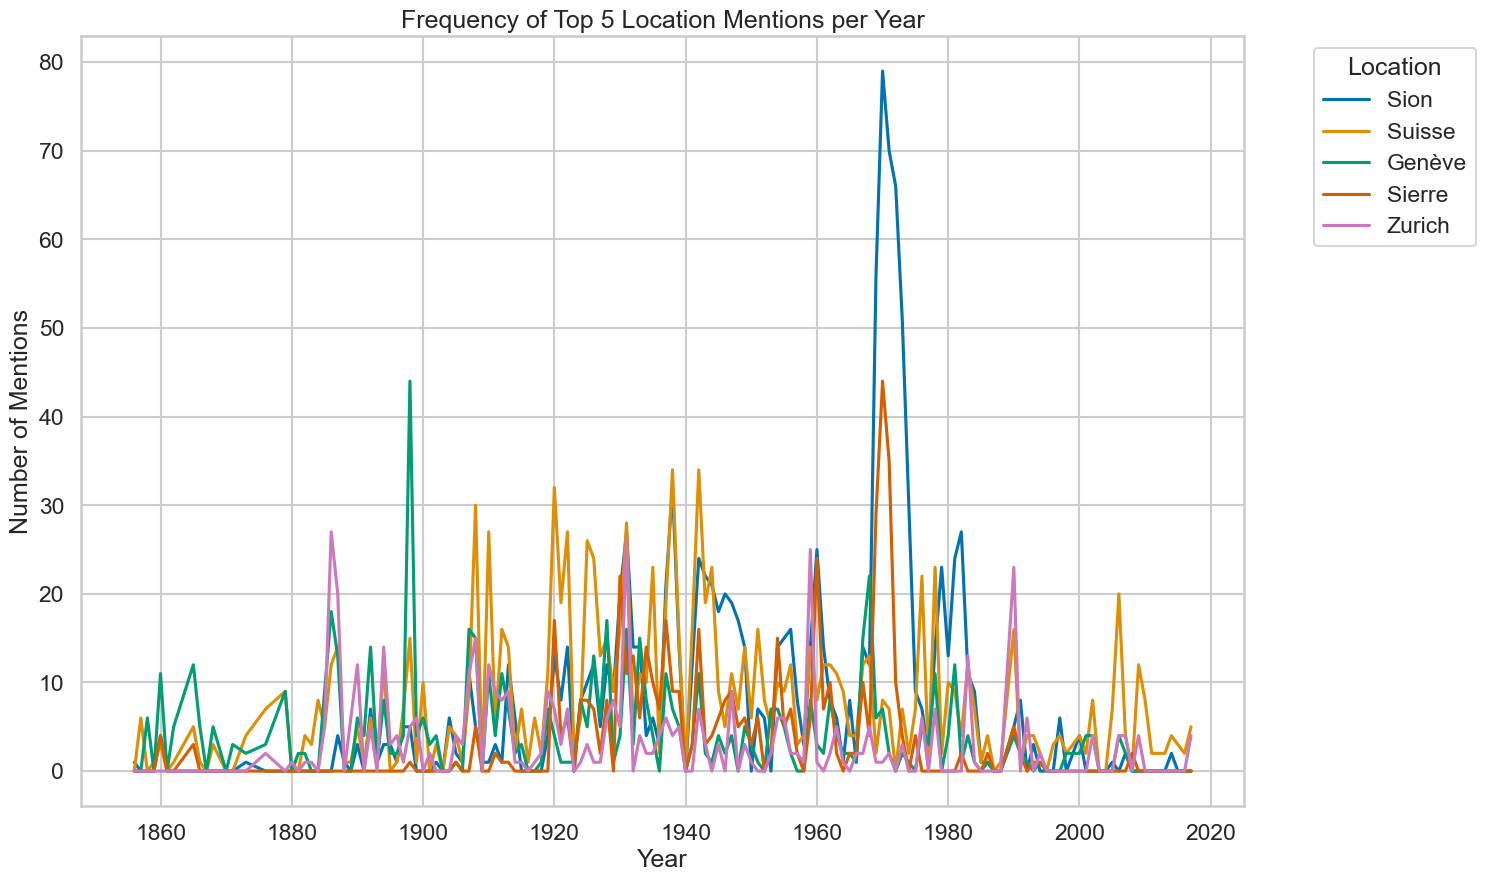

In [66]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import ast

# Expand the 'locations_mentioned' column into a row for each location
locations_expanded = final_data.explode('locations_mentioned')

# Group by year and location, then count occurrences
location_counts_per_year = locations_expanded.groupby(['year', 'locations_mentioned']).size().reset_index(name='count')

# Pivot for plotting
pivot_data = location_counts_per_year.pivot(index='year', columns='locations_mentioned', values='count').fillna(0)


# Identify the most common locations (you can adjust the number)
num_top_locations = 5  # For example, top 5 locations
top_locations = pivot_data.sum().sort_values(ascending=False).head(num_top_locations).index

# Plotting only the most common locations
plt.figure(figsize=(15, 10))
for location in top_locations:
    sns.lineplot(data=pivot_data[location], label=location)

plt.title(f'Frequency of Top {num_top_locations} Location Mentions per Year')
plt.xlabel('Year')
plt.ylabel('Number of Mentions')
plt.legend(title='Location', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()


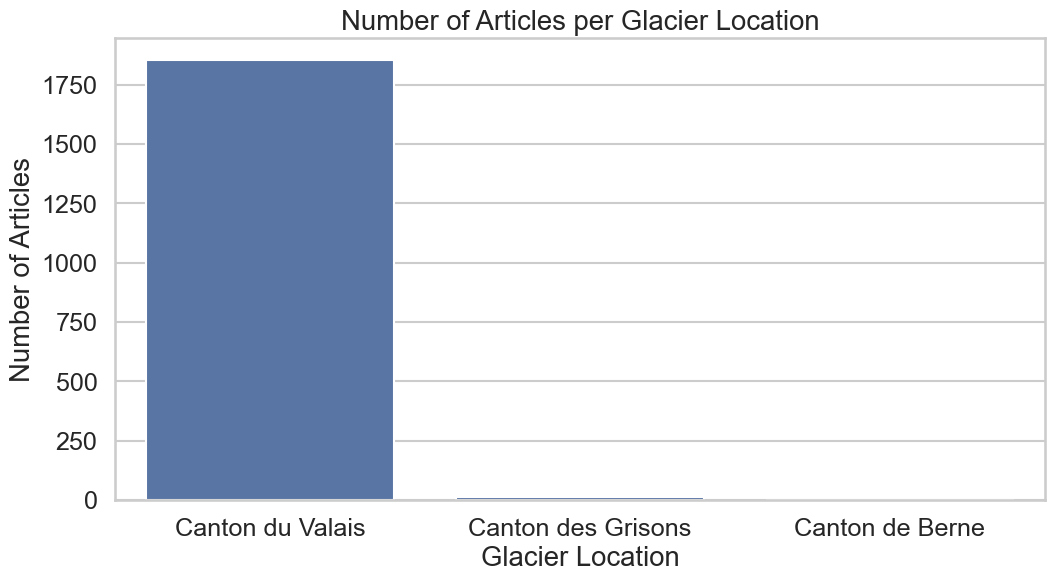

In [67]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid", context="talk", font_scale=1.1)

# Count the number of articles per glacier location
glacier_location_counts = final_data['glacier_location'].value_counts()

# Plot
plt.figure(figsize=(12, 6))
sns.barplot(x=glacier_location_counts.index, y=glacier_location_counts.values)
plt.xlabel('Glacier Location')
plt.ylabel('Number of Articles')
plt.title('Number of Articles per Glacier Location')
plt.xticks(rotation=0)
plt.show()


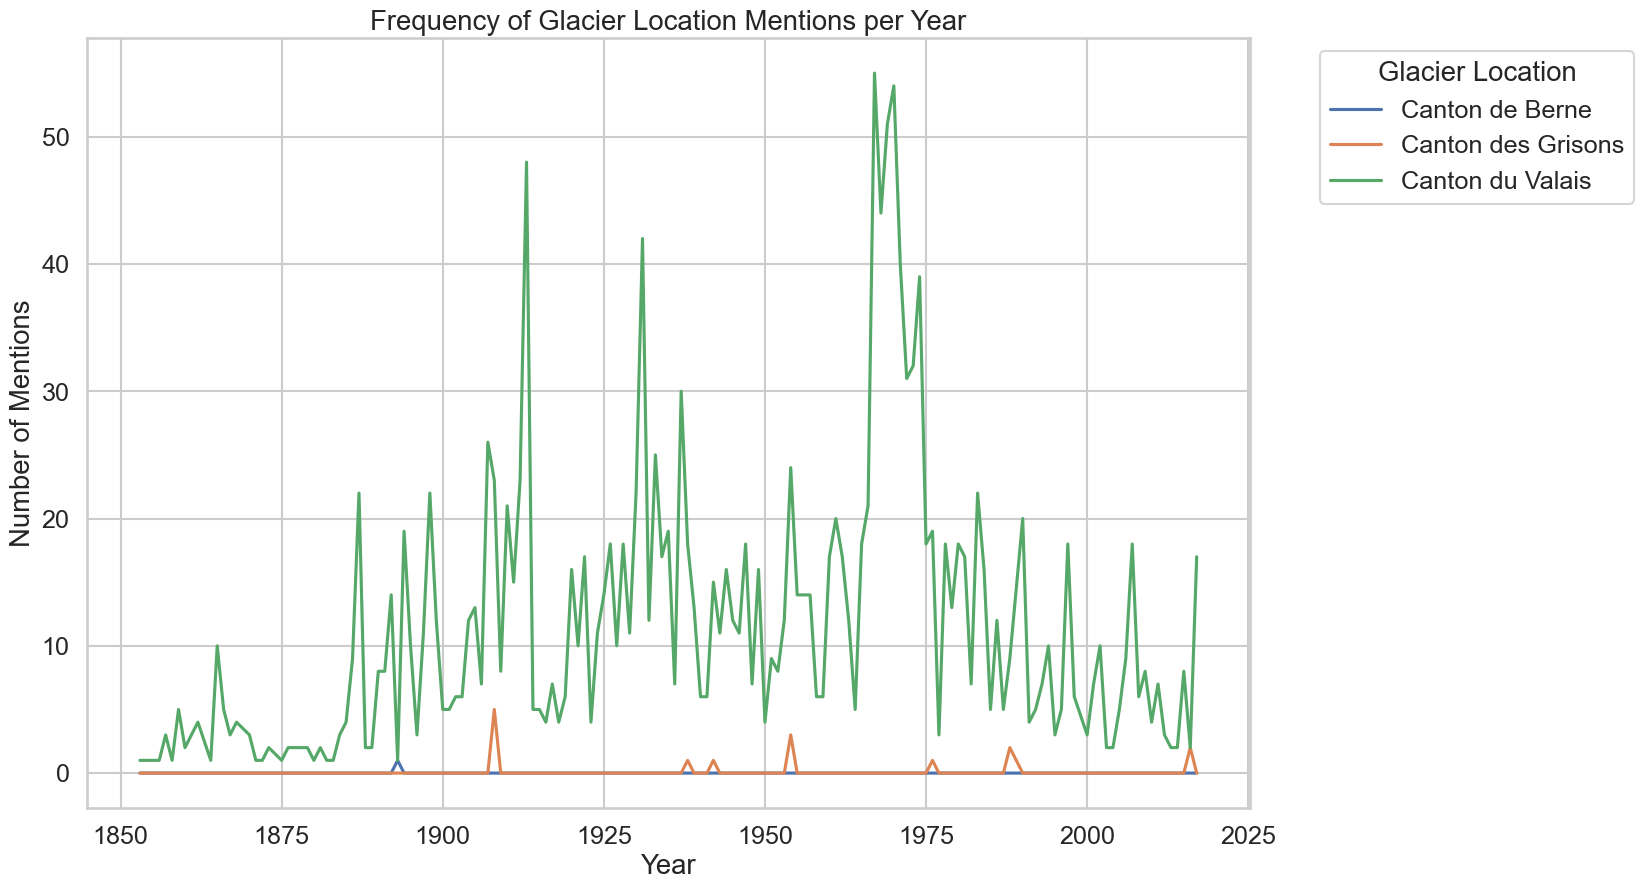

In [68]:
# Group by year and glacier location, then count occurrences
location_counts_per_year = final_data.groupby(['Year', 'glacier_location']).size().reset_index(name='count')

# Pivot for plotting
pivot_data = location_counts_per_year.pivot(index='Year', columns='glacier_location', values='count').fillna(0)

# Plotting - you can adjust the number of glacier locations to display
plt.figure(figsize=(15, 10))
for location in pivot_data.columns:
    sns.lineplot(data=pivot_data[location], label=location)

plt.title('Frequency of Glacier Location Mentions per Year')
plt.xlabel('Year')
plt.ylabel('Number of Mentions')
plt.legend(title='Glacier Location', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()


In [69]:
#!pip install keybert
#!pip install flair

In [70]:
# kw_model = KeyBERT()
# keywords = kw_model.extract_keywords(doc)

In [71]:
# from keybert import KeyBERT
# from flair.embeddings import TransformerDocumentEmbeddings

# roberta = TransformerDocumentEmbeddings('camembert-base')
# kw_model = KeyBERT(model=roberta)

In [72]:
# data['cleaned_text'].iloc[0]

In [73]:
# kw_model.extract_keywords(data['content'].iloc[0], keyphrase_ngram_range=(3, 3), use_mmr=True, diversity=0.7)

In [74]:
len([x for x in final_data["cleaned_text_with_lemmatisation"]])

1869

In [75]:
len([x for x in final_data["cleaned_text_with_lemmatisation"] if x not in [None, "", " "]])

1869

## Topic detection

In [76]:
from bertopic import BERTopic

desired_number_of_topics = 20

topic_model = BERTopic(language="french", calculate_probabilities=True, verbose=True,
                       nr_topics=desired_number_of_topics)
# Filter out rows where 'cleaned_text_with_lemmatisation' is not None
filtered_data = final_data[final_data["cleaned_text_with_lemmatisation"].notna()]

topics, probs = topic_model.fit_transform([x for x in final_data["cleaned_text_with_lemmatisation"] if x is not None])

Batches:   0%|          | 0/59 [00:00<?, ?it/s]

2023-12-09 11:46:10,540 - BERTopic - Transformed documents to Embeddings
2023-12-09 11:46:18,032 - BERTopic - Reduced dimensionality
2023-12-09 11:46:18,195 - BERTopic - Clustered reduced embeddings
2023-12-09 11:46:19,402 - BERTopic - Reduced number of topics from 38 to 20


In [77]:
topic_model.get_topic_info()

Topic  Count                                     Name  \
0      -1    566               -1_hotel_glacier_grand_ete   
1       0    266                 0_ete_faire_jour_glacier   
2       1    236                1_ski_hiver_sport_tourism   
3       2    210              2_ete_conseil_federal_faire   
4       3    103           3_hotel_pension_lit_prospectus   
5       4     67      4_glacier_glace_metre_rechauffement   
6       5     67           5_hotel_pension_dep_prospectus   
7       6     47              6_victime_chute_an_accident   
8       7     43               7_frere_eglise_anglais_alt   
9       8     42              8_pilote_avion_appareil_ete   
10      9     36         9_glacier_avs_aletsch_bettmeralp   
11     10     32           10_film_exposition_art_artiste   
12     11     31        11_hotel_pension_excursion_postal   
13     12     26               12_zone_tir_mercredi_mardi   
14     13     25       13_altitude_metre_riederalp_furker   
15     14     17             14_eau_usine_million_energie   
16     15     16       15_concert_musique_disque_causerie   
17     16     16     16_janvier_situation_hotel_reduction   
18     17     13  17_professeur_science_mercanton_naturel   
19     18     10                 18_dranse_heure_pont_eau   

                                       Representation  \
0   [hotel, glacier, grand, ete, suisse, aletsch, ...   
1   [ete, faire, jour, glacier, heure, bien, grand...   
2   [ski, hiver, sport, tourism, pied, office, ale...   
3   [ete, conseil, federal, faire, suisse, etat, c...   
4   [hotel, pension, lit, prospectus, station, gra...   
5   [glacier, glace, metre, rechauffement, recul, ...   
6   [hotel, pension, dep, prospectus, grand, cafe,...   
7   [victime, chute, an, accident, ete, cabane, al...   
8   [frere, eglise, anglais, alt, aletsch, fois, p...   
9   [pilote, avion, appareil, ete, vol, militaire,...   
10  [glacier, avs, aletsch, bettmeralp, dep, siecl...   
11  [film, exposition, art, artiste, œuvre, grand,...   
12  [hotel, pension, excursion, postal, prospectus...   
13  [zone, tir, mercredi, mardi, jeudi, graviter, ...   
14  [altitude, metre, riederalp, furker, juin, cha...   
15  [eau, usine, million, energie, bassin, projet,...   
16  [concert, musique, disque, causerie, cari, con...   
17  [janvier, situation, hotel, reduction, maison,...   
18  [professeur, science, mercanton, naturel, soci...   
19  [dranse, heure, pont, eau, ete, riviere, digue...   

                                  Representative_Docs  
0   [ete pat finir valai baigner lumiere soleil pr...  
1   [fete club abhx suisse samedi dejeuner reuniss...  
2   [zermatt pied cervin saa fee perle alpes graec...  
3   [confederation suisse assemblee federal seance...  
4   [ail centre excursion tennis court hotel pensi...  
5   [climat helvetie glacier fondre glacier aletsc...  
6   [cran siekr beau golf plage tennis alpin excur...  
7   [montagne accident faletschhorn recit survivan...  
8   [hotel pension bel alp alt station briguer nat...  
9   [confederation accident aviation aletsch enqne...  
10  [unesco glacier escalier climat cle mythe conc...  
11  [imaginee sublime adaptation homme coeur expos...  
12  [vacance chemin fer furker oberaip route recom...  
13  [avis tir tir munition date lieu lieu jeudi ve...  
14  [koctlsborm hoteldelajungfrau altitude metre j...  
15  [projet barrage usine electrique etudie servic...  
16  [emission radiophonique mercredi extraire jour...  
17  [bettmeralp hotel woldhaus hotel montagn confo...  
18  [science naturel societe vaudois science natur...  
19  [derniere nouveau erne dranse telegraphie mart...

In [78]:
topic_names = topic_model.topic_labels_

In [79]:
topic_names

{-1: '-1_hotel_glacier_grand_ete',
 0: '0_ete_faire_jour_glacier',
 1: '1_ski_hiver_sport_tourism',
 2: '2_ete_conseil_federal_faire',
 3: '3_hotel_pension_lit_prospectus',
 4: '4_glacier_glace_metre_rechauffement',
 5: '5_hotel_pension_dep_prospectus',
 6: '6_victime_chute_an_accident',
 7: '7_frere_eglise_anglais_alt',
 8: '8_pilote_avion_appareil_ete',
 9: '9_glacier_avs_aletsch_bettmeralp',
 10: '10_film_exposition_art_artiste',
 11: '11_hotel_pension_excursion_postal',
 12: '12_zone_tir_mercredi_mardi',
 13: '13_altitude_metre_riederalp_furker',
 14: '14_eau_usine_million_energie',
 15: '15_concert_musique_disque_causerie',
 16: '16_janvier_situation_hotel_reduction',
 17: '17_professeur_science_mercanton_naturel',
 18: '18_dranse_heure_pont_eau'}

In [80]:
# Add topic names to the DataFrame
final_data['topics'] = topics

final_data.head()

uid language  \
0  JDG-1882-09-01-a-i0001       fr   
1  JDG-1902-09-06-a-i0042       fr   
2  LLE-1893-11-18-a-i0007       fr   
3  GDL-1901-08-05-a-i0017       fr   
4  JDG-1965-09-03-a-i0011       fr   

                                        title    size country newspaper  \
0                                       SUSSE  4435.0      CH       JDG   
1                          DERNIÈRESJ1ÉPÊCHES   593.0      CH       JDG   
2                     L'EXPOSITION DE CHICAGO  1379.0      CH       LLE   
3                   fèhxoaiqoe des &lt;£lpes.   672.0      CH       GDL   
4  Le rôle des experts et leur responsabilité   547.0      CH       JDG   

              issue pages  nb_pages    year  ... SPONSORING_AGENCY  \
0  JDG-1882-09-01-a   1,2       2.0  1882.0  ...               NaN   
1  JDG-1902-09-06-a     3       1.0  1902.0  ...               NaN   
2  LLE-1893-11-18-a     3       1.0  1893.0  ...               NaN   
3  GDL-1901-08-05-a     2       1.0  1901.0  ...               NaN   
4  JDG-1965-09-03-a     3       1.0  1965.0  ...               NaN   

                                           REFERENCE REMARKS_y PUB_IN_FOG_y  \
0                                                NaN       NaN          NaN   
1                                                NaN       NaN          NaN   
2                                                NaN       NaN          NaN   
3                                                NaN       NaN          NaN   
4  www.glacierhazards.ch http://glaciology.ethz.c...       NaN          NaN   

  EVENT_TYPE                              sentence_with_glacier  \
0        NaN  — Dernierement le domestique du chalet du Rose...   
1        NaN  Deux etrangers, un monsieur et une dame, origi...   
2        NaN                                               None   
3        NaN  Une caravane de qnatre touristes, partie jeudi...   
4  Avalanche  Le role des experts et leur responsabilite Red...   

   glacier_location                                       cleaned_text  \
0  Canton du Valais  susse eve septembre bulletin politique depeche...   
1  Canton du Valais  dernieresj epeches suisse berne double suicide...   
2   Canton de Berne  lexposition chicago chicago oclobre architectu...   
3  Canton du Valais  fehxoaiqoe lpes heures glace zermatt aout cara...   
4  Canton du Valais  role experts responsabilite emotion catastroph...   

                     cleaned_text_with_lemmatisation  topics  
0  suss eve septembre bulletin politique depecher...       0  
1  dernieresj epecher suisse bern double suicide ...      -1  
2  lexposition chicago chicago oclobr architectur...      10  
3  fehxoaiqoe lpe heure glace zermatt aout carava...       0  
4  role expert responsabilite emotion catastrophe...      -1  

[5 rows x 50 columns]

In [81]:

for topic in topic_names.keys():
    print('Topic:', topic_names[topic])
    for index, row in final_data[final_data['topics'] == topic].iterrows():
        print(f"    Title: {row['title']}")
        print(f"    Date: {row['date']}")
        print(f"    Content: {row['content'][:400]}\n")
        print("     ----------------------------------------------------\n")
    print('\n')

Topic: -1_hotel_glacier_grand_ete
    Title: DERNIÈRESJ1ÉPÊCHES
    Date: 1902-09-06T00:00:00Z
    Content: DERNIERESJ 1 EPECHES Suisse BERNE. — Double suicide au masque Bruneau. — Deux garcons bouchers de Bienne, les nommes Fritz Meyer et Ernest Ruch, disparurent subitementmercredi soir. On se mit a leur recherche et on apprit qu'ils s'etaient rendus au bord du lac, pres de Nidau, dans un bosquet do l'Erlenhof. On trouva la leurs cadavres gisant cote a co'. e. Les malheureux s'etaient suicides au moyen

     ----------------------------------------------------

    Title: Le rôle des experts et leur responsabilité
    Date: 1965-09-03T00:00:00Z
    Content: Le role des experts et leur responsabilite Red.-Dans l'emotion d'une catastrophe comme celle de l'Allalin, il est inevitable que l'opinion pose la question des 'l'esponsabilites. Les precautions prises pour assurer la securite des travaux de deblaiement-reperage au theodolite alerte par sirenes-donnent a penser qU ~ si l'on avait f

In [235]:
# I don't know how correct they are: you need to check all of them

TOPIC_NAMES = {
    -1: "Pas de sujet",
    0: "Pas de sujet", 
    1: "Publicité",
    2: "Héritage national",# Politique
    3: "Publicité",
    4: "Réchauffement climatique",
    5: "Publicité",
    6: "Accidents",
    7: "Publicité",
    8: "Aviation",
    9: "Héritage national",#?
    10: "Héritage national", #Exposition
    11: "Pas de sujet",
    12: "Evénements de guerre",
    13: "Publicité",
    14: "Projets hydrauliques",
    15: "Héritage national", # Concert de musique
    16: "Publicité",
    17: "Science / Etude et protection des glaciers",
    18: "Accidents",
}

In [236]:
final_data['topic_name'] = final_data['topics'].apply(lambda topic: TOPIC_NAMES[topic])

In [237]:
final_data.head()

uid language  \
0  JDG-1882-09-01-a-i0001       fr   
1  JDG-1902-09-06-a-i0042       fr   
2  LLE-1893-11-18-a-i0007       fr   
3  GDL-1901-08-05-a-i0017       fr   
4  JDG-1965-09-03-a-i0011       fr   

                                        title    size country newspaper  \
0                                       SUSSE  4435.0      CH       JDG   
1                          DERNIÈRESJ1ÉPÊCHES   593.0      CH       JDG   
2                     L'EXPOSITION DE CHICAGO  1379.0      CH       LLE   
3                   fèhxoaiqoe des &lt;£lpes.   672.0      CH       GDL   
4  Le rôle des experts et leur responsabilité   547.0      CH       JDG   

              issue pages  nb_pages    year  ...  \
0  JDG-1882-09-01-a   1,2       2.0  1882.0  ...   
1  JDG-1902-09-06-a     3       1.0  1902.0  ...   
2  LLE-1893-11-18-a     3       1.0  1893.0  ...   
3  GDL-1901-08-05-a     2       1.0  1901.0  ...   
4  JDG-1965-09-03-a     3       1.0  1965.0  ...   

                                           REFERENCE REMARKS_y PUB_IN_FOG_y  \
0                                                NaN       NaN          NaN   
1                                                NaN       NaN          NaN   
2                                                NaN       NaN          NaN   
3                                                NaN       NaN          NaN   
4  www.glacierhazards.ch http://glaciology.ethz.c...       NaN          NaN   

  EVENT_TYPE                              sentence_with_glacier  \
0        NaN  — Dernierement le domestique du chalet du Rose...   
1        NaN  Deux etrangers, un monsieur et une dame, origi...   
2        NaN                                               None   
3        NaN  Une caravane de qnatre touristes, partie jeudi...   
4  Avalanche  Le role des experts et leur responsabilite Red...   

   glacier_location                                       cleaned_text  \
0  Canton du Valais  susse eve septembre bulletin politique depeche...   
1  Canton du Valais  dernieresj epeches suisse berne double suicide...   
2   Canton de Berne  lexposition chicago chicago oclobre architectu...   
3  Canton du Valais  fehxoaiqoe lpes heures glace zermatt aout cara...   
4  Canton du Valais  role experts responsabilite emotion catastroph...   

                     cleaned_text_with_lemmatisation topics         topic_name  
0  suss eve septembre bulletin politique depecher...      0       Pas de sujet  
1  dernieresj epecher suisse bern double suicide ...     -1       Pas de sujet  
2  lexposition chicago chicago oclobr architectur...     10  Héritage national  
3  fehxoaiqoe lpe heure glace zermatt aout carava...      0       Pas de sujet  
4  role expert responsabilite emotion catastrophe...     -1       Pas de sujet  

[5 rows x 51 columns]

In [238]:
climate_change_articles = final_data[final_data['topic_name'] == 'Climate Change']

In [239]:
climate_change_articles.content

Series([], Name: content, dtype: object)

In [312]:

# Assuming 'topics' column contains topic codes
final_data['topic_name'] = final_data['topics'].apply(lambda topic: TOPIC_NAMES.get(topic, topic))

# Print information for articles related to "climate change" only
for index, row in final_data[final_data['topic_name'] == 'Réchauffement climatique'].iterrows():
    print(f"Topic: {row['topic_name']}")
    print(f"Title: {row['title']}")
    print(f"Date: {row['date']}")
    print(f"Content: {row['content'][:]}\n")
    print("----------------------------------------------------\n")

Topic: Réchauffement climatique
Title: Mattmark Le glacier de l'Allalin a avancé de 100 mètres
Date: 1965-10-02T00:00:00Z
Content: Mattmark Le glacier de l'Allalin a avance de 100 metres Mattrnark.-Les observations faites a Mattmark depuis la date de la catastrophe jusqu'a ce jour permettent de conclure que durant ces quatre dernieres semaines la partie frontale du glacier de l'Allalin a avance de 100 metres environ au total sur la pente ou reposait l'ancienne masse. Ces derniers'temps cependant le glacier semble se stabiliser legerement, l'avance de ces derniers [ours n'etant plus que d'un OU deux metres alors qu'elle fut de 5 ou 6 metres par jour la'semaine precedente. On ne peut savoir si le glacier. se contentera " d'occuper en partie la position qu'il avait precedemment en reposant sur une base dont l'inclinaison : varie entre 38 et 60 % ou si son mouvement sera tel qu'il finira par s'ecrouler a nouveau. 1 ;\,': i :: 'i, ~';~ t ;~ .,-.- " ;_ 1 ~-" 

-------------------------------

In [327]:
#topic 4 :Topic: doutes
#Title: Le glacier d'Arolla
#Date: 1997-06-27T00:00:00Z
"""
La comprehension de ces mecanismes complexes pourrait etre determinante dans la prevision du comportement glaciaire et son influence sur l'hydrologie des decennies a venir, en particulier, si l'augmentation de temperature due a l'activite humaine venait a se confirmer. JEAN-MICHEL BONVIN Tire du Choucas-Journal delaUnuide-Dlxciu
"""

"\nLa comprehension de ces mecanismes complexes pourrait etre determinante dans la prevision du comportement glaciaire et son influence sur l'hydrologie des decennies a venir, en particulier, si l'augmentation de temperature due a l'activite humaine venait a se confirmer. JEAN-MICHEL BONVIN Tire du Choucas-Journal delaUnuide-Dlxciu\n"

In [325]:
#topic 4 :questionnement sur les mouvement des glaciers avant l'augmentation des températures à la surface du globe

"""
Topic: Réchauffement climatique
Title: YABIÉTÉS
Date: 1883-10-22T00:00:00Z
Content: YABIETES l, e mouvement « les glaciers. M. Henri de Parville publie dans le Journal des Debats un interessant article sur les mouvements des glaciers. Il constate que depuis plusieurs annees les glaciers ont recule, mais que ce recul n'est que momentane et qu'une periode d'extension succedera a celle du retrait. Nous extrayons de l'elude de M. de Par ville le passage suivant : On sait que les glaciers, a la derniere epo que geologique, avaient un developpement immense ; ils descendaient jusqu'en France, jusqu'en Italie et en Allemagne ; on voit encore des traces de glissement marquees par les glaces sur les roches polies par le frottement a iles hauteurs considerables au dessus des glaciers actuels. Pour n'en citer qu'un exemple, le glacier du Uhone s'etendait autrefois jusqu'a Martigny ; il se soudait la avec un glacier qui descendait du mont Diane, et ces masses juxtaposees s'avancaient en rabotant les _ montagnes avec une force irresistible qu'au lac Leman, dont elles remplissaient le bassin. Le glacier s'etendait ensuite bien au dela, jusqu'au Jura. Depuis les temps historiques, les glaciers sont restes a peu pres tels que nous les voyons aujourd'hui, e'est-adire avec des dimensions absolument exigues comparativement a ce qu'elles etaient aux pe riodes glaciaires. Ils couvraient alors une grande partie de l'Europe ; maintenant, ils n'occupent plus en Suisse qu'une surface qu'on evalue a 3000 kilometres carres. On comprend tres bien qu'en les voyant encore retrograder depuis plusieurs annees, quelques personnes se demandent si, en definitive, ce n'est pas la suite des temps qui amene ce resultat ; ils diminuent, ils vont ainsi en retrogradant jusqu'a ce qu'il n'y en ait plus trace. Nous assisterions a la lin des glaciers. L'opinion n'est pas fondee ; il ne faut pas qu'il y ait meprise a cet egard. Non, les glaciers ne s'en vont pas ; nous les retrouverons dans dix ans, dans vingt ans, a leur place comme aujourd'hui ; pourquoi disparaitraieutils ? Notre climat n'a pas change depuis les temps historiques. Mais a cette raison qui a sa valeur, il convient d'en ajouter une meilleure, les faits parlent, le passe permet de prejuger de l'avenir. Les glaciers ont deja diminue jadis, puis ils ont repris de l'estension ; ils passent sans cesse par une periode d'affaissement et d'accroissement. Les exemples abondent. C'est un ingenieur des ponts et chaussees du canton de Vaud, J. Venetz, qui, le premier, a mis ces changements alternatifs en pleine evidence eu 1833 (1). Ainsi, vers le commencement du dix-septieme siecle, le glacier inferieur de Grindelwald, belle vallee comprise entre la Jungfrau et le Faulhorn, envahit les paturages et rasa les arbres et les chalets et une chapelle dediee a sainte Petronille. On voit encore aujourd'hui les traces d'un sentier qui existait au siecle dernier ; il est barre par des glaciers qui en rendent l'acces dangereux. Au mont Blanc, au mont Rose, les glaciers ont pris de l'extension, car plusieurs cols, faciles a franchir au quinzieme siecle, sont devenus impraticables au dix-huitieme. Un medecin de Lucerne, Kapeler, avait dresse en 1740 une carte des environs du Grimsel ; en comparant les indications de cette carte avec l'extremite des glaciers de l'Aar en 1845, Agassiz releva un envahissement de pres d'un kilometre. Le petit glacier du Faulhorn, appele Dreckgletscher, n'existait pas au commencement de ce siecle ; le grand glacier d'Aletsch, le plus long de la Suisse, sinon le plus profond, s'elargit en 1848. Il deracina et broya sur une longueur de plusieurs kilometres des sapins qui depuis deux cents ans existaient sur ses bords ; il renversa des maisqns de construction tres ancienne. Depuis 1855 a peu pres la periode d'extension a pris fin, la plupart des glaciers ont re trograde tres manifestement ; il n'y a la rien que de tres normal ; cela etait prevu. Il y a vingt-cinq ans, les deux grands gbciers de la vallee de Chamonix, qui allaient atteindre dans leur mouvement progressif les habitations elevees pres de la moraine terminale, s'arreterent ; depuis, ils n'ont cesse de retrograder. Le mouvement retrograde est loin d'etre simultane pour tous les glaciers ; ainsi, pendant que le glacier des Bois qui fait suite a la mer de Glace retrogradait, le glacier inferieur de l'Aar depassait encore de 10 me tres le point ou il s'etait arrete l'annee precedente, et son epaisseur mesuree pres d'Abschwung augmentait d'environ G metres. Si le phenomene semble general, ses periodes sont tres variables pour les differents glaciers. A l'heure actuelle, la physionomie des glaciers est incontestablement tres modifiee. Les touristes qui ont parcouru, il y a vingt ans, la jolie vallee de Beicbenbach avec ses chutes admirables en allant de Meiringenau Grindelwald par la grande Scheideck et Bosenlaui, ne reconnaitraient plus le joli petit glacier qui descend du Wetterhorn et qu'a si bien etudie M. Charles Martins. Comme une fa'aise de pur cristal, il dessinait sa coulee etincelante au milieu des arbres verts, des fougeres et des ileurs alpines ; on penetrait sous une arcade transparente d'ou s'echappait le torrent du glacier ; on allait assez loin sous ce tunnel de glace azuree. Aujourd'hui, l'extremite du glacier de Bosenlaui a completement disparu ; a la place, on marche au milieu d'un amas informe de debris de roche. En 1857, le glacier du Rhone s'avancait jusqu'au petit pont qui avoisine l'hotel ; maintenant il faut aller le chercher a plus d'un quart d'heure de marche ; il a battu en retraite chaque annee. Sur la demande du Club alpin, M. Gosset, ingenieur du bureau topographique federal, a fait etablir annuellement devant le front du glacier un petit mur en pierres seches peintes en noir ; on voit une serie concentrique do murailles qui marquent bien le recul des glaces ; de 1874 a 1883, le mouvement de recul a varie entre 25 metres et 70 metres par an ; en ce moment, l'ancien fond du glacier apparait comme le lit d'une riviere mise a sec, avec d'innombrables debris de roches de toute nature ; le ruisseau torrentiel qui donne naissance au Rhone coule au milieu, a travers les roches ; il faut s'avancer jusqu'au coude que forme la vallee pour trouver l'extremite du glacier qui s'etala en eventail en descendant' du plateau superieur. La voute terminale n'existe plus ; le ruisseau produit par la fonte des glaces sort des decombres sale et bourbeux, souille par les fines poussieres provenant de la trituration des roches pendant le parcours du glacier. Comme a Grindehvald, on en a remplace les grottes naturelles par des grottes artificielles. (I) Memoires sur les variations de la temperature des Alpes. Zurich, 1833. On creuse a coups de pioche un tunnel dans la masse, et, moyennant 50 centimes, on vous permet de penetrer sous la voute glacee ; c'est une petite industrie qui donue uu bon revenu au proprietaire de la grotte et de bons rhumes aux curieux. Elle a bien 2 metres de haut sur 12 metres de long, cette grotte humide ; mais quels reflets feeriques ! On s'enfonce dans le bloc de glace comme dans un gigantesque morceau de cristal ; tout est transparent ; la muraille de glace vous envoie des iueurs d'un bleu si pale et si doux que le regard en est tout etonne ; cette lumiere est inimaginable de beaute ; c'est la lumiere de l'eau vue sous une grande epaisseur, celle qui sans doute regne dans les profondeurs des grands lacs et egaye les poissons ; plus loin, rite viendrait ; aussi a-t-on plante sans facon sur des planchettes quelques bougies ; ce sont des scintillations, des eblouissements au plafond, sur les parois, de tous cotes, a rappeler les splendeurs des Mille et mie Nuits. Malheureusement, il vous tombe de temps en temps sur la figure quelques gouttes d'eau glacee qui vous rappellent a la realite. L'œil grise de bleu, on se hate de sortir de cette glaciere. La grotte est creusee dans les blocs, qui, proteges contre le froid nar les eboulis, garnissent encore la rive gauche ; il faut avancer de 200 metres pour toucher le front du glacier et les premieres couches glacees toutes salies par les amoncellements de roches ; il est difficile de se promener sur cette pente de glace semee de blocs, souillee par des boues terreuses gelees, sillonnee de filets d'eau ; au moindre mouvement, les boues descendent, entrainant les roches et ceux qui s'aventurent dans leur dedale ; les pierres tombent d'en haut, avec des morceaux enormes de glace ; il faut quitter la place. Le bas du glacier est a 1,753 metres d'altitude ; apres le premier plafond glace se dresse brusquement comme une cataracte tout a coup congelee, sur une hauteur de plus de 300 metres, la cascade colossale du glacier qui tombe du premier plateau situe a environ 2100 metres. La cascade emplit la vallee de bord a bord ; c'est indescriptible d'aspect : c'est l'image du desordre et du chaos. On di rait qu'on est venu precipiter dans la vallee des millions de tombereaux de blocs de glace ; toutes ces masses s'enchevetrent les unes dans les autres en prenant les fames les plus etranges ; plus haut, la coulee apparait coupee par d'enormes crevasses paralleles ; puis, tout en haut, apres un nouvel amoncellement, apparait le plateau de glace a peu pres unie, encaisse entre le Gerstbœrner (3185 metres) et le Gemeshœrner (3200 metres), le Rhonestock (3003 metres) et le Dammastock (3633 metres ); le glacier s'eleve comme en terrasses successives sur une longueur de 24 kilometres On aborde la premiere terrasse par la moraine laterale, pres de l'hotel du Belvedere, sur la route de laFurca ; on domine de la la cataracte et le plateau. Le plateau ressemble a un grand golfe congele ; on voit dans le lointain des points noirs qui se dessinent sur le blanc des glaces, et qui avancent lentement ; ce sont les amateurs de glaciers qui ne veulent pas revenir chez eux sans avoir essaye leurs souliers ferres : on en trouve de tous les pays : Anglais, Francais, Allemands, Italiens. C'est Venetz, en 1821, et Hugi, en 1870, qui les premiers mirent hors de contestation les ascillations periodiques dans l'etendue des glaciers ; tous deux les attribuent aux va riations climateriques. Le climat ne change pas en Europe. ; mais il eprouve cependant de petites fluctuations plus ou moins repetees. On eut pu croire que, apres une annee de secheresse ou une annee de piuie ou de froid, les glaciers ressentiraient le contre-coup de cette influence ; en realite, il n'en est rien. Aores une annee humide et froide, les glaciers continuent leur mouvement de retraite. Cependant, si les oscillations des glaciers sont en apparence independantes des conditions meteorologiques des saisons, en realite, comme le voulaient Venetz et Hugi, elles ont avec elle un lien etroit. Ces relations de cause a effet sont tres complexes. M. Forel les a recemment mises on relief. M. Forel, apres avoir compulse, comme ses devanciers, diverses chroniques locales, notamment le Pfarrbuch du Grindelwald ou sont consignes les mouvements du glacier inferieur depuis trois cents ans, a reconnu que les glaciers varient d'etendue par periodes, occupant de longues series d'annees, dix, quinze, vingt, trente-cinq ans ; ils n'ont pas de variations annuelles ; pendant d'autres periodes, leur etendue reste a peu pres stationnaire. Un glacier en retraite recule toujours sans aucune alternative de marche en avant. Ainsi, pour Grindelwald, de 1540 a 1575 grande retraite (35 ans ); de 1575 a 1002 grande extension (27 ans) ; de 1002 a 1020 etat stationnaire (18 ans ); de 1005 a 1080 retraite (15 ans). En 1703 maximum d'avancement ; en 1720 maximum de retraite ; en 1743 maximum d'avancement ; en 1748 retraite ; de 1770 a 1778 progression ; en 1819 grande progression qui se prononce de nouveau en 1840 ; de 1855 a 1883 retraite. Il est bien clair que, pendant ce laps de temps considerable, nous avons eu des hivers humides ou tres secs, et pourtant les glaciers ont continue a battre en retraite ou a progresser. Ailleurs est la solution. Tout le se cret de ces oscillations periodiques semble se rapporter aux variations de vitesse de la coulee. La vitesse de cheminement des glaces varie avec l'accumulation superieure des neiges (1). Si la neige tombee pendant l'hiver est peu abondante, la rapidite de (I) ija vitesse d'ecoulement est diminuee blement depuis dix ans au moins au glacier du Rhone. ment est diminuee. La couche superficielle et la couche du fond qui vient au jour fondent plus completement pendant la saison chaude. Premier resultat : amincissement du glacier, ablation de son extremite. Mais l'amincissement diminue la charge motrice et l'ecoulemont. Ces actions et reactions reciproques de l'epaisseur sur la vitesse et de la vitesse sur l'epaisse ir une fois commencees, se poursuivent pendant des annees, et le deficit, si faille qu'il eut ete d'abord, finit par devenir tres considerable. Le glacier fond a son extremite avant d'avoir parcouru sa course entiere. Il en est de meme en sens inverse si la quantite de neige tombee accroit la vitesse d ecoulement ; le glacier resistera a la fusion plus longtemps et s'avancera plus loin. Les variations dans la quantite de neige tombee (I) ameneront bien ainsi le recul ou la progression, mais a longue date ; l'effet final ne se manifestera qu'a l'expiration du temps employe par la glace nouvellement formee pour accomplir son voyage depuis la region des neiges permanentes jusqu'a l'extremite inferieure du glacier. Ce temps est toujours fort long, puisque la descente est tres lente. Cette explication, reduite ainsi a ses termes les plus simples, rend tres bien compte des faits. Elle permet notamment de concevoir, ce qui autrement serait incomprehensible, comment deux glaciers tres voisins peuvent etre, a un moment donne, l'un en progres l'autre en retraite, ainsi qu'il est arrive en 1800 dans la vallee de Chamonix, ou le glacier des Bossons s'est raccourci de 350 metres pendant que le glacier des Bois s'avancait de 14 metres. La periode d'allongement ou de diminution est liee a la longueur du glacier. La meme coulee peut meme ne pas avancer ou reculer au meme moment, bien que la surabondance ou le deficit des neiges se produise en meme temps pour chaque affluent. Les periodes varient naturellement selon les glaciers et leur topographie. Le raccourcissement actuel a debute en 1854 pour le Mont-Blanc, en 1855 pour le glacier superieur de Grindelwald, en 1857 pour le glacier du Rhon 6, en 1800 pour le glacier d'Aletsch, en 1870 seulement, pour les glaciers du Gorner et de Fiesch. Le glacier des Bossons ne recule que depuis 1875 ; celui du Shallhorn depuis 1878. Celui de Gretroz recule maintenant. On peut dire cependant que la periode de retraite des grands glaciers qui persiste depuis un quart de siecle touche a sa fin ; deja quelques glaciers reprennent leur marche en avant. Il serait bien interessant de serrer la question de pres aujourd'hui avec nos methodes perfectionnees d'observation, et de voir jusqu'a quel point la marche des glaciers est en rapport eloigne avec les grands hivers. Si les glaciers allaient refleter apres de longues annees le caractere meteorologique des saisons ! Hugi pensait que le mouvement progressif du glacier de Grindelwald, constate en 1593 etait du aux neiges de 1572. M. Forel est d'avis que la periode de retraite qui a mence en 1850 a ete la consequence d'une periode seche que l'on sait avoir regne de 1832 a 1838 ! Les mouvements de progression actuelle des petits glaciers proviendraient des dernieres annees pluvieuses. Quoi qu'il en soit, cette esquisse trop longue, bien que tres ecourtee, sur les glaciers, nous permet de poser en terminant cette conclusion rassurante, qui sera certainement bien accueillie des touristes, des compagnies de chemin de fer et des maitres d'hotels : les glaciers do la Suisse se portent tres bien ; ils ne fondent pas et n'ont pas l'intention de disparaitre, comme on l'a repete a tort ; au contraire, apres une periode de retraite momentanee, ils vont reprendre de l'extension, s'avancer de nouveau dans les vallees et se montrer encore aux curieux des grands spectacles de la nature dans toute leur beaute grandiose et dans leur etincelante splendeur. Henri DE PARVILLE. (I) Il convient d'ajouter que les causes d'oscillation subsistent toujours pendant plusieurs annees, parce que c'est aussi le plus souvent par periodes que la neige tombe en abondance ou que regne une secheresse rotative. 
"""

"\nTopic: Réchauffement climatique\nTitle: YABIÉTÉS\nDate: 1883-10-22T00:00:00Z\nContent: YABIETES l, e mouvement « les glaciers. M. Henri de Parville publie dans le Journal des Debats un interessant article sur les mouvements des glaciers. Il constate que depuis plusieurs annees les glaciers ont recule, mais que ce recul n'est que momentane et qu'une periode d'extension succedera a celle du retrait. Nous extrayons de l'elude de M. de Par ville le passage suivant : On sait que les glaciers, a la derniere epo que geologique, avaient un developpement immense ; ils descendaient jusqu'en France, jusqu'en Italie et en Allemagne ; on voit encore des traces de glissement marquees par les glaces sur les roches polies par le frottement a iles hauteurs considerables au dessus des glaciers actuels. Pour n'en citer qu'un exemple, le glacier du Uhone s'etendait autrefois jusqu'a Martigny ; il se soudait la avec un glacier qui descendait du mont Diane, et ces masses juxtaposees s'avancaient en rabot

In [323]:
#topic 4 :première mention du giec

#Topic: Réchauffement climatique
#Title: Le scénario catastrophe des experts de l’ONU
#Date: 2007-04-07T00:00:00Z

In [322]:
#topic 4 : climatosceptique -> article complété avec impresso version papier  (Confédéré · Friday, September 1, 2006)
"""
Date: 2006-09-01T00:00:00Z
Content: donnee de base. Cela n'empeche pas les hommes de preter garde a ne pas accelerer les processus naturels. Mais de la a etablir un rapport de causalite directe entre la fonte des glaciers et les societes modernes industrielles, il n'y a que les ecologistes fanatiques qui peuvent tenir ce discours. Discours qui se fait rare lorsqu'un volcan de par le monde jette dans l'atmosphere, en un seul jet, l'equivalent de dix ans de pollution et poussieres produites par les hommes. Pour ceux qui veulent en savoir plus, les editions Mondo viennent de sortir un livre « Glaciers de Suisse » de Jurg Alean qui mentionne le temps ou le col du Theodule etait libre de glace ou quand les habitants de Naters priaient pour arreter l'avancee du glacier d'Aletsch. Ry 
"""
"""
Version complétée: titre: La grande fonte dans la montagne 
Les glaciers valaisans mais aussi ceux de tout l'Arc alpin fondent. Pour le Valais postindustriel c'est une manne importante qui risque de disparaître. En effet l'eau domestiquée à irriguer ce pays sec à souhait et les barrages ont enrichi le Valais des redevances hydrauliques. N'oublions pas non plus l'aspect touristique. La présence des glaciers et des neiges dans la montagne éternelles donne au Valais cette image contrastée qui attire des personnes du monde entier. Donc la fonte des glaces, dans l'hypothèse où tout fond serait une catastrophe pour le canton. Notez que l'inverse est tout aussi vrai et qu'il y a 15'000 ans le Valais était recouvert de glace. Il faut donc admettre les variations du climat comme une donnee de base. Cela n'empeche pas les hommes de preter garde a ne pas accelerer les processus naturels. Mais de la a etablir un rapport de causalite directe entre la fonte des glaciers et les societes modernes industrielles, il n'y a que les ecologistes fanatiques qui peuvent tenir ce discours. Discours qui se fait rare lorsqu'un volcan de par le monde jette dans l'atmosphere, en un seul jet, l'equivalent de dix ans de pollution et poussieres produites par les hommes. Pour ceux qui veulent en savoir plus, les editions Mondo viennent de sortir un livre « Glaciers de Suisse » de Jurg Alean qui mentionne le temps ou le col du Theodule etait libre de glace ou quand les habitants de Naters priaient pour arreter l'avancee du glacier d'Aletsch. Ry"""

"\nVersion complétée: titre: La grande fonte dans la montagne \nLes glaciers valaisans mais aussi ceux de tout l'Arc alpin fondent. Pour le Valais postindustriel c'est une manne importante qui risque de disparaître. En effet l'eau domestiquée à irriguer ce pays sec à souhait et les barrages ont enrichi le Valais des redevances hydrauliques. N'oublions pas non plus l'aspect touristique. La présence des glaciers et des neiges dans la montagne éternelles donne au Valais cette image contrastée qui attire des personnes du monde entier. Donc la fonte des glaces, dans l'hypothèse où tout fond serait une catastrophe pour le canton. Notez que l'inverse est tout aussi vrai et qu'il y a 15'000 ans le Valais était recouvert de glace. Il faut donc admettre les variations du climat comme une donnee de base. Cela n'empeche pas les hommes de preter garde a ne pas accelerer les processus naturels. Mais de la a etablir un rapport de causalite directe entre la fonte des glaciers et les societes modernes 

In [315]:
#topic 4 : lien avec les accidents, mention du WGMS
"""
Title: Les glaciers rétrécissent
Date: 2002-03-30T00:00:00Z
Content: Les glaciers retrecissent Alpes y Glissements de terrains a prevoir Des glaciers plus petits. PHOTO KEYSTONE Les g laciers fondent a une vitesse p lus grande que les scientifiques ne l'avaient prevu. Ils laissent en se retirant des eboulis qui risquent de provoquer g lissements de terrains et ecoulements. Les effets du rechauffement se font de p lus en plus sentir. Le glacier d'Aletsch. long de 26,5 km en 1850, ne mesurait p lus que 23,3 km en 2000, d'apres le World Glaciei Monitormg Service (WGMS) a Zurich. Le glacier du Morteratsch, en Engadine, a fondu durant la meme p eriode de 2,2 km et n'atteint guere p lus que 6,7 km. Les chercheurs estimaient jusqu'ici que les g laciers europeens auraient fondu de moitie en 2025 par rapport a leur volume de 1970. En realite, les glaciers ont deja diminue de 20 % par rapport a 1985. / ats 
"""

"\nTitle: Les glaciers rétrécissent\nDate: 2002-03-30T00:00:00Z\nContent: Les glaciers retrecissent Alpes y Glissements de terrains a prevoir Des glaciers plus petits. PHOTO KEYSTONE Les g laciers fondent a une vitesse p lus grande que les scientifiques ne l'avaient prevu. Ils laissent en se retirant des eboulis qui risquent de provoquer g lissements de terrains et ecoulements. Les effets du rechauffement se font de p lus en plus sentir. Le glacier d'Aletsch. long de 26,5 km en 1850, ne mesurait p lus que 23,3 km en 2000, d'apres le World Glaciei Monitormg Service (WGMS) a Zurich. Le glacier du Morteratsch, en Engadine, a fondu durant la meme p eriode de 2,2 km et n'atteint guere p lus que 6,7 km. Les chercheurs estimaient jusqu'ici que les g laciers europeens auraient fondu de moitie en 2025 par rapport a leur volume de 1970. En realite, les glaciers ont deja diminue de 20 % par rapport a 1985. / ats \n"

In [314]:
#topic 4 :exemple banal et utilisation du terme "rechauffement climatique" 
#Title: Climat Helvétie, tes glaciers fondent
"""Date: 1998-12-24T00:00:00Z
Content: Climat Helvetie, tes glaciers fondent Le glacier d'Aletsch, en Valais, n'a perdu « que » 13 metres en longueur. Mais, comme les autres grands glaciers, il se retire sans interruption depuis un siecle et demi. photo Keystone-o Les glaciers suisses continuent de fondre. Des 102 glaciers mesures en automne 1997 par les glaciologues, 86 se sont reduits par rapport a l'annee precedente. Seuls six glaciers se sont etoffes, les dix autres n'ont pas bouge. Le rechauffement climatique pourrait faire disparaitre les glaciers suisses en l'espace de 100 ans. Sur la periode d'observation 1996 / 97, le glacier de Tsijiore Nouve, au-dessus d'ArolIa (VS), a subi le recul le plus important (-108 metres). La plus grande poussee a egalement ete enregistree en Valais : il s'agit du glacier de la Bella Tolla (+ 26 metres), a 30 kilometres d'Arolla. Les grands glaciers comme ceux d'Aletsch (-13 metres), d'Unteraar (-13, 5 metres), du Gorner (-30, 5 metres) ou de Fieschcr (-13, 2 metres) ne presentent aucune variation a court terme mais se retirent sans interruption depuis le milieu du siecle dernier. Une etude de l'ONU estime que les glaciers des Alpes auront disparu a 95 % d'ici a l'an 2100, en raison du rechauffement matique. Les glaciers ont non seulement perdu en longueur, ils ont egalement perdu en epaisseur. Cette epaisseur, en moyenne, a diminue de quelque 20 centimetres. Selon l'Institut suisse de meteorologie, l'annee 1998 a ete la troisieme plus chaude depuis 1864. Comme en Suisse, les glaciers ont fondu en Autriche l'an passe. Des 103 glaciers mesures en 1997,74 s'etaient reduits, 17 n'avaient pas bouge et 12 avaient pris du volume. / ats-ap 
"""

"Date: 1998-12-24T00:00:00Z\nContent: Climat Helvetie, tes glaciers fondent Le glacier d'Aletsch, en Valais, n'a perdu « que » 13 metres en longueur. Mais, comme les autres grands glaciers, il se retire sans interruption depuis un siecle et demi. photo Keystone-o Les glaciers suisses continuent de fondre. Des 102 glaciers mesures en automne 1997 par les glaciologues, 86 se sont reduits par rapport a l'annee precedente. Seuls six glaciers se sont etoffes, les dix autres n'ont pas bouge. Le rechauffement climatique pourrait faire disparaitre les glaciers suisses en l'espace de 100 ans. Sur la periode d'observation 1996 / 97, le glacier de Tsijiore Nouve, au-dessus d'ArolIa (VS), a subi le recul le plus important (-108 metres). La plus grande poussee a egalement ete enregistree en Valais : il s'agit du glacier de la Bella Tolla (+ 26 metres), a 30 kilometres d'Arolla. Les grands glaciers comme ceux d'Aletsch (-13 metres), d'Unteraar (-13, 5 metres), du Gorner (-30, 5 metres) ou de Fieschc

In [241]:
#topic 9 sur le climate change, Title: L’Unesco, le glacier, l’escalier et le climat
"""Content: L’Unesco, le glacier, l’escalier et le climat La cle du mythe Concordia, c’est d’abord une situation exceptionnelle. C’est a Konkordiaplatz que naissent les moraines si caracteristiques du glacier d’Aletsch. Ces deux rayures noires paralleles marquent la limite entre les trois principaux glaciers qui le composent : le Jungfraufirn, le Grosser Aletschfirn et l’Ewigschneefeld. De leur rencontre nait le plus vaste glacier d’Eurasie, 23 km de long et 900 m d’epaisseur. Ajoutez-y la proximite de la Trinite des geants de l’Oberland, Eiger, Monch et Jungfrau, et celle du plus haut train d’Europe, au Jungfraujoch : voila tous les ingredients pour que ce coin occupe une place a part dans le tourisme, la culture et l’histoire de l’alpinisme. Selon l’Unesco, la beaute de l’ensemble ne rivalise, dans toutes les Alpes, qu’avec la region Mont-Rose, et le Mont-Blanc. C’est dire... Patrimoine naturel d’exception, le site Alpes suisses Jungfrau-Aletsch a ete inscrit il y a juste 10 ans au Patrimoine naturel mondial de l’Unesco. Largement agrandi en 2007, le perimetre classe comprend jourd’hui 824 km 2, une zone qui s’etend de 809 a 4274 metres d’altitude. Couverte a 90 % de roche et de glace, la region recele pourtant une diversite d’ecosystemes remarquable, de la steppe mediterraneenne a la haute montagne. C’est l’une des zones naturelles les plus preservees de Suisse, puisqu’elle a beneficie de mesures de protection des 1933. Elle recele aussi des informations precieuses sur la formation des Alpes et l’evolution du climat. Question climat justement, l’escalier qui mene a la cabane Concordia fait office de barometre grandeur nature. En 1877, la cabane a ete batie sur un eperon rocheux, a 50 m seulement au-dessus du glacier, et on y accedait par un sentier sur le rocher. A mesure que le niveau de la moraine s’est abaisse, il a fallu construire un escalier en bois, puis, dans les annees 1970, en acier. En tout, le glacier a perdu une centaine de metres de hauteur en 135 ans, et pres de 3 km de longueur. Et, sous l’effet du rechauffement climatique, il continue de s’abaisser de 60 cm par an. Periodiquement deplace et rallonge, l’escalier en est aujourd’hui a plus de 400 marches – ne demandez pas combien, on a perdu le compte en cherchant notre souffle... Pas etonnant dans ces conditions que la cabane Concordia soit abonnee aux superlatifs. Avec 155 couchettes, c’est la plus grande cabane du Club alpin suisse, et l’une des plus frequentees, avec 7000 a 9000 nuitees par an. Il faut dire que tous les visiteurs ou presque y dorment : trop loin pour faire l’aller-retour en un jour. AMO 
"""

'Content: L’Unesco, le glacier, l’escalier et le climat La cle du mythe Concordia, c’est d’abord une situation exceptionnelle. C’est a Konkordiaplatz que naissent les moraines si caracteristiques du glacier d’Aletsch. Ces deux rayures noires paralleles marquent la limite entre les trois principaux glaciers qui le composent : le Jungfraufirn, le Grosser Aletschfirn et l’Ewigschneefeld. De leur rencontre nait le plus vaste glacier d’Eurasie, 23 km de long et 900 m d’epaisseur. Ajoutez-y la proximite de la Trinite des geants de l’Oberland, Eiger, Monch et Jungfrau, et celle du plus haut train d’Europe, au Jungfraujoch : voila tous les ingredients pour que ce coin occupe une place a part dans le tourisme, la culture et l’histoire de l’alpinisme. Selon l’Unesco, la beaute de l’ensemble ne rivalise, dans toutes les Alpes, qu’avec la region Mont-Rose, et le Mont-Blanc. C’est dire... Patrimoine naturel d’exception, le site Alpes suisses Jungfrau-Aletsch a ete inscrit il y a juste 10 ans au Pat

In [242]:
#topic 17 sur le climate change, Title: SCIENCES NATURELLES
"""Content: SCIENCES NATURELLES La Societe vaudoise des sciences naturelles a tenu seance mercredi soir au Palais de Rumine, sous la presidence de M. le Dr Charles Linder, professeur. Elle a entendu tout d'abord M. le Dr Paul-Louis Mercanton, professeur de meteorologie, qui a parle de l'enneigement des Alpes suisses en 1912-13. Il a sume les observations relevees aux nivometres qu'il a lui-meme poses a la cabane d'Orny en 1912, aux Diahlerets en 1907 (nivometre enfoui des 1911 et qui n'a pas ete retrouve) et a la station Eisnieer a l'Eiger. La Societe de physiquo de Zurich a constitue une commission glaciaire qui a deja procede a l'installation d'appareils nivometriques dans le massif des Clarides. Le bureau hydrographique federal a, de son cote, fait placer six nivometres sur la Concordiaplatz, au grand glacier d'Aletsch. Toutes les constatations faites dans les Alpes temoignent d'un hiver 1912-13 peu neigeux, bien moins neigeux que l'hiver precident ; en revanche, il se signale par la tardivite de son enneigement, suite d'abondantes chutes de neige au printemps dans les hautes regions. D'autre part, la neige a peu fondu durant l'ete. Il s'ensuit qu'en resume l'annee 1912-13 a presente un enneigement stationnaire avec une legere tendance a la progression. M. Mercanton signale qu'en France on a cherche a realiser un appareil totalisateur des precipitations neigeuses ; il s'agit de l'appareil Mongin, assez ingenieux parce qu'il empeche l'evaporation, qui nuit a l'enregistrement de resultats quelque peu precis. M. Mercanton resume ensuite le rapport sur les variations des glaciers alpins en 1913, dresse par M. Ernest Muret, inspecteur cantonal des forets, d'apres les mensurations des agents forestiers suisses, de MM. Guex et Thomas et de la commission des glaciers. Tandis qu'en 1911, trois glaciers etaient en crue sur 67 observes, il y en avait 23 sur 51 en 1912 et 20 sur 61 en 1918. Parmi les glaciers en crue, il faut signaler le glacier du Rhone dont l'avancement moyen a atteint 14 metres et qui a recouvert 5600 metres carres de terrain. Les mensurations relevent en outre un gonflement general du glacier et l'augmentation de sa vitesse d'ecoulement. Enfin M. Mercanton presente un resume des resultats du controle organise et poursuivi de 1904 a 1913, par ses soins et ceux du grette professeur F .-A. Forel, de l'enneigement dans le val d'Entremont. Entre Orsieres et Bourg-Saint-Pierre, huit poteaux telegraphiques ; entre Bourg-Saint-Pierre et l'Hospice du Grand-Saint-Bernard neuf poteaux voisins de la route postale ont ete munis d'une graduation en metres a partir du sol. Le 1 er et le 15 de chaque mois d'hiver, les postillons Francois Balleys et Paul Genoud, autorises paT les directions des postes et des telegraphes, ont note la hauteur atteinte par la neige le long des poteaux. Ceux-ci etaient distants de 1 a 2 km et leur altitude variait . graduellement pour le plus bas a 2230 metres pour le plus haut. De grandes differences se remarquaient d'un poteau a l'autre en ce qui concerne l'accumulation de la neige, tantot exageree, tantot diminuee par le vent. Cette influence etait pour un meme poteau toujours sensiblement pareille. Pour eliminer un peu cette cause d'erreur deux poteaux distants de 50 metres ont parfois servi a obtenir une moyenne d'enneigement, tels les poteaux Nos 135 et 136 a 2230 metres d'altitude. Pour chaque poteau on a fait la moyenne des enneigements notes a chaque date, annee apres annee. Le groupement de ces moyennes individuelles pour, l'ensemble des poteaux met en relief les faits suivants : 1. La couche de neige gisante, constituant l'enneigement durable, augmente d'epaisseur avec l'altitude du lieu d'observation. 2. Cette epaisseur atteint son maximum a la fin de l'hiver et d'autant plus tard que l'altitude est plus grande. Dans le val d'Entremont, le maximum est atteint dans le courant de mars, plus tot ou l'altitude est plus basse, plus tard ou elle est plus haute. Ce maximum est precede immediatement en fevrier par un leger minimum secondaire. C'est d'ailleurs en mars que les chutes de neige sont les plus copieuses, comme le demontrent les observations pluviometriques poursuivies depuis longtemps dans l'Entremont par les soins de l'Observatoire de Geneve. Les chutes de neige presentent au Grand-Saint-Bernard deux maxima, en decembre et en mars ; l'enneigement durable n'en presente qu'un seul, en mars aussi. Ces diverses observations paraitront en detail dan 3 VAnnuaire du Club alpin suisse, avec le trente-quatrieme rapport sur les variations des glaciers.....
"""

"Content: SCIENCES NATURELLES La Societe vaudoise des sciences naturelles a tenu seance mercredi soir au Palais de Rumine, sous la presidence de M. le Dr Charles Linder, professeur. Elle a entendu tout d'abord M. le Dr Paul-Louis Mercanton, professeur de meteorologie, qui a parle de l'enneigement des Alpes suisses en 1912-13. Il a sume les observations relevees aux nivometres qu'il a lui-meme poses a la cabane d'Orny en 1912, aux Diahlerets en 1907 (nivometre enfoui des 1911 et qui n'a pas ete retrouve) et a la station Eisnieer a l'Eiger. La Societe de physiquo de Zurich a constitue une commission glaciaire qui a deja procede a l'installation d'appareils nivometriques dans le massif des Clarides. Le bureau hydrographique federal a, de son cote, fait placer six nivometres sur la Concordiaplatz, au grand glacier d'Aletsch. Toutes les constatations faites dans les Alpes temoignent d'un hiver 1912-13 peu neigeux, bien moins neigeux que l'hiver precident ; en revanche, il se signale par la 

In [243]:
#topic 17 sur le climate change, Title: Sciences naturelles.
"""Content: Sciences naturelles. La Societe vaudoise des sciences naturelles  ....... M. le D P .-L. Mercanton, professeur a l'Universite, a fait ensoite un expose tres interessant de ses travaux sur l'ecoulement du glacier inferieur d'Arolla, au fond de la vallee d'Herens en Valais, qui lui valurent le prix de 500 fr. et le titre de premier laureat du ooncours de la Fondation Louis Agassiz. Il a expose comment, pendant les deux etes de 1908 et 1909. il a procede a la triangulation du glacier d'Arolla et des glaciers adjacents de Za-deZan et de Yuibey. Cette triangulation a du etre faite tres soigneusement ; il a fallu poser de nombreux reperes, elle a ete d'autant plus difficile que la carte Siegfried date de 1877, et qu'elle n'est plus exacte, le glacier ayant recule. Une revision de cett 6 carte sera faite d'ici peu d'annees. Il a explique ensuite les deductions qu'il a tirees de ses observations de deux annees sur la marche du glaoier et son ecoulement. Une discussion a suivi a laquelle ont pris part MM. les D F. Jaccard et F .-A. Forel. Celui-ci a insiste sur le tres grand interet que presente le travail tres considerable, tres fatiguant et tres onereux, accompli par M. Mercanton. Ce travail est une etude d'une haute importance pour la glaciologie. M. le D Maohon a remercie les conferenciers et ceux qui avaient bien voulu prendre part a la discussion. La prochaine seance aura lieu le 2 novembre. 
"""

"Content: Sciences naturelles. La Societe vaudoise des sciences naturelles  ....... M. le D P .-L. Mercanton, professeur a l'Universite, a fait ensoite un expose tres interessant de ses travaux sur l'ecoulement du glacier inferieur d'Arolla, au fond de la vallee d'Herens en Valais, qui lui valurent le prix de 500 fr. et le titre de premier laureat du ooncours de la Fondation Louis Agassiz. Il a expose comment, pendant les deux etes de 1908 et 1909. il a procede a la triangulation du glacier d'Arolla et des glaciers adjacents de Za-deZan et de Yuibey. Cette triangulation a du etre faite tres soigneusement ; il a fallu poser de nombreux reperes, elle a ete d'autant plus difficile que la carte Siegfried date de 1877, et qu'elle n'est plus exacte, le glacier ayant recule. Une revision de cett 6 carte sera faite d'ici peu d'annees. Il a explique ensuite les deductions qu'il a tirees de ses observations de deux annees sur la marche du glaoier et son ecoulement. Une discussion a suivi a laque

In [244]:
final_data.Year.sort_values(ascending=False)

1381    2017
1386    2017
1379    2017
1380    2017
1376    2017
        ... 
10      1857
9       1857
8       1857
7       1856
6       1853
Name: Year, Length: 1869, dtype: int64

In [245]:
final_data.to_csv('final_data.csv')

In [246]:
### Remove the noise
##data = data[data['topics'] != -1]

### removing temporaly "0" also
##data = data[data['topics'] != 0] 

In [247]:
##data.to_csv('final_filtered_data.csv')

In [248]:
len(final_data)


1869

In [249]:
final_data.head()


uid language  \
0  JDG-1882-09-01-a-i0001       fr   
1  JDG-1902-09-06-a-i0042       fr   
2  LLE-1893-11-18-a-i0007       fr   
3  GDL-1901-08-05-a-i0017       fr   
4  JDG-1965-09-03-a-i0011       fr   

                                        title    size country newspaper  \
0                                       SUSSE  4435.0      CH       JDG   
1                          DERNIÈRESJ1ÉPÊCHES   593.0      CH       JDG   
2                     L'EXPOSITION DE CHICAGO  1379.0      CH       LLE   
3                   fèhxoaiqoe des &lt;£lpes.   672.0      CH       GDL   
4  Le rôle des experts et leur responsabilité   547.0      CH       JDG   

              issue pages  nb_pages    year  ...  \
0  JDG-1882-09-01-a   1,2       2.0  1882.0  ...   
1  JDG-1902-09-06-a     3       1.0  1902.0  ...   
2  LLE-1893-11-18-a     3       1.0  1893.0  ...   
3  GDL-1901-08-05-a     2       1.0  1901.0  ...   
4  JDG-1965-09-03-a     3       1.0  1965.0  ...   

                                           REFERENCE REMARKS_y PUB_IN_FOG_y  \
0                                                NaN       NaN          NaN   
1                                                NaN       NaN          NaN   
2                                                NaN       NaN          NaN   
3                                                NaN       NaN          NaN   
4  www.glacierhazards.ch http://glaciology.ethz.c...       NaN          NaN   

  EVENT_TYPE                              sentence_with_glacier  \
0        NaN  — Dernierement le domestique du chalet du Rose...   
1        NaN  Deux etrangers, un monsieur et une dame, origi...   
2        NaN                                               None   
3        NaN  Une caravane de qnatre touristes, partie jeudi...   
4  Avalanche  Le role des experts et leur responsabilite Red...   

   glacier_location                                       cleaned_text  \
0  Canton du Valais  susse eve septembre bulletin politique depeche...   
1  Canton du Valais  dernieresj epeches suisse berne double suicide...   
2   Canton de Berne  lexposition chicago chicago oclobre architectu...   
3  Canton du Valais  fehxoaiqoe lpes heures glace zermatt aout cara...   
4  Canton du Valais  role experts responsabilite emotion catastroph...   

                     cleaned_text_with_lemmatisation topics         topic_name  
0  suss eve septembre bulletin politique depecher...      0       Pas de sujet  
1  dernieresj epecher suisse bern double suicide ...     -1       Pas de sujet  
2  lexposition chicago chicago oclobr architectur...     10  Héritage national  
3  fehxoaiqoe lpe heure glace zermatt aout carava...      0       Pas de sujet  
4  role expert responsabilite emotion catastrophe...     -1       Pas de sujet  

[5 rows x 51 columns]

In [250]:
topics_over_time = topic_model.topics_over_time(final_data["cleaned_text_with_lemmatisation"], final_data.Year.to_list(), nr_bins=20)

20it [00:02,  7.64it/s]


In [251]:
topics_over_time


Topic                                              Words  Frequency  \
0       -1      geneve, glacier, jungfrau, eggishorn, sommite          7   
1        2      savoir, eggischhorn, faire, nettete, ridicule          1   
2        4        glace, glacier, alelsch, point, eggischhorn          1   
3        5            hotel, lieue, brigue, meridional, jouir          1   
4        7  satisfaire, contree, remarquable, moerel, eggi...          5   
..     ...                                                ...        ...   
201      2         heliski, ecologiste, federal, zero, suisse          6   
202      4        glacier, rechauffement, fonte, glace, annee         14   
203      6        identifier, alpinist, boval, grison, cabane          2   
204      9      unesco, glacier, escalier, concordia, aletsch          6   
205     10                exposition, film, kong, hong, femme          6   

     Timestamp  
0     1852.836  
1     1852.836  
2     1852.836  
3     1852.836  
4     1852.836  
..         ...  
201   2008.800  
202   2008.800  
203   2008.800  
204   2008.800  
205   2008.800  

[206 rows x 4 columns]

In [252]:
# Remove the noise
filtered_data = final_data[final_data['topics'] != -1]

filtered_data = filtered_data[filtered_data['topic_name'] != 'No Topic']
# removing temporaly "0" also
filtered_data = filtered_data[filtered_data['topics'] != 0] 
filtered_data.to_csv('final_filtered_data.csv')



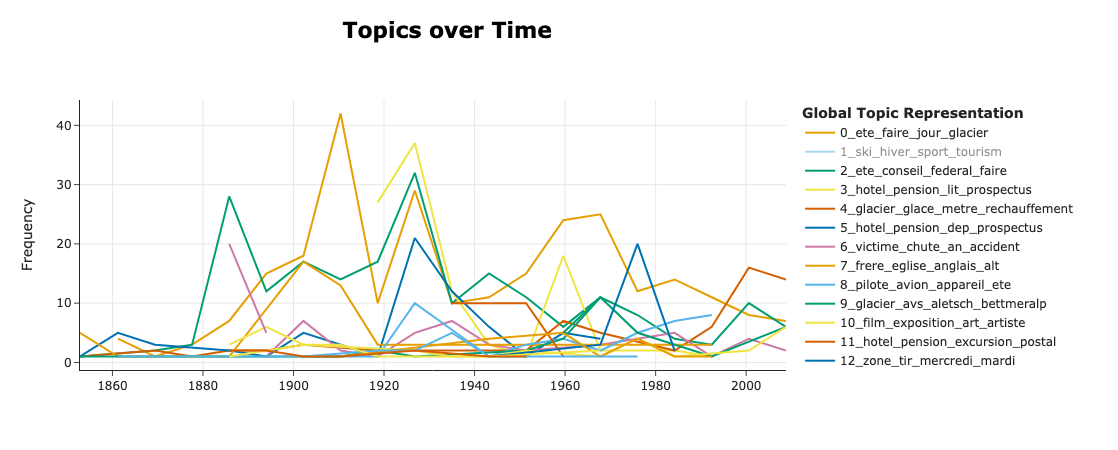

In [253]:
topic_model.visualize_topics_over_time(topics_over_time, top_n_topics=20)



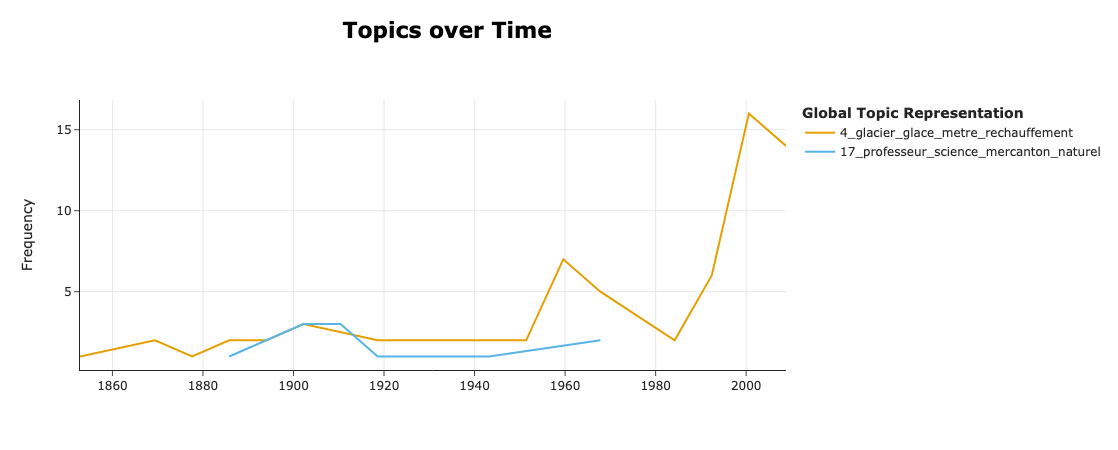

In [254]:
topic_model.visualize_topics_over_time(topics_over_time, topics=[4,17])



In [255]:
# keywords = ['réchauffement', 'réchauffe', 'climatique', 'glacier','glacière', 'météo','calotte glaciaire', 'érosion','alpinisme','niveau de la mer','banquise','inlandsis','iceberg',
# 'dégel','permafrost','géomorphologie','dérèglement','vague de chaleur','gaz à effet de serre','masse glaciaire']

In [256]:
# from nltk.tokenize import word_tokenize
# from functools import partial

# def get_frequency(phrase, keyword):
    
#     return phrase.count(keyword)

# def get_total(phrase):
#     total = 0
#     for keyword in keywords:
#         total += phrase.count(keyword)
#     return total

# for keyword in keywords: 
#     data[keyword] = data['cleaned_text'].progress_apply(partial(get_frequency, keyword))

# data['total'] = data['cleaned_text'].progress_apply(get_total)

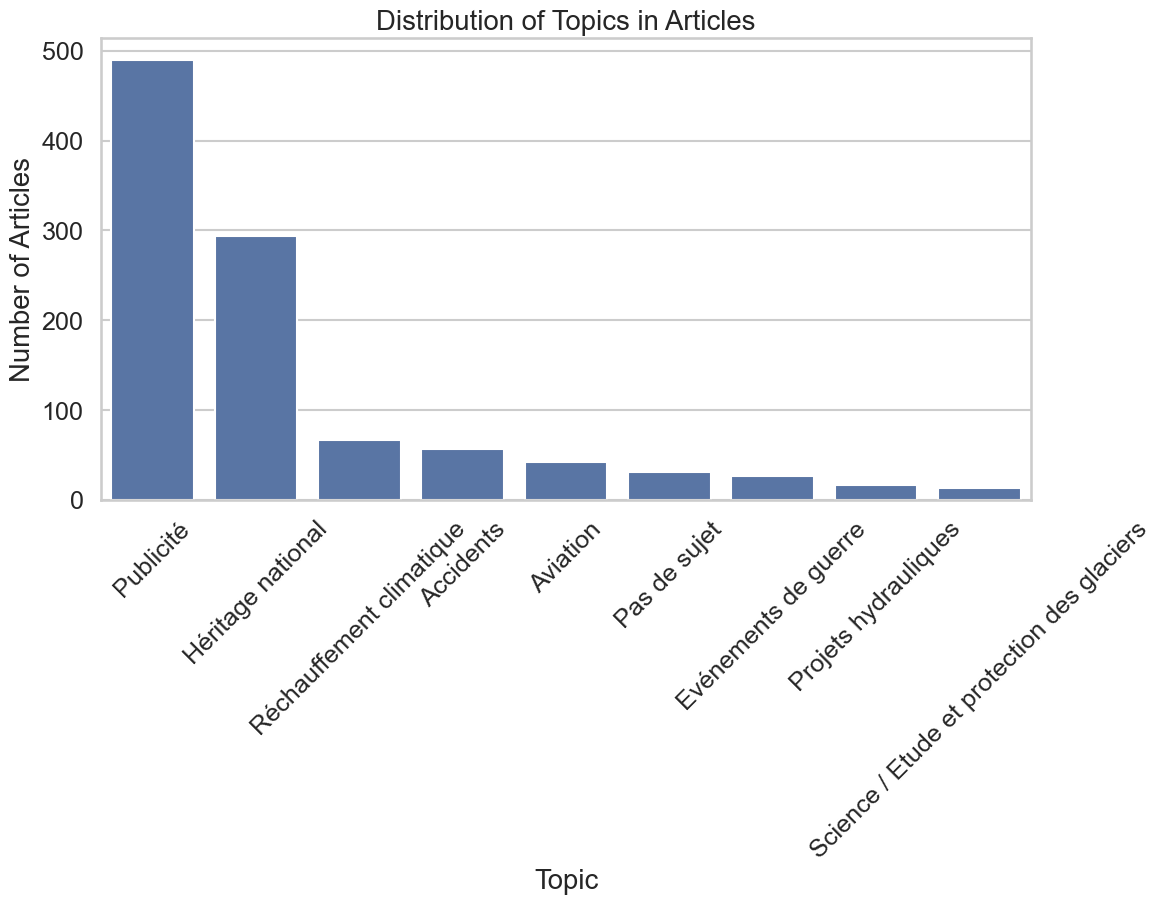

In [257]:
# Topic Distribution
topic_distribution = filtered_data['topic_name'].value_counts()

# Plotting the distribution
plt.figure(figsize=(12, 6))
sns.barplot(x=topic_distribution.index, y=topic_distribution.values)
plt.xticks(rotation=45)
plt.title('Distribution of Topics in Articles')
plt.xlabel('Topic')
plt.ylabel('Number of Articles')
plt.show()


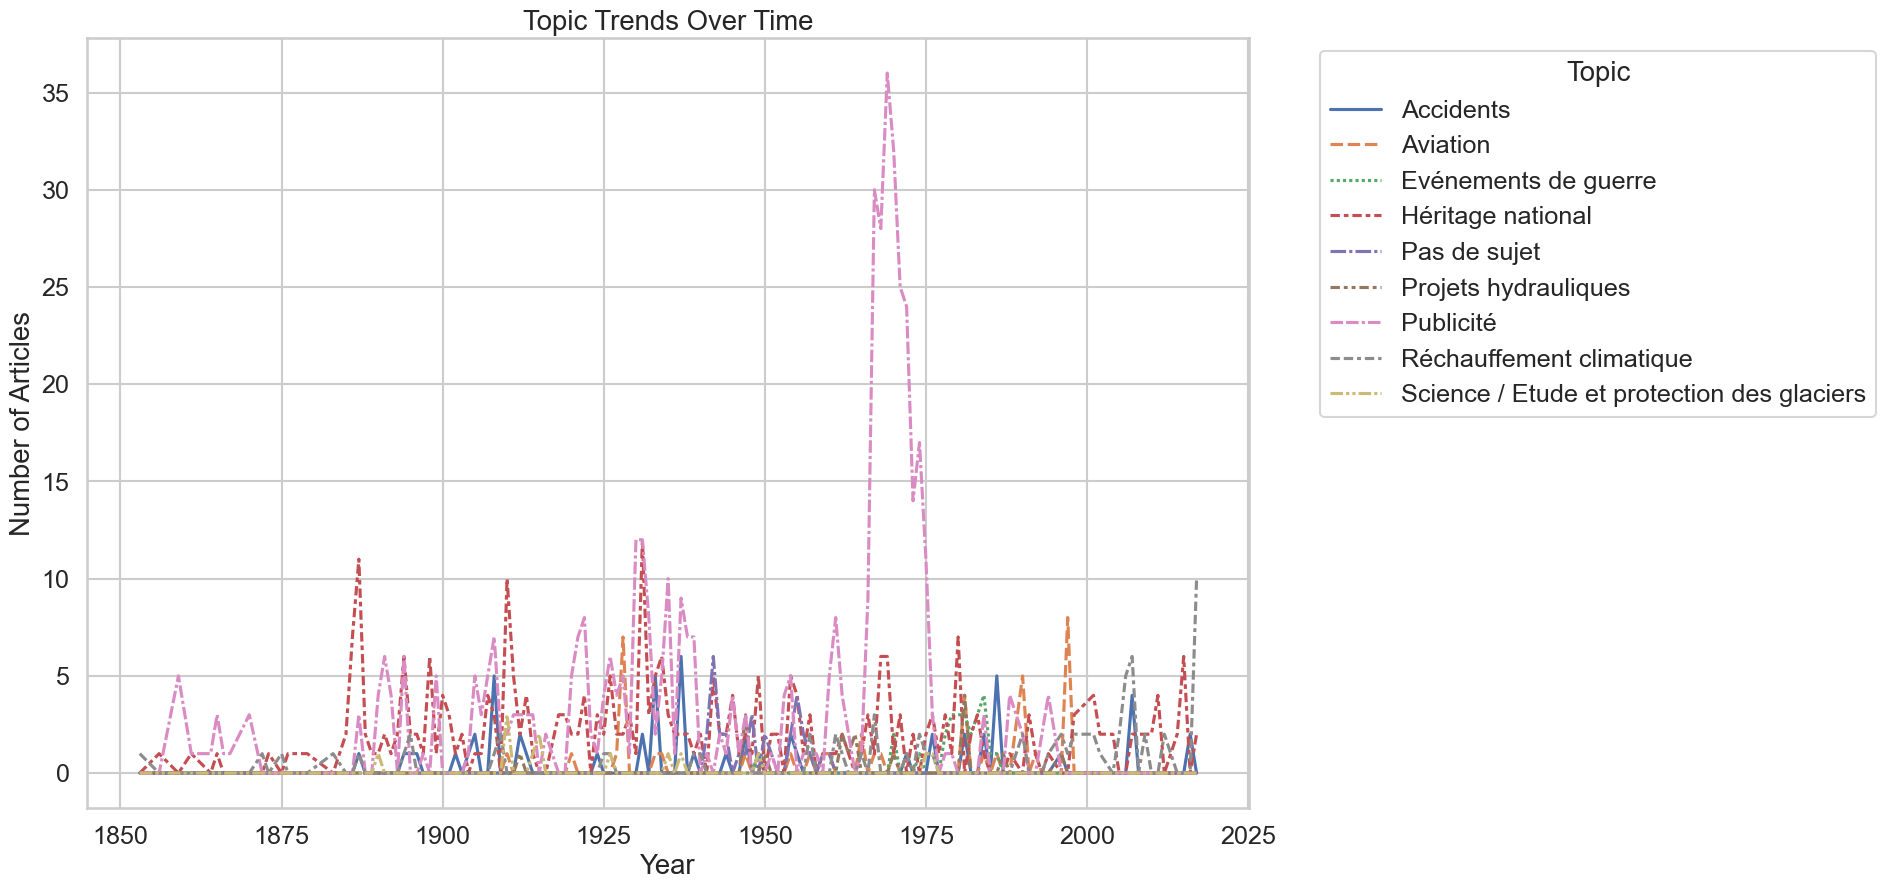

In [258]:
# Topic Trends Over Time
topic_trends = filtered_data[filtered_data.topic_name != "No Topic"].groupby(['Year', 'topic_name']).size().reset_index(name='count')
pivot_topics = topic_trends.pivot(index='Year', columns='topic_name', values='count').fillna(0)

# Plot
plt.figure(figsize=(15, 10))
sns.lineplot(data=pivot_topics)
plt.title('Topic Trends Over Time')
plt.xlabel('Year')
plt.ylabel('Number of Articles')
plt.legend(title='Topic', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()


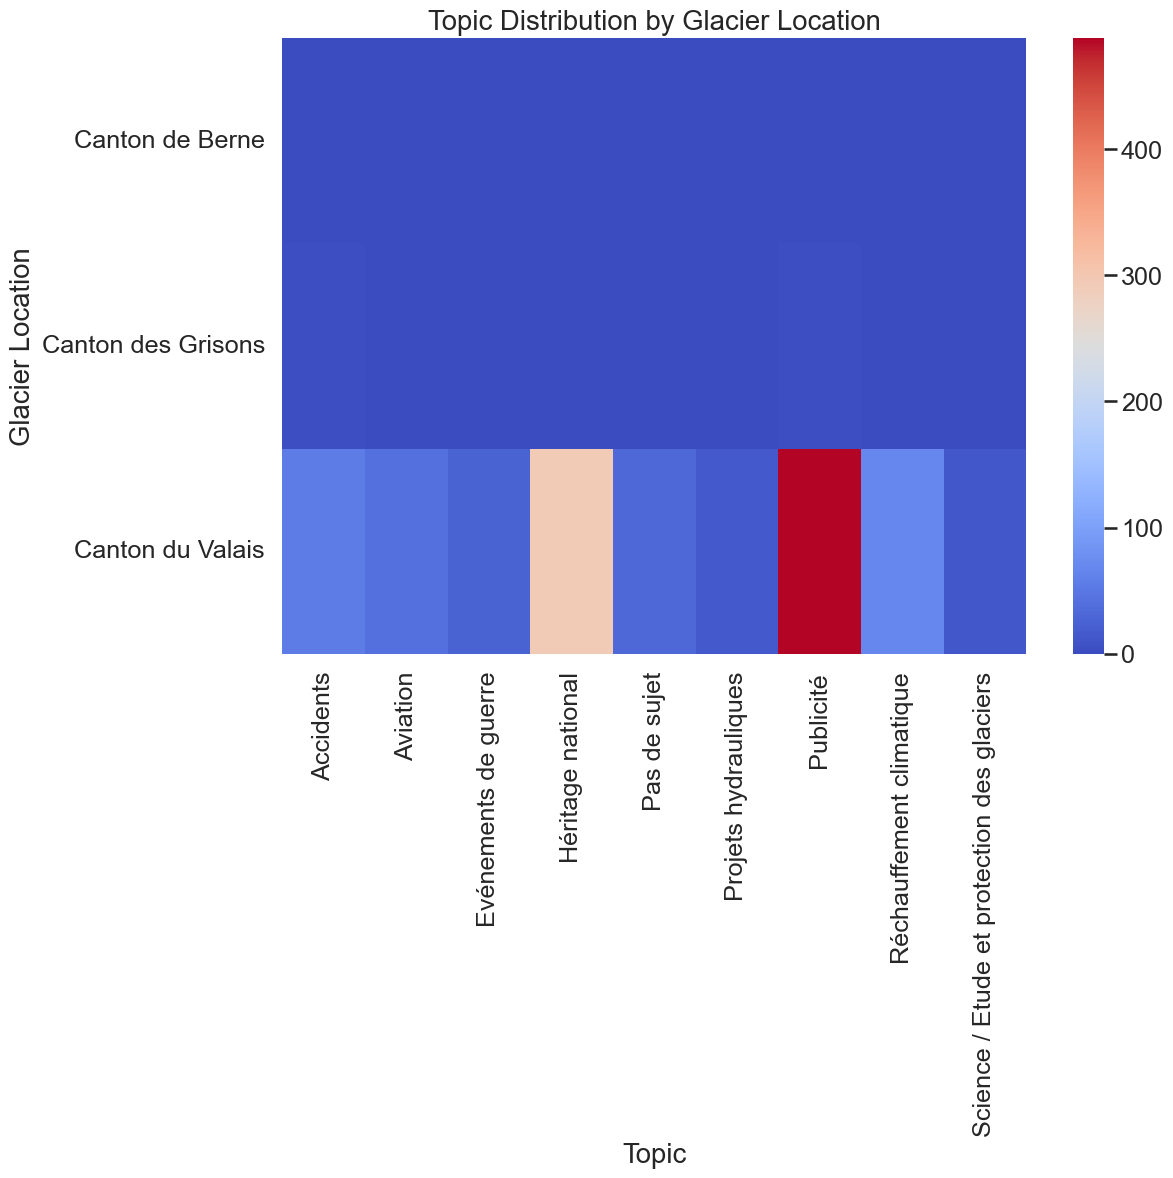

In [259]:
# Topic Distribution by Glacier Location
topic_glacier_location = filtered_data.groupby(['glacier_location', 'topic_name']).size().reset_index(name='count')
pivot_glacier_topic = topic_glacier_location.pivot(index='glacier_location', columns='topic_name', values='count').fillna(0)

# Heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(pivot_glacier_topic, annot=False, cmap='coolwarm')
plt.title('Topic Distribution by Glacier Location')
plt.xlabel('Topic')
plt.ylabel('Glacier Location')
plt.show()


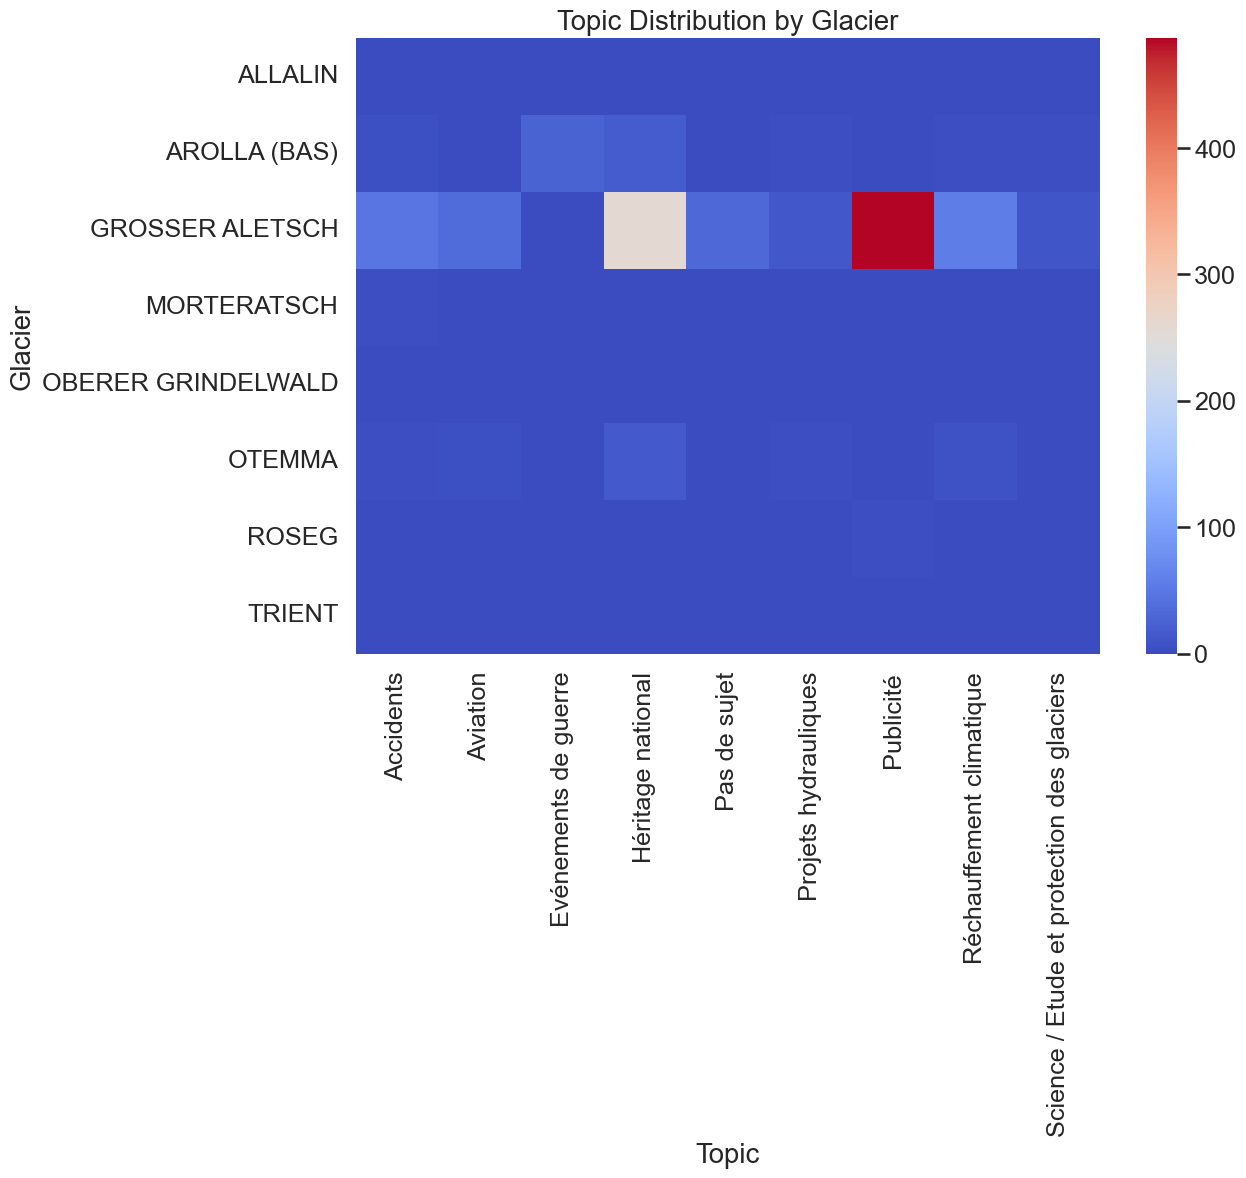

In [260]:
# Topic Distribution by Glacier 
topic_glacier_location = filtered_data.groupby(['NAME', 'topic_name']).size().reset_index(name='count')
pivot_glacier_topic = topic_glacier_location.pivot(index='NAME', columns='topic_name', values='count').fillna(0)

# Heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(pivot_glacier_topic, annot=False, cmap='coolwarm')
plt.title('Topic Distribution by Glacier')
plt.xlabel('Topic')
plt.ylabel('Glacier')
plt.show()


Let's also look at the climate change topic (7):

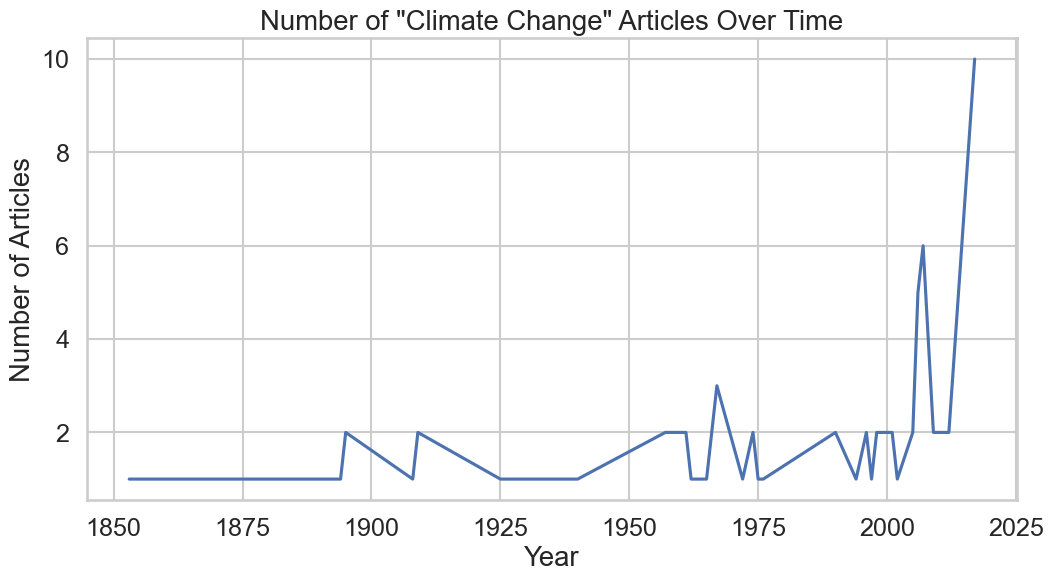

In [265]:
# Filter for "Climate Change" articles
climate_change_articles = filtered_data[filtered_data['topic_name'] == 'Réchauffement climatique']

# Group by year and count
climate_change_trend = climate_change_articles.groupby('year').size()

# Plotting
plt.figure(figsize=(12, 6))
sns.lineplot(data=climate_change_trend)
plt.title('Number of "Climate Change" Articles Over Time')
plt.xlabel('Year')
plt.ylabel('Number of Articles')
plt.show()


In [266]:
#!pip install wordcloud


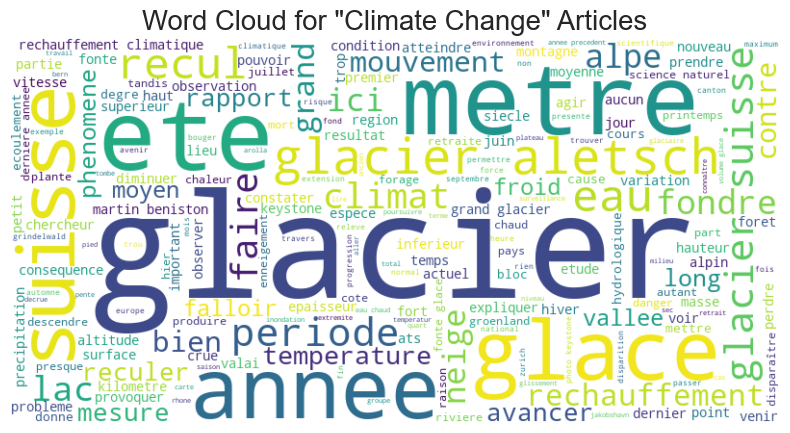

In [268]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Filter for "Climate Change" articles
climate_change_articles = filtered_data[filtered_data['topic_name'] == 'Réchauffement climatique']

# Aggregate the text of these articles
text = ' '.join(article for article in climate_change_articles['cleaned_text_with_lemmatisation'])

# Generate the word cloud
wordcloud = WordCloud(width=800, height=400, background_color ='white').generate(text)

# Display the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud for "Climate Change" Articles')
plt.show()


In [ ]:
# Filter for "Climate Change" articles
climate_change_articles = filtered_data[filtered_data['topic_name'] == 'Réchauffement climatique']

# Group by location and count the number of articles
location_counts = climate_change_articles['glacier_location'].value_counts()

location_counts



In [ ]:
# Loop through each row in the DataFrame and print the information
for index, row in climate_change_articles.iterrows():
    print(f"Year: {row['Year']}")
    print(f"Article Title: {row['title']}")
    print(f"Newspaper: {row['newspaper']}")
    print(f"Country: {row['country']}")
    print(f"Event Type: {row['EVENT_TYPE']}")
    print(f"Event Description: {row['EVENT_DESCRIPTION']}")
    print(f"Content: {row['content']}\n")
    print("---------------------------------------------------\n")


# Sentiment Analysis

In [272]:
final_data.columns


Index(['uid', 'language', 'title', 'size', 'country', 'newspaper', 'issue',
       'pages', 'nb_pages', 'year', 'is_on_front', 'date', 'persons_mentioned',
       'locations_mentioned', 'content', 'filename', 'NAME', 'Year',
       'POLITICAL_UNIT', 'WGMS_ID_x', 'FRONT_VARIATION', 'FRONT_VAR_UNC',
       'QUALITATIVE_VARIATION', 'SURVEY_DATE', 'SURVEY_PATFORM_METHOD',
       'REFERENCE_DATE', 'PUB_IN_FOG_x', 'SPONS_AGENCY', 'REMARKS_x',
       'Event_ID', 'WGMS_ID_y', 'EVENT_DATE', 'ET_SURGE', 'ET_CALVING',
       'ET_FLOOD', 'ET_AVALANCHE', 'ET_TECTONIC', 'ET_OTHER',
       'EVENT_DESCRIPTION', 'INVESTIGATOR', 'SPONSORING_AGENCY', 'REFERENCE',
       'REMARKS_y', 'PUB_IN_FOG_y', 'EVENT_TYPE', 'sentence_with_glacier',
       'glacier_location', 'cleaned_text', 'cleaned_text_with_lemmatisation',
       'topics', 'topic_name'],
      dtype='object')

In [273]:
from transformers import pipeline

sentiment_classifier = pipeline(
    model="lxyuan/distilbert-base-multilingual-cased-sentiments-student", 
    #model="nlptown/bert-base-multilingual-uncased-sentiment",
    return_all_scores=True
)

sentiment_classifier("I love this movie and I would watch it again and again!")


[[{'label': 'positive', 'score': 0.9754056930541992},
  {'label': 'neutral', 'score': 0.015554350800812244},
  {'label': 'negative', 'score': 0.009039930999279022}]]

In [274]:
def get_sentiment(sentence):
    # Cutting the sentence so it can be accepted by the model
    if sentence is None:
        return None
    sentence = ' '.join(sentence.split(' ')[:100])
    # Perform sentiment analysis
    sentiment_result = sentiment_classifier(sentence)

    # Extract the label with the highest score
    sentiment_label = max(sentiment_result[0], key=lambda x: x['score'])['label']
    return sentiment_label

# Apply the sentiment analysis to the 'sentence_with_glacier' column
filtered_data['sentiment'] = filtered_data['content'].progress_apply(get_sentiment)

# Display the first few rows of the DataFrame to verify
print(filtered_data[['sentence_with_glacier', 'sentiment']].head())


  0%|          | 0/1037 [00:00<?, ?it/s]

                                sentence_with_glacier sentiment
2                                                None  negative
5   Mattmark Le glacier de l'Allalin a avance de 1...  negative
6                                                None  negative
7                                                None  negative
11                                               None  negative


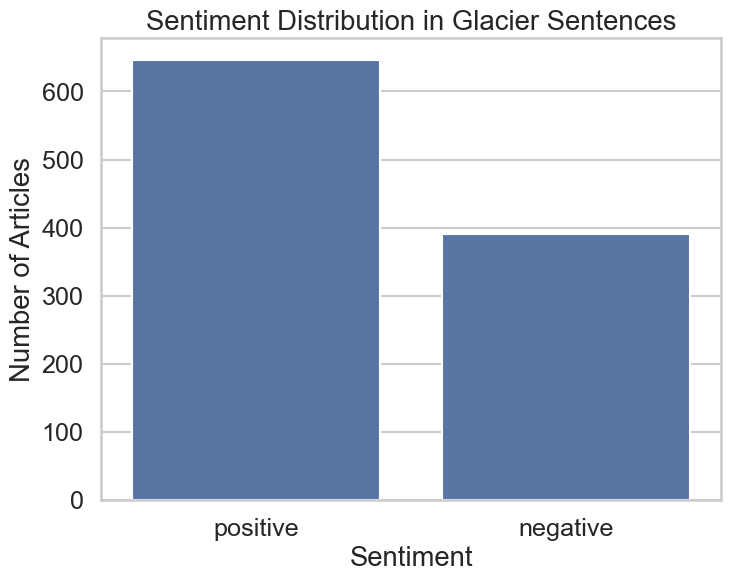

In [275]:
import matplotlib.pyplot as plt
import seaborn as sns

# Count the frequency of each sentiment
sentiment_counts = filtered_data['sentiment'].value_counts()

# Plotting the sentiment distribution
plt.figure(figsize=(8, 6))
sns.barplot(x=sentiment_counts.index, y=sentiment_counts.values)
plt.title('Sentiment Distribution in Glacier Sentences')
plt.xlabel('Sentiment')
plt.ylabel('Number of Articles')
plt.show()


In [276]:
CHECK_SENTIMENT = 'negative'

for index, row in filtered_data[filtered_data['sentiment'] == CHECK_SENTIMENT].iterrows():
    print(f"Title: {row['title']}")
    print(f"Date: {row['date']}")
    print(f"Content: {row['content'][:400]}\n")
    print("----------------------------------------------------\n")
    

Title: L'EXPOSITION DE CHICAGO
Date: 1893-11-18T00:00:00Z
Content: LEXPOSITION DE CHICAGO Chicago , le 6 oclobre 1893 . ] . ^ architecture purement ionique du Pa-J . s des Beaux-Arts nous repose bien agrea-. « Oient des agglomerations de styles que « s avons du subir jusqua present . ; Cest « Si le palais le plus solidement construit , i ; qui n a pas empeche le dernier cyclone 6 n enlever une partie de la toiture . ues milliers de tableaux et des centaines ^ sta

----------------------------------------------------

Title: Mattmark Le glacier de l'Allalin a avancé de 100 mètres
Date: 1965-10-02T00:00:00Z
Content: Mattmark Le glacier de l'Allalin a avance de 100 metres Mattrnark.-Les observations faites a Mattmark depuis la date de la catastrophe jusqu'a ce jour permettent de conclure que durant ces quatre dernieres semaines la partie frontale du glacier de l'Allalin a avance de 100 metres environ au total sur la pente ou reposait l'ancienne masse. Ces derniers'temps cependant le glaci

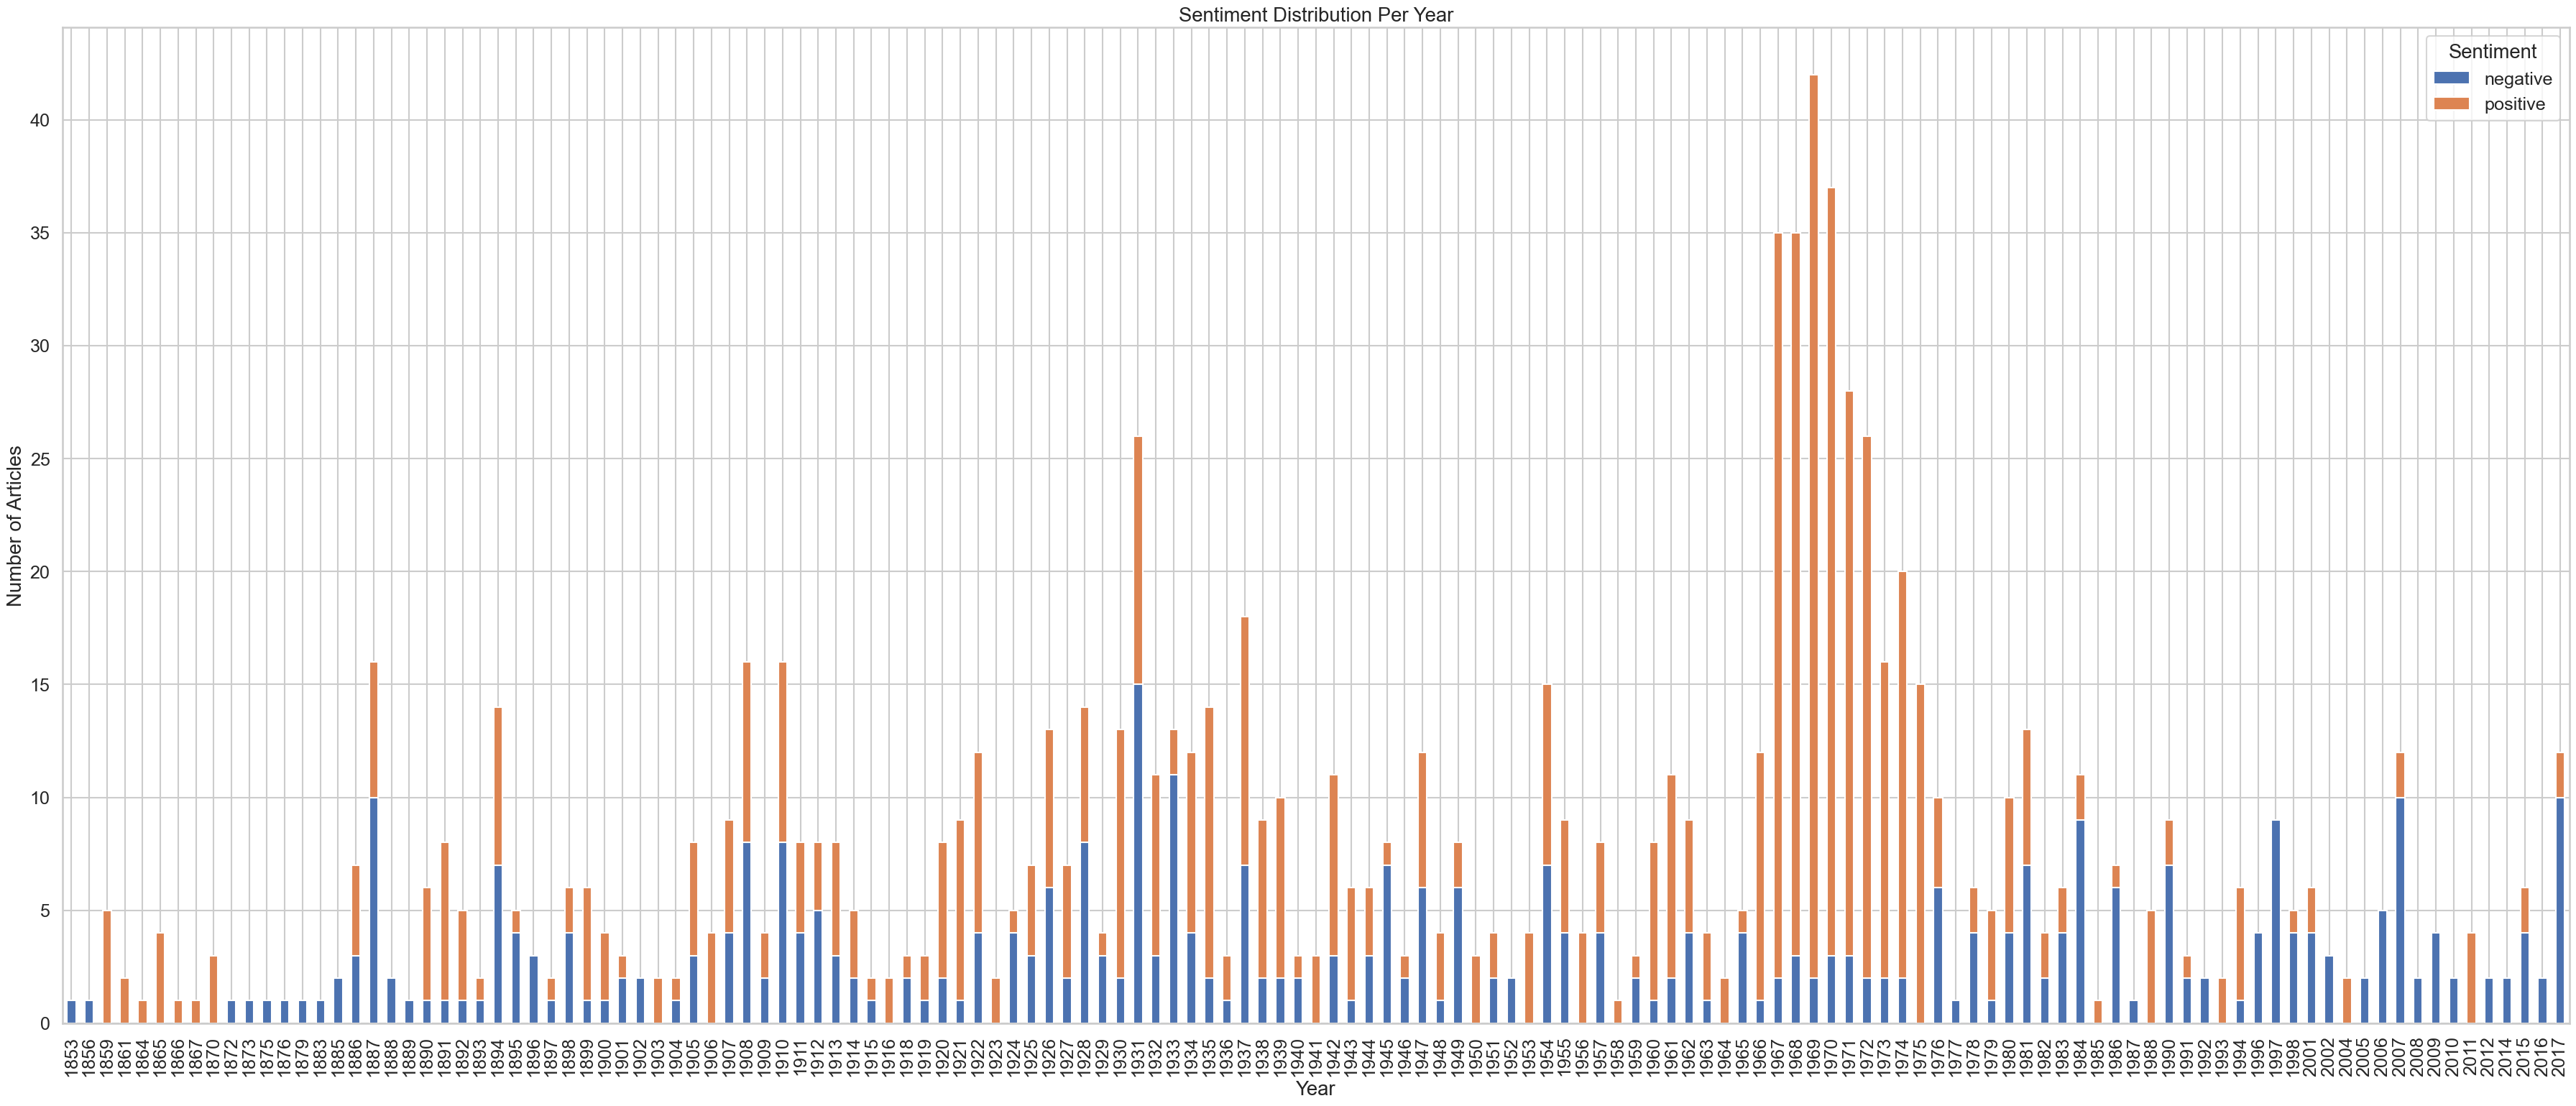

In [277]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Group by year and sentiment, then count occurrences
year_sentiment = filtered_data.groupby(['Year', 'sentiment']).size().reset_index(name='count')

# Pivot the data for plotting
pivot_year = year_sentiment.pivot(index='Year', columns='sentiment', values='count').fillna(0)

# Plotting
pivot_year.plot(kind='bar', stacked=True, figsize=(45, 18))
plt.title('Sentiment Distribution Per Year')
plt.xlabel('Year')
plt.ylabel('Number of Articles')
plt.legend(title='Sentiment')
plt.show()


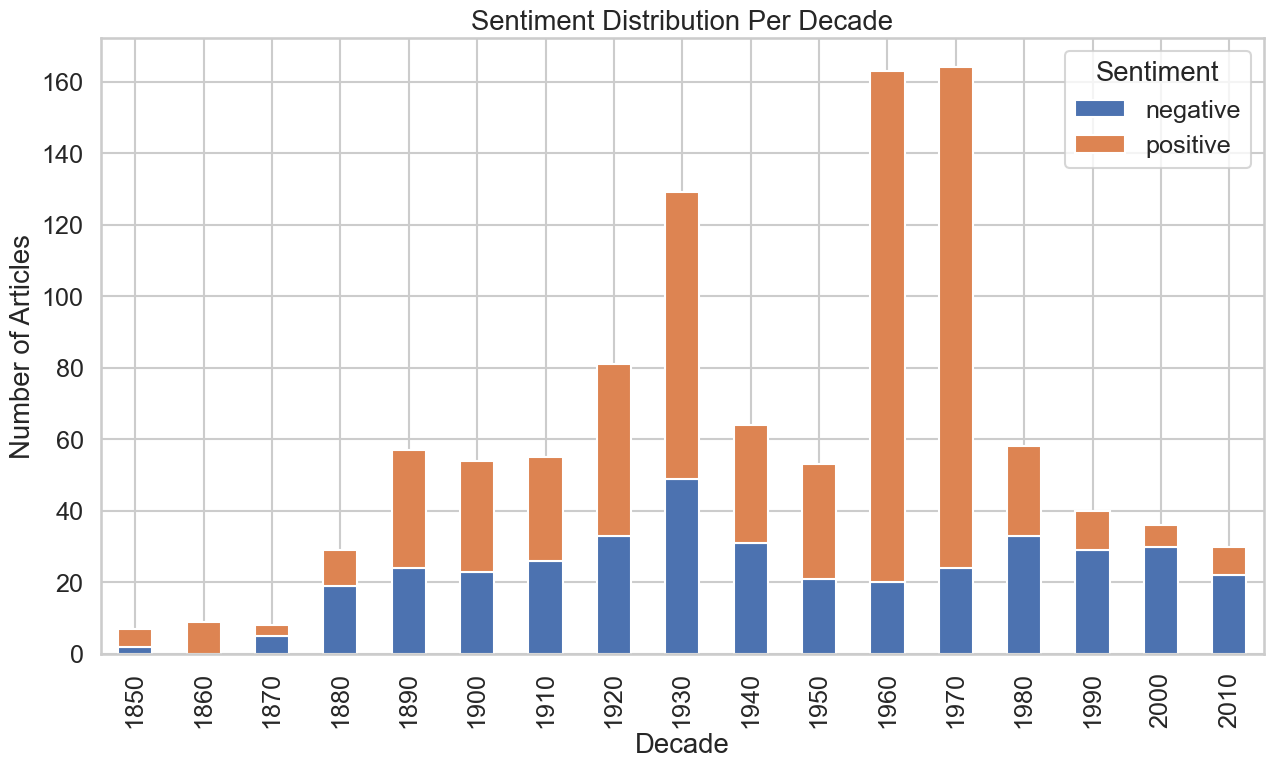

In [278]:
# Create a new column for the decade
filtered_data['decade'] = (filtered_data['Year'] // 10) * 10

# Group by decade and sentiment, then count occurrences
decade_sentiment = filtered_data.groupby(['decade', 'sentiment']).size().reset_index(name='count')

# Pivot the data for plotting
pivot_decade = decade_sentiment.pivot(index='decade', columns='sentiment', values='count').fillna(0)

# Plotting
pivot_decade.plot(kind='bar', stacked=True, figsize=(15, 8))
plt.title('Sentiment Distribution Per Decade')
plt.xlabel('Decade')
plt.ylabel('Number of Articles')
plt.legend(title='Sentiment')
plt.show()


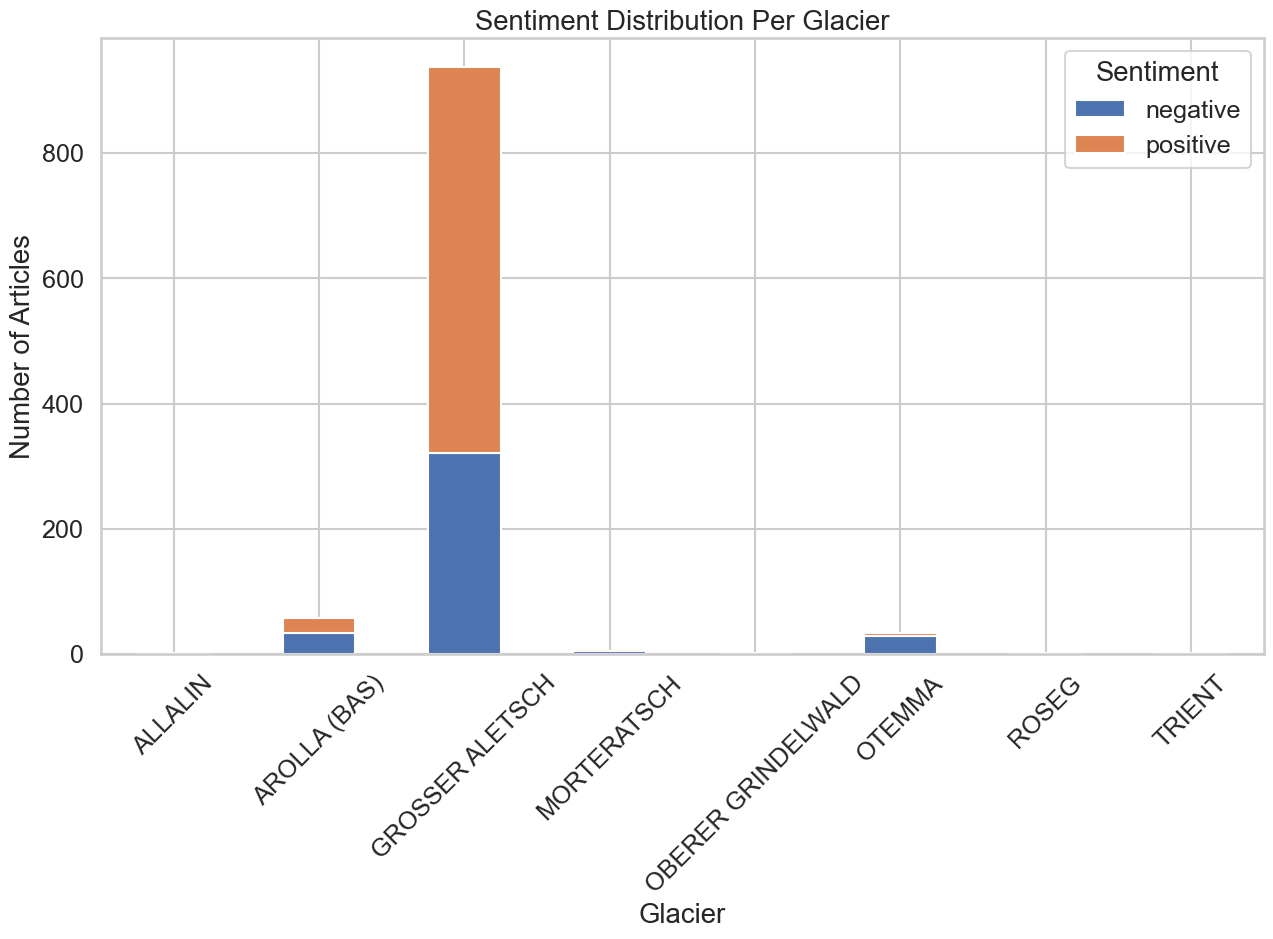

In [279]:
# Group by glacier and sentiment, then count occurrences
glacier_sentiment = filtered_data.groupby(['NAME', 'sentiment']).size().reset_index(name='count')

# Pivot the data for plotting
pivot_glacier = glacier_sentiment.pivot(index='NAME', columns='sentiment', values='count').fillna(0)

# Plotting
pivot_glacier.plot(kind='bar', stacked=True, figsize=(15, 8))
plt.title('Sentiment Distribution Per Glacier')
plt.xlabel('Glacier')
plt.ylabel('Number of Articles')
plt.legend(title='Sentiment')
plt.xticks(rotation=45)
plt.show()


In [282]:
climate_change_articles = filtered_data[filtered_data['topic_name'] == 'Réchauffement climatique']


Topic: climate change

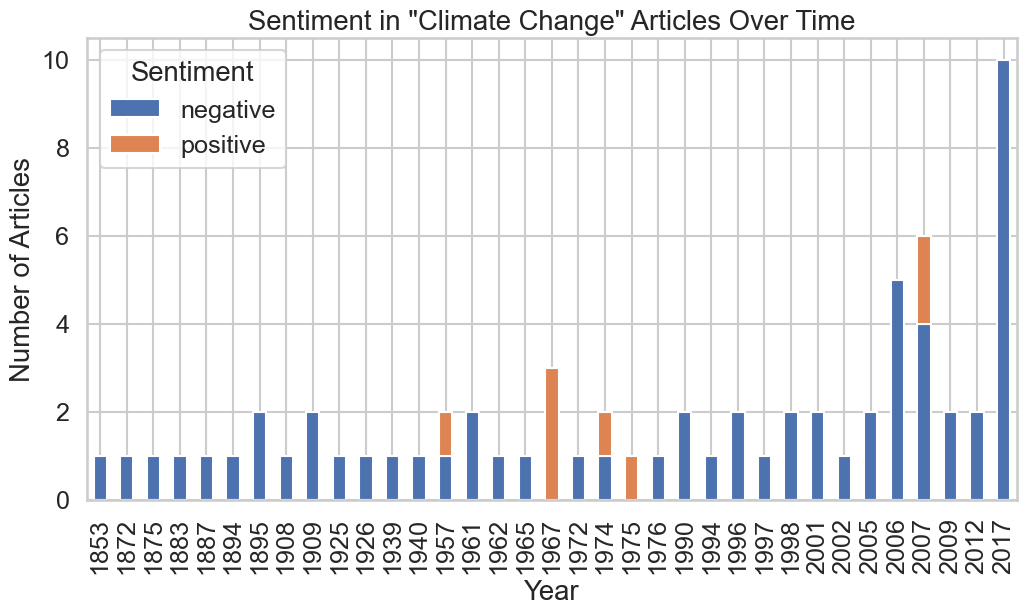

In [284]:
# Group by year and sentiment, then count occurrences
climate_change_sentiment = climate_change_articles.groupby(['Year', 'sentiment']).size().reset_index(name='count')

# Pivot the data for plotting
pivot_climate_change_sentiment = climate_change_sentiment.pivot(index='Year', columns='sentiment', values='count').fillna(0)

# Plotting
pivot_climate_change_sentiment.plot(kind='bar', stacked=True, figsize=(12, 6))
plt.title('Sentiment in "Climate Change" Articles Over Time')
plt.xlabel('Year')
plt.ylabel('Number of Articles')
plt.legend(title='Sentiment')
plt.show()


# Word frequencies

In [285]:
# import nltk
# from nltk.sentiment import SentimentIntensityAnalyzer

# nltk.download("vader_lexicon")

# sid = SentimentIntensityAnalyzer()

# pos = neg = neu = cumul_pos = cumul_neg = cumul_neu = 0

# for text in new_data['content']:
#     for sent in sent_tokenize(text):
#         sentiment_scores = sid.polarity_scores(sent)  
#         compound_score = sentiment_scores["compound"]

#         for keyword in keywords:
#             if keyword in sent:
#                 print(keyword, '----------', sent)

#                 if compound_score >= 0.05:
#                     sentiment = "Positive"
#                     pos += 1
#                 elif compound_score <= -0.05:
#                     sentiment = "Negative"
#                     neg += 1
#                 else:
#                     sentiment = "Neutral"
#                     neu += 1
                
#                 print(f"Sentiment: {sentiment}")
#                 print(keyword)
#                 print('Positive', pos)
#                 print('Negative',neg)
#                 print('Neutral',neu)
#         cumul_pos+=pos
#         cumul_neg+=neg
#         cumul_neu+=neu

In [286]:
# total = cumul_pos+cumul_neg+cumul_neu
# print('Positive:', cumul_pos, 'In percentage:',cumul_pos/total*100)
# print('Negative:',cumul_neg, 'In percentage:',cumul_neg/total*100)
# print('Neutral:',cumul_neu, 'In percentage:',cumul_neu/total*100)

In [287]:
# data.total.describe()

In [288]:
# data['cleaned_text'].isnull().sum()

In [289]:
# data.dropna(subset=['cleaned_text'], inplace=True)

In [290]:
# import numpy as np

# list_a = [1, 1, 1, 1, 1]
# list_b = [2, 2, 2, 2, 2]

# np.hstack([list_a, list_b]) # Exemple de fonctionnement de cette méthode avec des listes

In [291]:
import nltk
import numpy as np
freq = nltk.FreqDist(np.hstack([text.split(' ') if len(str(text)) > 0 else " " for text in filtered_data['cleaned_text_with_lemmatisation']]))

In [292]:
for word in ['climat', 'rechauffement', 'rechauffe', 'climatique', 'glacier', 'glaciers','glaciere', 'meteo',
'fonte','calotte glaciaire', 'erosion','alpinisme','niveau de la mer','banquise','inlandsis','iceberg',
'degel','permafrost','geomorphologie','dereglement','vague de chaleur','gaz a effet de serre','masse glaciaire']:
    print(word, ':', freq[word])

climat : 169
rechauffement : 71
rechauffe : 6
climatique : 165
glacier : 2511
glaciers : 0
glaciere : 2
meteo : 4
fonte : 46
calotte glaciaire : 0
erosion : 1
alpinisme : 5
niveau de la mer : 0
banquise : 2
inlandsis : 0
iceberg : 3
degel : 0
permafrost : 0
geomorphologie : 0
dereglement : 2
vague de chaleur : 0
gaz a effet de serre : 0
masse glaciaire : 0


In [293]:
for word in ['a neuve', 'aletsch', 'allalin', 'arolla', 'arpette', 'berons', 'cervin', 'corbassière', 'darrey',
'dolent', 'evole', 'fee', 'ferpècle', 'fiesch', 'findelen', 'finsteraar', 'forno', 'gauli', 'giesen',
'gorner', 'grands', 'giétro', 'inférieur grindelwald', 'supérieur grindelwald', 'grindelwald', 'kanderfirn', 'lang',
'lauteraar', 'martinets', 'moiry', 'moming', 'mont-miné', 'morteratsch', 'oberaar', 'orny', 'otemma',
'palü', 'pers', 'petoudes', 'plaine morte', 'planereuses', 'plines', 'ravines rousses', 'rhône', 'ried',
'plateau rosa', 'roseg', 'saleinaz', 'silvretta', 'théodule', 'tourtemagne', 'treutsebo', 'trient',
'trift (gadmen)', 'tsanfleuron', 'tschierva', 'unteraar', 'zinal', 'zmutt']:
        print(word, ':', freq[word])

a neuve : 0
aletsch : 1393
allalin : 30
arolla : 293
arpette : 0
berons : 0
cervin : 316
corbassière : 0
darrey : 0
dolent : 0
evole : 3
fee : 324
ferpècle : 0
fiesch : 180
findelen : 5
finsteraar : 0
forno : 0
gauli : 1
giesen : 0
gorner : 14
grands : 0
giétro : 0
inférieur grindelwald : 0
supérieur grindelwald : 0
grindelwald : 48
kanderfirn : 0
lang : 3
lauteraar : 0
martinets : 0
moiry : 28
moming : 3
mont-miné : 0
morteratsch : 7
oberaar : 1
orny : 55
otemma : 42
palü : 0
pers : 9
petoudes : 0
plaine morte : 0
planereuses : 0
plines : 0
ravines rousses : 0
rhône : 0
ried : 27
plateau rosa : 0
roseg : 5
saleinaz : 6
silvretta : 9
théodule : 0
tourtemagne : 77
treutsebo : 0
trient : 0
trift (gadmen) : 0
tsanfleuron : 2
tschierva : 1
unteraar : 6
zinal : 96
zmutt : 4


In [294]:
print(freq.most_common(25))

[('hotel', 6134), ('glacier', 2511), ('ete', 1889), ('grand', 1857), ('pension', 1798), ('aletsch', 1393), ('suisse', 1380), ('station', 1179), ('prospectus', 1037), ('lit', 931), ('centre', 892), ('sion', 851), ('excursion', 850), ('zermatt', 842), ('eau', 820), ('prix', 818), ('chemin', 756), ('faire', 720), ('route', 708), ('vacance', 695), ('montagne', 693), ('renseignement', 690), ('postal', 679), ('fer', 677), ('ideal', 654)]


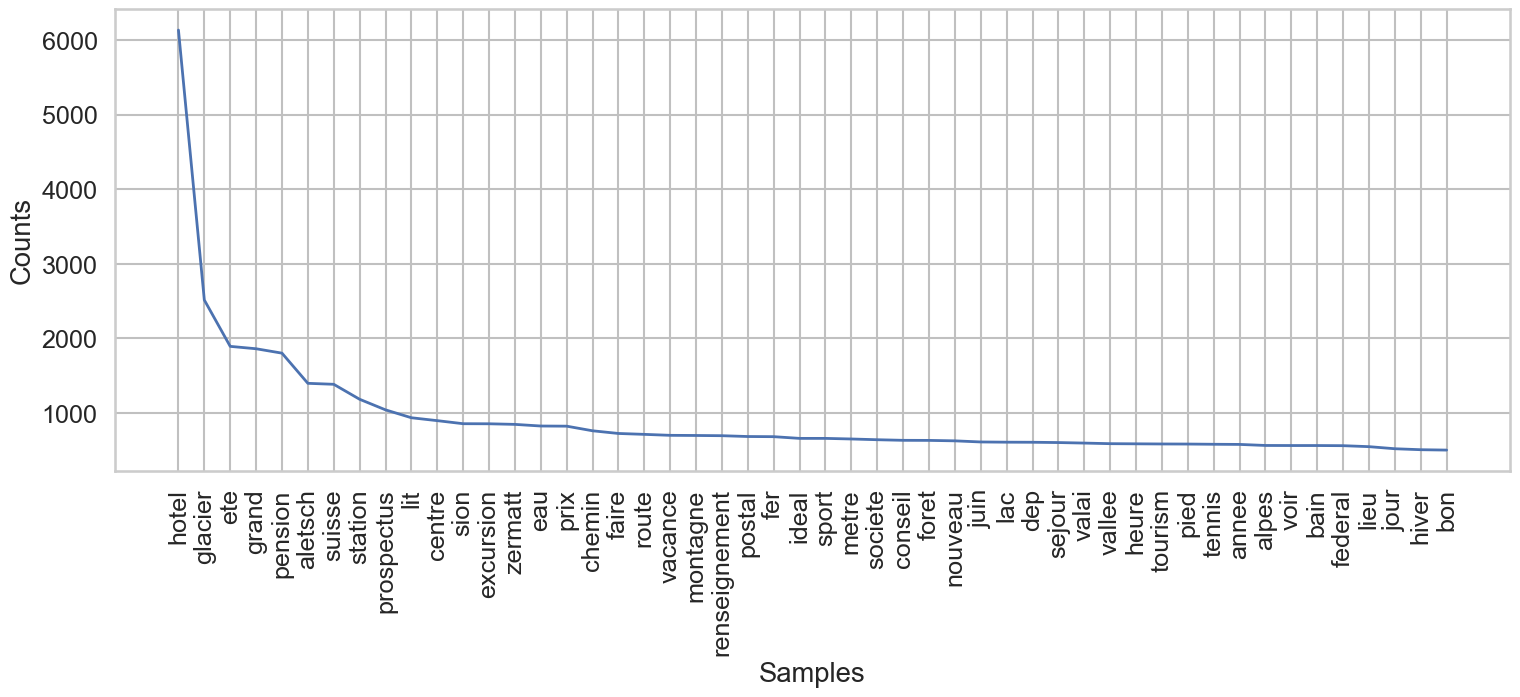

In [295]:
plt.figure(figsize=(18, 6))

_ = freq.plot(50, cumulative=False)

In [296]:
# #import nltk
# #import numpy as np

# yearly_freq_dict = {}

# for year in sorted(filtered_data['Year'].unique()):
#     data_year = data[filtered_data['Year'] == year]['cleaned_text_with_lemmatisation']
    
#     freq = nltk.FreqDist(np.hstack([text.split(' ') if len(str(text)) > 0 else " " for text in data_year]))
    
#     yearly_freq_dict[year] = freq.most_common(5)

# for year, freq_dist in yearly_freq_dict.items():
#     print(f"Year: {year}, Frequency Distribution: {freq_dist}")
    
    

In [309]:
#
#
#
#pour download tout les graphiques :
#pip install junix
#junix --filepath /Users/valentin/projet_bachelor/projet-bachelor-Copy4.ipynb
#
#
#